In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

/tmp/ipykernel_108948/1256517549.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import numpy as np
from tqdm import tqdm as tqdm
#from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
import optparse
import os.path as osp
import math
import torch_geometric
import torch
import sys
from torch_geometric.data import Data
import glob
from datetime import datetime
import random


from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import torch.jit as jit

In [3]:
# tt=torch.load("/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/ntup_pho_18082024/data_499.pt")
# np.unique(tt[0].clus2d_feat[:,5])

### set seed for reproducibility

In [4]:
seed = 42

In [5]:
torch.manual_seed(seed)
#torch.use_deterministic_algorithms(True) # not good: this makes the training break
random.seed(seed)

### create output directory to save checkpoints

In [6]:
#today = date.today()
now = datetime.now().strftime("%Y%m%d_%H%M%S")
out_dir = str(now)+'_checkpoints'
os.makedirs(out_dir, exist_ok=True) #check if output dir exist
print(out_dir)

20250227_235925_checkpoints


### tensors features

In [7]:
#########################################
# clus2d_feats = np.stack((ak.to_numpy(sel_clusters[ts].position_x),
#                          ak.to_numpy(sel_clusters[ts].position_y),
#                          ak.to_numpy(sel_clusters[ts].position_z),
#                          ak.to_numpy(sel_clusters[ts].energy),
#                          ak.to_numpy(sel_clusters[ts].cluster_time),
#                          ak.to_numpy(sel_clusters[ts].cluster_layer_id))).T

#                     #print(clus2d_feats.shape)
# clus3d_feats = np.stack((sel_tseta[ts][0],
#                          sel_tsphi[ts][0],
#                          sel_tsen[ts][0],
#                          sel_tst[ts][0],
#                          min(ak.to_numpy(sel_clusters[ts].cluster_layer_id)),
#                          max(ak.to_numpy(sel_clusters[ts].cluster_layer_id)))).T
# gun_feats = np.stack((sel_cpeta[ts][0],
#                       sel_cpphi[ts][0],
#                       sel_cpen[ts][0],
#                       sel_cpent[ts][0], 
#                       sel_ratem[ts][0]    trk_em/ sim_em
#                       sel_rattot[ts][0]   trk/sim
#                        )).T
########################################

### Load input data

In [8]:
from torch.utils.data import Dataset

class ClassificationDataset(Dataset):
    def __init__(self, datapath, numLC, feats, signal, ispi, abz):
        self.datapath_ = datapath
        self.numLC_ = numLC
        self.signal_ = signal
        self.ispi_ = ispi
        self.abz_ = abz
        self.feats_ = feats
        self.process = self.load_datafiles(self.datapath_)
        self.data = torch.stack(self.process[0],dim=0)
        self.labels = torch.stack(self.process[1],dim=0)
        self.masks = torch.stack(self.process[2],dim=0)
        self.info3d = torch.stack(self.process[3],dim=0)
        self.infogun = torch.stack(self.process[4],dim=0)


    def load_datafiles(self, filepath) :
        "filepath of the form /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_DATA/ntup_pho_frac0p8/ "
        print("processing files from:",filepath)
        filelist = [filen for filen in glob.glob(filepath+'data*.pt')]
        output_tensor_list = []
        label = []
        mask_tensor_list = []
        info3d_tensor_list = []
        infogun_tensor_list = []
        
        ctot = 0
        cll = 0
        
        
        for i in tqdm(filelist):
            if (len(label)>50000):
                    break
            
            for filei in torch.load(i) :
                ctot += 1
                #print(filei.gun_feat)
                passpi = False
                passpu = False
                nlay = len(np.unique(filei.clus2d_feat[:,5]))
                ratrec_true = (filei.clus3d_feat[2]/filei.gun_feat[:,3]).item()

                if (self.signal_):
#                    if (nlay < 13) :
                    if (ratrec_true < 0.7):
                        cll += 1                        
                        continue
                else:
                    feat2da = filei.clus2d_feat
                    fracen26 = torch.sum(feat2da[feat2da[:,5] <=26][:,3])/torch.sum(feat2da[:,3])
                    if self.ispi_:
                        #if (nlay > 10)and(fracen26 > 0.7)and(min(feat2da[:,5]) < 15) :
                        passpi = True
                        if not(passpi):
                            cll += 1
                            continue
                        #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay , fracen26)
                    else:
                        #if ((nlay < 10)and(fracen26 < 0.7))or ((nlay > 10)and(fracen26 < 0.7)) or ((nlay < 10)and(fracen26 > 0.7)):
                        #if not((nlay > 10)and(fracen26 > 0.7)and(min(feat2da[:,5]) < 15)):
                        if not((nlay > 10)and(fracen26 > 0.6)and(min(feat2da[:,5]) < 15)and((np.average(filei.clus2d_feat[:,2], weights=filei.clus2d_feat[:,3])) < 360)):
                            passpu = True
                        else:
                            pass
                            #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay, fracen26)
                        if not(passpu):
                            cll += 1
                            continue
                        #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay, fracen26)
               
                
                
                
                
                
                optensor = self.transform_data(filei.clus2d_feat, self.numLC_)
                output_tensor_list.append(optensor[0])
                mask_tensor_list.append(optensor[1])
                info3d_tensor_list.append(filei.clus3d_feat[[0,1,2,4,5]])
                infogun_tensor_list.append(filei.gun_feat)
                if self.signal_:
                    label.append(torch.ones(1,dtype=torch.double))
                else:
                    label.append(torch.zeros(1,dtype=torch.double))
         
        
        print ("nskipped | ntotal:",cll," | ",ctot)
        return output_tensor_list, label, mask_tensor_list, info3d_tensor_list, infogun_tensor_list
                
    def transform_data(self, tensor, nLC) :            

        #feats = [0,1,2,5]
        target = torch.zeros(nLC, len(self.feats_))
        mask0 = torch.ones(nLC)
        source = tensor[:nLC,self.feats_]
        mask1 = torch.zeros(source.shape[0])
        if self.abz_:
            source[:,2] = np.abs(source[:,2])
        target[:source.shape[0], :] = source
        #source = source.T
        mask0[:source.shape[0]] = mask1
        mask0 
        #print(mask0)
        return target, mask0 > 0
    
        
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx): 
        return self.data[idx], self.labels[idx], self.masks[idx], self.info3d[idx], self.infogun[idx]

#### Photon dataset (energy spread: 10-1000 GeV)

In [9]:
pho_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho_30072024/"
pho_dataset = ClassificationDataset(pho_path, 150, [0,1,5,3], True, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho_30072024/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 34.62it/s]


nskipped | ntotal: 119  |  50000


#### Pion dataset: pion sample from where high energy early showering pions are removed

In [10]:
hizpu_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2R0p9_pi_30072024/"
hizpu_dataset = ClassificationDataset(hizpu_path, 150, [0,1,5,3], False, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2R0p9_pi_30072024/


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 484/500 [00:28<00:00, 17.28it/s]


nskipped | ntotal: 20625  |  70628


#### Pion dataset: low energy clusters within CEE + others (no CEE restrictions)

In [11]:
lowzpu_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rno_PUenrich_05082024/"
lowzpu_dataset = ClassificationDataset(lowzpu_path, 150, [0,1,5,3], False, True, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rno_PUenrich_05082024/


 17%|███████████████████▌                                                                                                 | 1/6 [00:40<03:24, 40.91s/it]


nskipped | ntotal: 0  |  95549


In [12]:
print("lenpho:",len(pho_dataset), " lenhizpu:",len(hizpu_dataset), " lenlozpu:",len(lowzpu_dataset))

lenpho: 49881  lenhizpu: 50003  lenlozpu: 95549


### Define training and testing datasets

In [13]:
nphos = len(pho_dataset)
idxstotsamp = np.arange(nphos)

### DEFINE Background COMPOSITION
hizpusel = torch.utils.data.Subset(hizpu_dataset, idxstotsamp[:int(0.3*nphos)])
lowzpusel = torch.utils.data.Subset(lowzpu_dataset, idxstotsamp[:int(0.7*nphos)])
#npusel = len(pho_dataset) - len(pisel)
#pusel = torch.utils.data.Subset(pu_dataset, idxstotsamp[:int(npusel)])

combdataset = torch.utils.data.ConcatDataset([pho_dataset, hizpusel, lowzpusel])

nsamp = len(combdataset)

idxs = np.arange(nsamp)
np.random.shuffle(idxs)
tridx = idxs[:int(0.8*nsamp)]
tsidx = idxs[int(0.8*nsamp):nsamp]
trdata = torch.utils.data.Subset(combdataset, tridx)
tsdata = torch.utils.data.Subset(combdataset, tsidx)

ntrainbatch = 600
## load train and test dataset
trainloader = torch.utils.data.DataLoader(trdata, batch_size=ntrainbatch ,shuffle=True)#, num_workers=2)
testloader = torch.utils.data.DataLoader(tsdata, batch_size=ntrainbatch,shuffle=True)#, num_workers=2)
## load all data, for plots later
totalloader = torch.utils.data.DataLoader(combdataset, batch_size=ntrainbatch,shuffle=True)#, num_workers=2)


print("total samples > npho | nhizpu | nlozpu | nTOT:",len(pho_dataset)," | ",len(hizpusel)," | ",len(lowzpusel)," | ",nsamp)
print("N_train, N_test:",len(trdata),",",len(tsdata))

total samples > npho | nhizpu | nlozpu | nTOT: 49881  |  14964  |  34916  |  99761
N_train, N_test: 79808 , 19953


### Define model

In [14]:
## Define model
## refer https://github.com/ludovicobuizza/HAR-Transformer/blob/main/src/transformer/transformer.py for batchnorm
import torch.nn as nn
import torch.nn.functional as F

class MHA_model(jit.ScriptModule):
    

    def __init__(
        self,
        input_dim = 6,
        dim_emb = 64,
        n_heads = 16,
        num_enclayers = 6,
        dim_feedforward = 64,
        n_seq = 150,
        output_dim = 2,
        norm=torch.tensor([1./100., 1./100., 1./100., 1./100.]),
    ):
        
        super(MHA_model, self).__init__()
        self.datanorm = nn.Parameter(norm, requires_grad=False) 
        self.emb_inp = nn.Sequential(
            nn.Linear(input_dim, dim_emb),
            nn.Dropout(0.1),
            nn.ELU(),
            #nn.LeakyReLU(negative_slope=0.4),
            nn.Linear(dim_emb, dim_emb),
            nn.Dropout(0.1),
#            nn.LeakyReLU(negative_slope=0.4),
#            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ELU(),
            #nn.LeakyReLU(negative_slope=0.4),
        )
        
#        self.emb_inp =  nn.Linear(input_dim, dim_emb)      
        encoder_layer = nn.TransformerEncoderLayer(
                dim_emb,
                n_heads,
                dim_feedforward,
                dropout = 0.2,
                batch_first= True,
                activation=nn.ELU(),  #nn.LeakyReLU(negative_slope=0.4),
            )
        
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_enclayers)
        
        self.output_layer = nn.Sequential(nn.Linear(n_seq*dim_emb + 5, dim_emb//2),
                                    
                                    #nn.LeakyReLU(negative_slope=0.4),
                                    nn.Dropout(0.3),
                                    nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(dim_emb//2, dim_emb//2),#added
                                    nn.Dropout(0.3),
                                    nn.ELU(),
                                    nn.Linear(dim_emb//2, dim_emb//2),#added
                                    nn.Dropout(0.3),
                                    nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(dim_emb//2, output_dim)
                                   )
    
    
    @jit.script_method
    def forward(self, X, mask, info3d) :
        
        
        #project input to dim_emb dimensional space
        X = self.datanorm*X
        inp = self.emb_inp(X) #* math.sqrt(self.dim_embed)
        
        output = self.transformer_encoder(inp, src_key_padding_mask=mask)  # (batch, seq, feat)
        output = output.reshape(output.shape[0], -1)  # (batch, seq * feat)
        output = torch.concat((output,info3d), dim = -1)
        output = self.output_layer(output)  # (batch, num_classes)

        return F.log_softmax(output, dim=-1)

### define training and testing functions

In [15]:
### define training and testing functions
#from lr_modulation import *
device = torch.device('cuda:1')#('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
#model = NetCNN().to(float) ### change to NetDNN().to(float) for DNN
#model = model.to(device)


model = MHA_model(n_seq=150,
        input_dim = 4,
        dim_emb = 16,#32
        n_heads = 16,
        num_enclayers = 6,#4
        dim_feedforward = 64,
        output_dim = 2)


model = model.to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
#scheduler = CyclicLRWithRestarts(optimizer, ntrainbatch, epoch_size, restart_period=10, t_mult=1.2, policy="cosine")
#scheduler = CyclicLRWithRestarts(optimizer, 200, 200, restart_period=30, t_mult=1.2, policy="cosine")
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,50)
#lossfunction = nn.BCELoss()



def train(epoch):
    model.train()
    torch.cuda.empty_cache()
    loss = []
    true_preds, num_preds = 0., 0.
    iters = len(trainloader)
    cc = 0
    for data in tqdm(trainloader):  ### change to loaderDNN for DNN
            #datax, label = data[0].to(device), data[1].to(device)
            datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
            label = label.to(torch.long).squeeze()
            optimizer.zero_grad()
            result = model(datax, masks, info3d)
            #print(result)
            
            #print(label)
            #print(result.dtype)
            #lossc = lossfunction(result, label)
            lossc = F.nll_loss(result, label)
            
            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            scheduler.step(epoch + cc / iters)
            cc += 1
            pred_labels = torch.argmax(result.cpu(), dim=-1) 
            true_preds += (pred_labels == label.cpu()).sum()
            num_preds += label.shape[0]
            
    acc = true_preds / num_preds
    #print( 'batches for train:',len(loss)) 
    print('train loss:',np.mean(np.array(loss)))
    print('train acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)


def test(epoch):
    model.eval()
    loss = []
    true_preds, num_preds = 0., 0.
    for data in tqdm(testloader): ### change to loaderDNN for DNN
            datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)            
            label = label.to(torch.long).squeeze()
            result = model(datax, masks, info3d)
            lossc = F.nll_loss(result, label)
            loss.append(lossc.item())
            
            pred_labels = torch.argmax(result.cpu(), dim=-1) 
            true_preds += (pred_labels == label.cpu()).sum()
            num_preds += label.shape[0]
            
            
    acc = true_preds / num_preds
    #print( 'batches for train:',len(loss)) 
    print('test loss:',np.mean(np.array(loss)))
    print('test acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)

/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/jit/_recursive.py:266: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


### Define output, training parameters, and launch training

epoch: 0
Learning rate: 0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:33<00:00,  4.06it/s]


train loss: 0.356363367011298
train acc: 0.8526213


  0%|                                                                                                                            | 0/34 [00:00<?, ?it/s]/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/nn/modules/module.py:1501: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at ../third_party/nvfuser/csrc/manager.cpp:335.)
  return forward_call(*args, **kwargs)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 13.00it/s]


test loss: 0.12526403783875353
test acc: 0.9580013
new best acc: 0.9580013
epoch: 1
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.1600132728579329
train acc: 0.955631


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.07454854184213806
test acc: 0.97864985
new best acc: 0.97864985
epoch: 2
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.09650887907552186
train acc: 0.97470176


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.07251827133929029
test acc: 0.9822082
new best acc: 0.9822082
epoch: 3
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.72it/s]


train loss: 0.07147393986185728
train acc: 0.9805283


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.08471124991774559
test acc: 0.9811557
epoch: 4
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.45it/s]


train loss: 0.05414265305943676
train acc: 0.9856155


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.040844409315682506
test acc: 0.9873202
new best acc: 0.9873202
epoch: 5
Learning rate: 0.0009756006540427169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0449054761331028
train acc: 0.98818415


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.03317671118523268
test acc: 0.99112916
new best acc: 0.99112916
epoch: 6
Learning rate: 0.0009649744976107358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.03876638743303605
train acc: 0.9898757


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.04847762035719557
test acc: 0.9892748
epoch: 7
Learning rate: 0.0009525132992633266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.03864819221824074
train acc: 0.99005115


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.03965740459149375
test acc: 0.98977596
epoch: 8
Learning rate: 0.0009382662376573867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.45it/s]


train loss: 0.035770040846415864
train acc: 0.9904521


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.7936121996711282
test acc: 0.84077585
epoch: 9
Learning rate: 0.0009222895394362114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.14383219524439592
train acc: 0.9551799


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.07117719762027264
test acc: 0.97539216


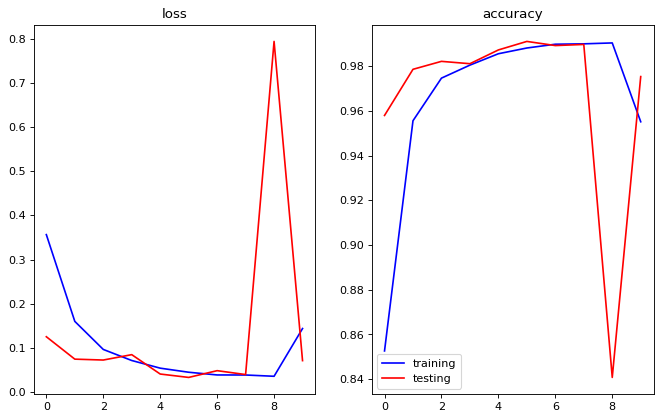

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


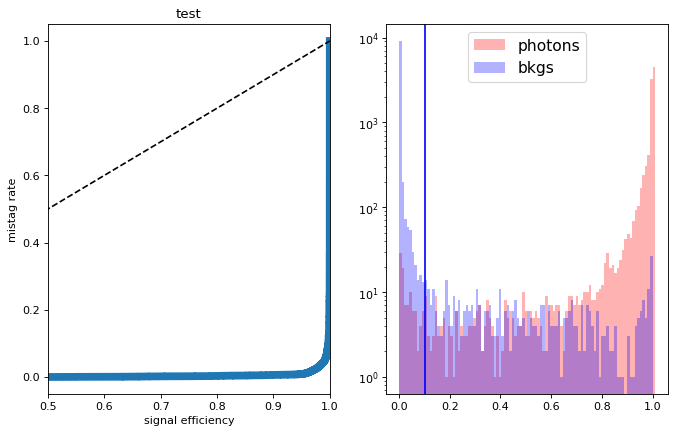

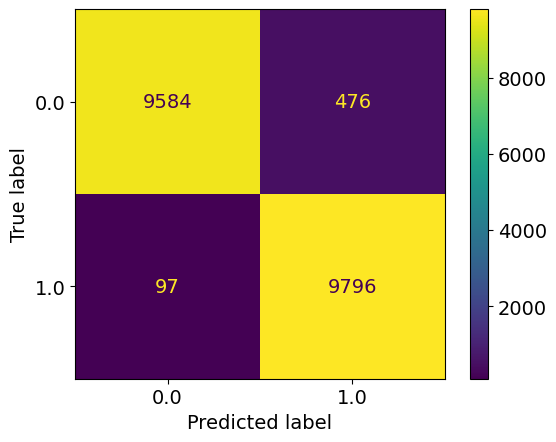

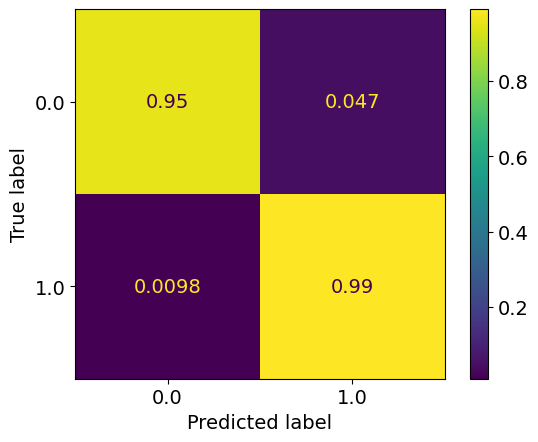

epoch: 10
Learning rate: 0.0009046462573286205


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.07489053958179012
train acc: 0.9760049


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.05275235522319289
test acc: 0.9830602
epoch: 11
Learning rate: 0.0008854060213086439


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.055304092994488
train acc: 0.9829842


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.059770992025732994
test acc: 0.98406255
epoch: 12
Learning rate: 0.0008646447637978247


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.04458615173274693
train acc: 0.9865302


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.05492468731587424
test acc: 0.9867689
epoch: 13
Learning rate: 0.0008424444199946417


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.036075337206138605
train acc: 0.99022657


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.061953992363722885
test acc: 0.98461384
epoch: 14
Learning rate: 0.0008188926045137138


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.03314130109866886
train acc: 0.9907528


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.86it/s]


test loss: 0.04095230352900484
test acc: 0.98937505
epoch: 15
Learning rate: 0.0007940822656109432


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.030491122293525807
train acc: 0.9917803


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.04287517284426619
test acc: 0.99007666
epoch: 16
Learning rate: 0.0007681113183592135


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.028514150759455428
train acc: 0.9918429


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.03268868971944732
test acc: 0.9926327
new best acc: 0.9926327
epoch: 17
Learning rate: 0.00074108225822233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.027519258058894037
train acc: 0.99235666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.03351360545767581
test acc: 0.9915301
epoch: 18
Learning rate: 0.0007131017565522499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.02539391326370524
train acc: 0.9930458


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.04873250909697484
test acc: 0.99007666
epoch: 19
Learning rate: 0.0006842802396059903


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.026833307719094427
train acc: 0.99251956


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.03398890523513889
test acc: 0.99148


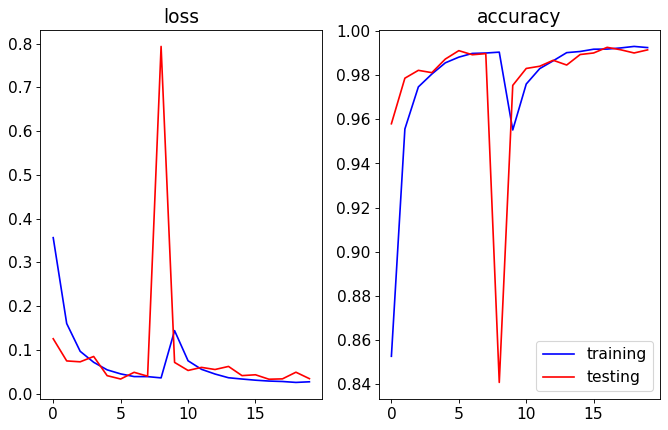

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


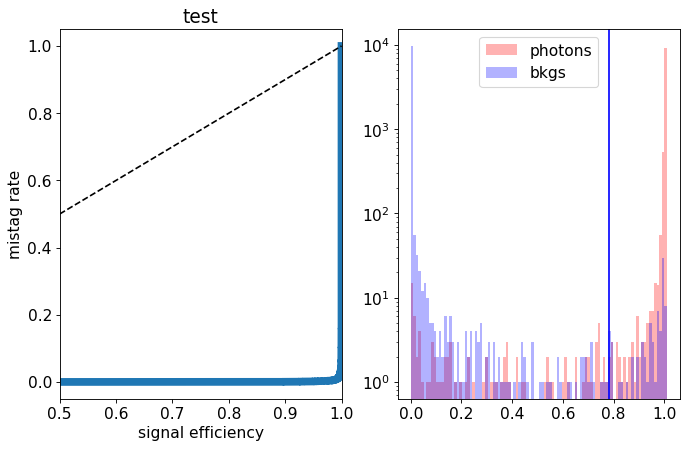

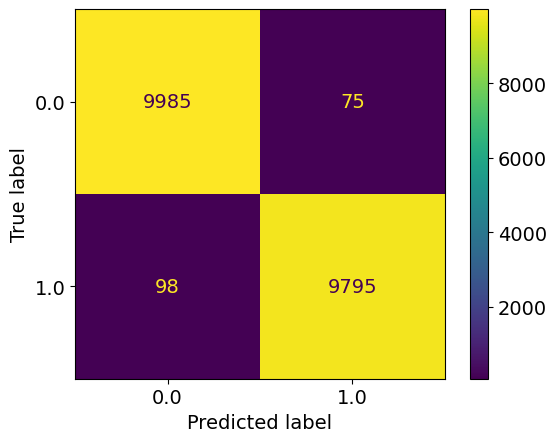

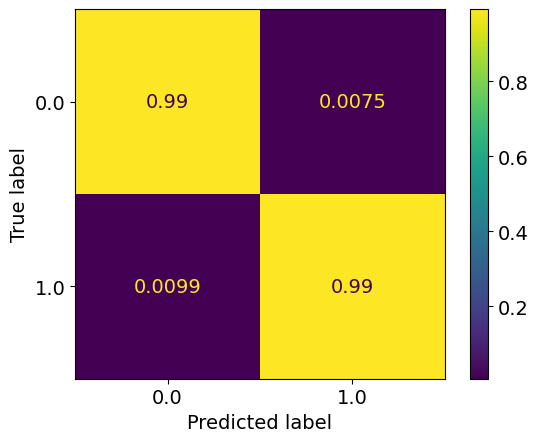

epoch: 20
Learning rate: 0.0006547314527436388


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.02531007193237432
train acc: 0.99309593


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.0355276043581612
test acc: 0.9918308
epoch: 21
Learning rate: 0.0006245720115273849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.022957825143613032
train acc: 0.9936222


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.03397373388083104
test acc: 0.9926327
epoch: 22
Learning rate: 0.0005939209414931709


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.02362788370037243
train acc: 0.993547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.026154594810898688
test acc: 0.99358493
new best acc: 0.99358493
epoch: 23
Learning rate: 0.0005628992084112799


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.45it/s]


train loss: 0.022595271509863547
train acc: 0.99388534


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.025091033425483415
test acc: 0.99343455
epoch: 24
Learning rate: 0.0005316292408897048


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.02251518630961317
train acc: 0.99372244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.03288229854832239
test acc: 0.9918308
epoch: 25
Learning rate: 0.0005002344472043634


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.023497560419448053
train acc: 0.99342173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.021550944794024175
test acc: 0.9943868
new best acc: 0.9943868
epoch: 26
Learning rate: 0.0004688387282630152


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.02284710742741712
train acc: 0.993547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.025958814733552143
test acc: 0.99373525
epoch: 27
Learning rate: 0.0004375659886249822


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.023398922435303372
train acc: 0.99344677


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.55it/s]


test loss: 0.031088532065041363
test acc: 0.99253243
epoch: 28
Learning rate: 0.0004065396475064596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.020213709391372056
train acc: 0.99448675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.024686014341354808
test acc: 0.9934847
epoch: 29
Learning rate: 0.0003758821517012554


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.020619545917833788
train acc: 0.99409837


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.03458166412790032
test acc: 0.9922317


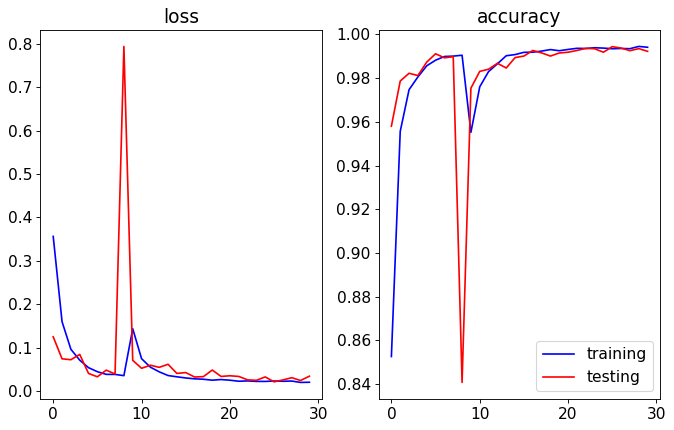

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.36it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


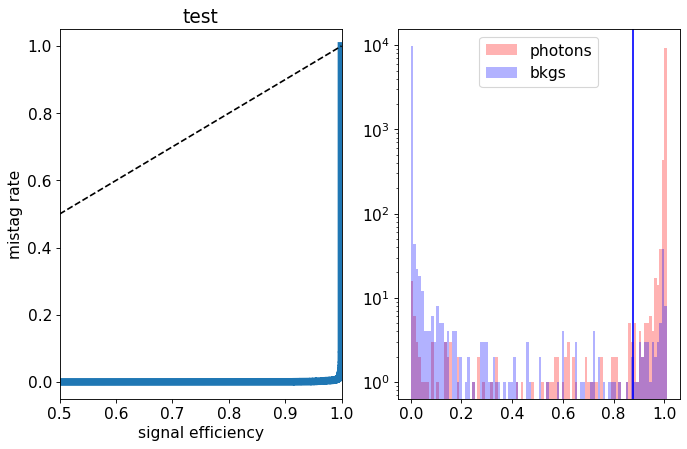

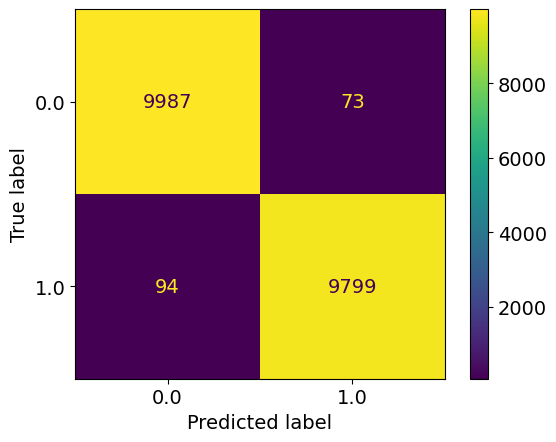

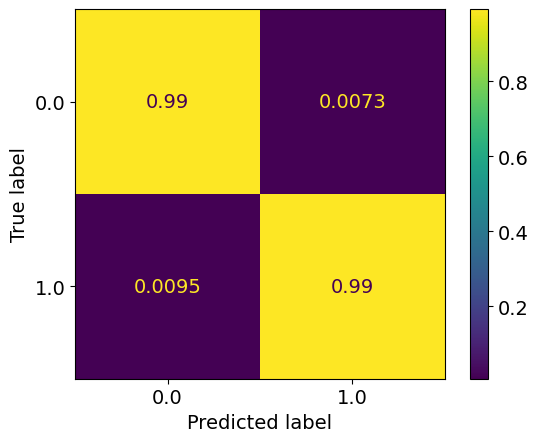

epoch: 30
Learning rate: 0.00034571449233923525


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.020046238003840755
train acc: 0.9944241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.018977619008236454
test acc: 0.9943868
epoch: 31
Learning rate: 0.0003161557273896085


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.021260723812199796
train acc: 0.9944617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.82it/s]


test loss: 0.022007173194330844
test acc: 0.99393576
epoch: 32
Learning rate: 0.00028732251179351616


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.019468589532519204
train acc: 0.9947123


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.033153952400693125
test acc: 0.9923821
epoch: 33
Learning rate: 0.00025932863708027284


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.0211570466268693
train acc: 0.9940858


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.029569612117484212
test acc: 0.9926828
epoch: 34
Learning rate: 0.00023228458228418658


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.018845491382335103
train acc: 0.99497545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.02670133197748595
test acc: 0.993184
epoch: 35
Learning rate: 0.00020629707793428436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.020408691063439892
train acc: 0.994374


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.025471869595896673
test acc: 0.9939859
epoch: 36
Learning rate: 0.00018146868483767388


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.024845667788063856
train acc: 0.99510074


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.029286691733218236
test acc: 0.9932341
epoch: 37
Learning rate: 0.00015789738931889374


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.025164660254020744
train acc: 0.9926699


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.0268765174824854
test acc: 0.9929835
epoch: 38
Learning rate: 0.00013567621651265567


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.019059431405109007
train acc: 0.9946998


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.027310625162071493
test acc: 0.9932341
epoch: 39
Learning rate: 0.00011489286323613779


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.018838242190254074
train acc: 0.9950256


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]


test loss: 0.03167942887076231
test acc: 0.9926828


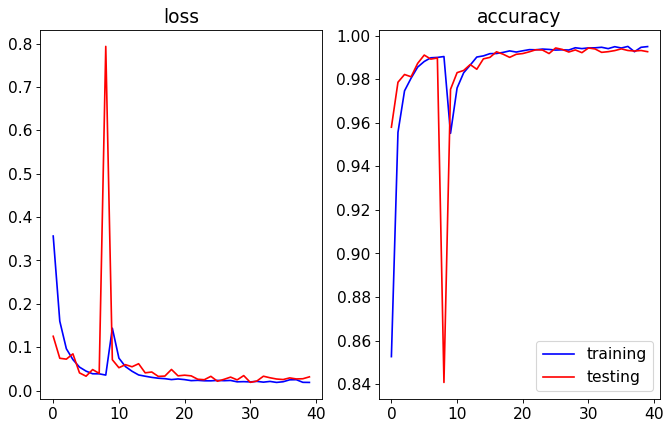

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


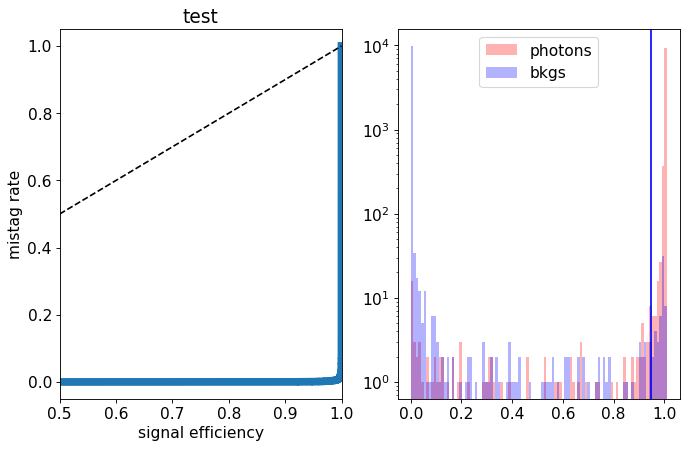

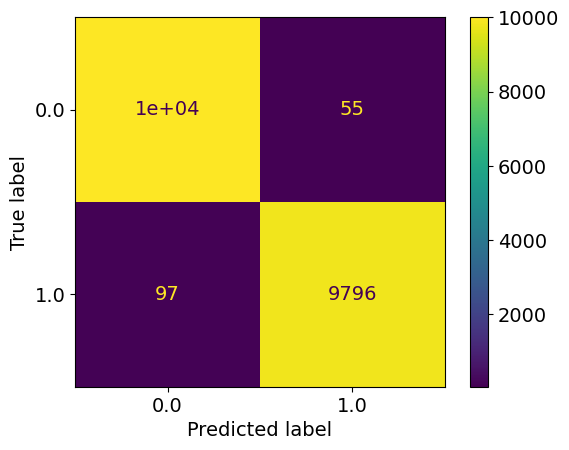

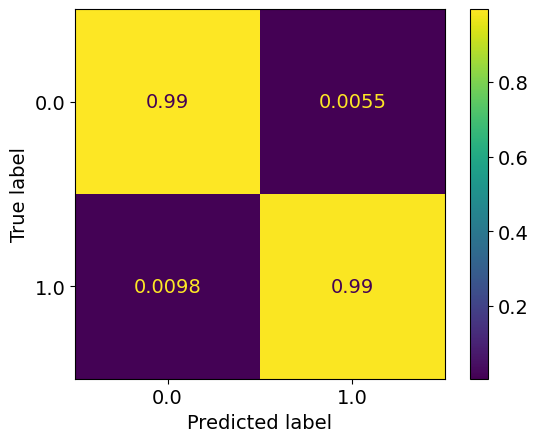

epoch: 40
Learning rate: 9.562935188971167e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.01711703383766893
train acc: 0.9951885


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.028116337982389855
test acc: 0.993184
epoch: 41
Learning rate: 7.796170675200053e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01787600116026692
train acc: 0.9953513


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.029299591866968993
test acc: 0.9929334
epoch: 42
Learning rate: 6.195965394678333e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.01794432724457679
train acc: 0.9951885


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.028639895427177715
test acc: 0.99303365
epoch: 43
Learning rate: 4.768634626584012e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.017737517241082752
train acc: 0.995414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.027606257360757273
test acc: 0.99343455
epoch: 44
Learning rate: 3.519811393373329e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.01645887225787368
train acc: 0.9955142


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.02543146604233805
test acc: 0.99358493
epoch: 45
Learning rate: 2.4544242298147113e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.016427481777873933
train acc: 0.99577737


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.027074098521980512
test acc: 0.9934847
epoch: 46
Learning rate: 1.5766777323136307e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.016545018174254626
train acc: 0.99547666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.32it/s]


test loss: 0.025349406148854864
test acc: 0.9934847
epoch: 47
Learning rate: 8.900359652914913e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.01628290773577877
train acc: 0.99561447


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.93it/s]


test loss: 0.026071760139208946
test acc: 0.9935348
epoch: 48
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.017270083013744313
train acc: 0.99547666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.027541278560152826
test acc: 0.9935348
epoch: 49
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.01750080198494356
train acc: 0.9953513


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.026063562843345982
test acc: 0.99363506


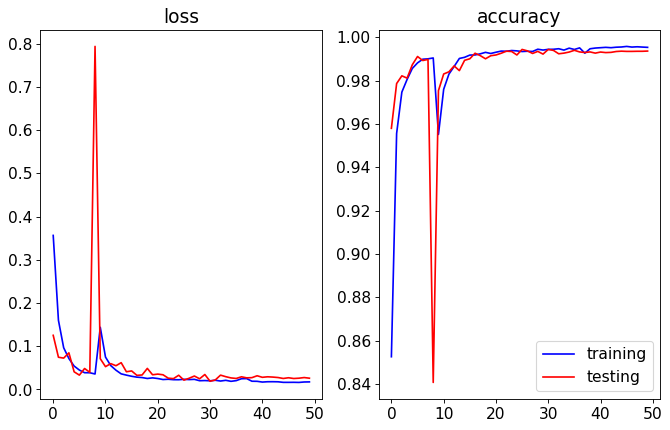

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.14it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


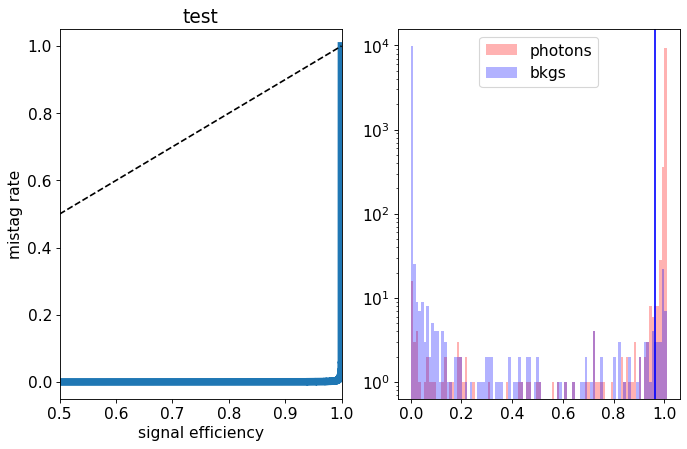

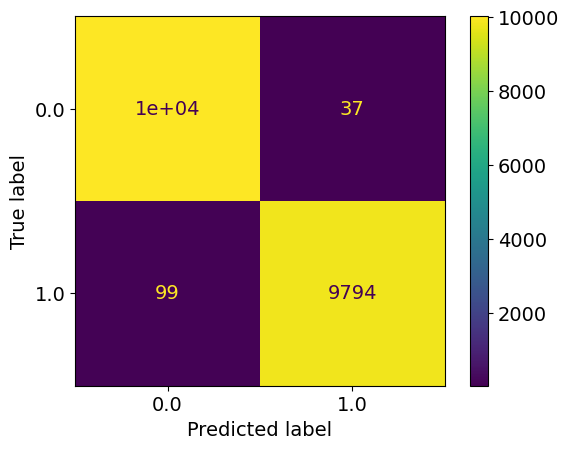

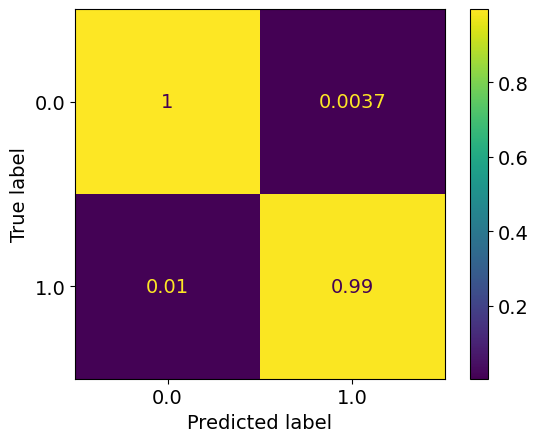

epoch: 50
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.026333483704018282
train acc: 0.99239427


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.19it/s]


test loss: 0.02755890944835675
test acc: 0.9930838
epoch: 51
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.022342887554585293
train acc: 0.9936723


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.19it/s]


test loss: 0.048144394363643025
test acc: 0.9898261
epoch: 52
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.02584352389841563
train acc: 0.992695


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.97it/s]


test loss: 0.021252100739408943
test acc: 0.9933845
epoch: 53
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.36it/s]


train loss: 0.022829074471660736
train acc: 0.99344677


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.038446181193541956
test acc: 0.9907783
epoch: 54
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.02194965369443395
train acc: 0.99372244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.026137014768798563
test acc: 0.9938355
epoch: 55
Learning rate: 0.0009756006540427169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.02287636800154821
train acc: 0.9936723


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.33it/s]


test loss: 0.04535205626641126
test acc: 0.9912294
epoch: 56
Learning rate: 0.0009649744976107358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.022132765921761253
train acc: 0.99327135


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.04657053670791142
test acc: 0.98892397
epoch: 57
Learning rate: 0.0009525132992633266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.023297671052069514
train acc: 0.9934844


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.04875368297421921
test acc: 0.9907783
epoch: 58
Learning rate: 0.0009382662376573867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.020311306102362935
train acc: 0.99434894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.027197747340644982
test acc: 0.99388564
epoch: 59
Learning rate: 0.0009222895394362114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.02096337395800111
train acc: 0.99403566


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.53it/s]


test loss: 0.028896523955849903
test acc: 0.99273294


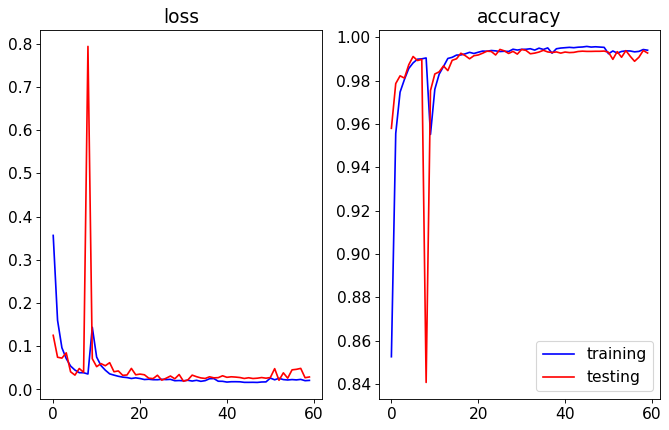

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


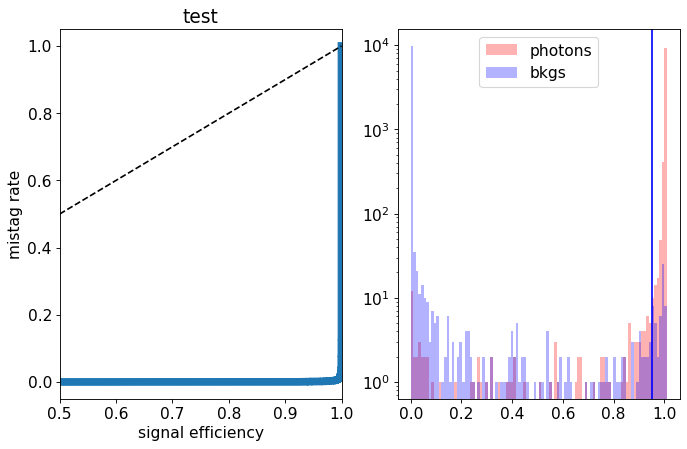

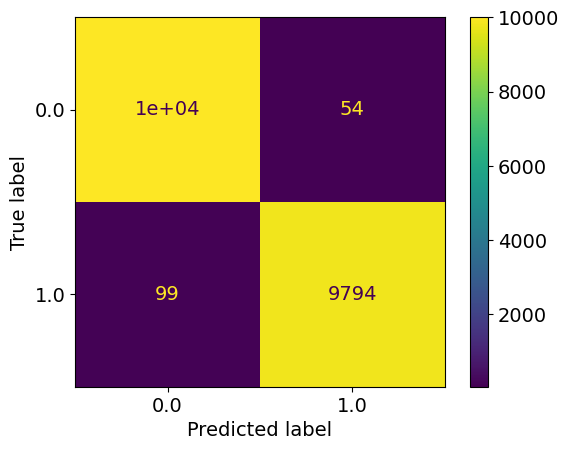

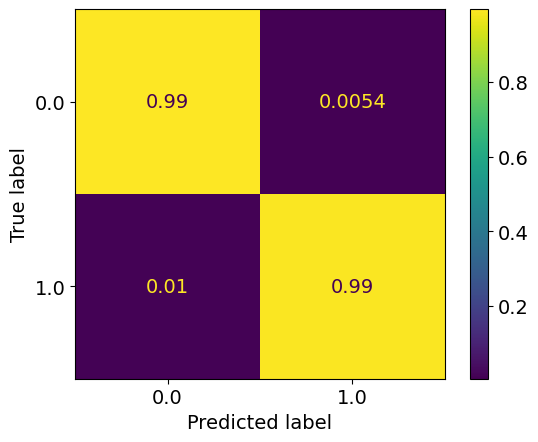

epoch: 60
Learning rate: 0.0009046462573286205


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.020838612500741493
train acc: 0.9938352


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.02644615087603383
test acc: 0.9920313
epoch: 61
Learning rate: 0.0008854060213086439


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.02029997317134333
train acc: 0.9942362


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.03500321622499648
test acc: 0.9921816
epoch: 62
Learning rate: 0.0008646447637978247


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.021292929888577825
train acc: 0.993973


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.027307373279815212
test acc: 0.9930838
epoch: 63
Learning rate: 0.0008424444199946417


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.02026442408738936
train acc: 0.9944241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.38it/s]


test loss: 0.03927467329263249
test acc: 0.99112916
epoch: 64
Learning rate: 0.0008188926045137139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.02134466969834424
train acc: 0.99393547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.027696213096051532
test acc: 0.991931
epoch: 65
Learning rate: 0.0007940822656109432


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.02035294538850326
train acc: 0.9937851


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.03186795889290378
test acc: 0.9924823
epoch: 66
Learning rate: 0.0007681113183592136


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.022318015340715647
train acc: 0.99377257


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.02832643035799265
test acc: 0.99303365
epoch: 67
Learning rate: 0.00074108225822233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.018489940253124615
train acc: 0.9947875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.045464657159755006
test acc: 0.990628
epoch: 68
Learning rate: 0.0007131017565522502


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.02066725330799123
train acc: 0.993948


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.031959115301587564
test acc: 0.9923821
epoch: 69
Learning rate: 0.0006842802396059904


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.021319277977237282
train acc: 0.99477494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.05081775439355303
test acc: 0.9888237


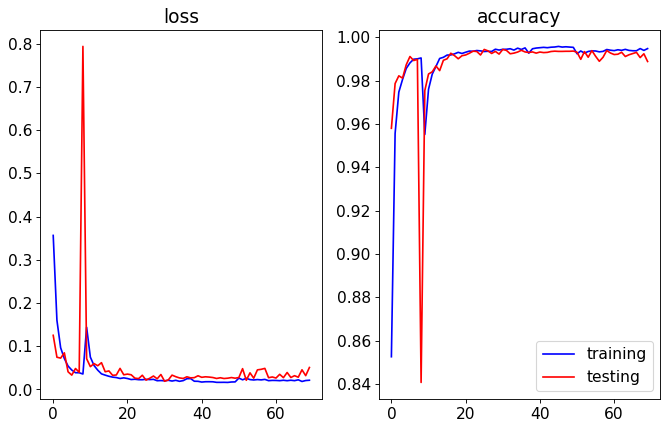

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.51it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


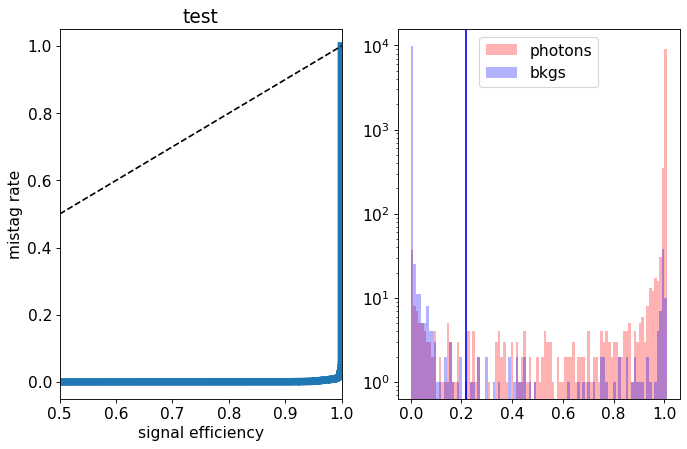

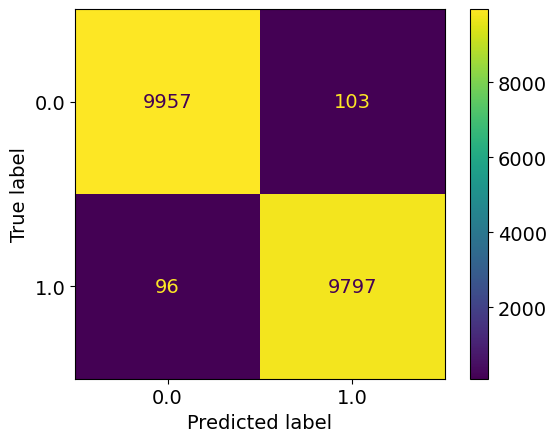

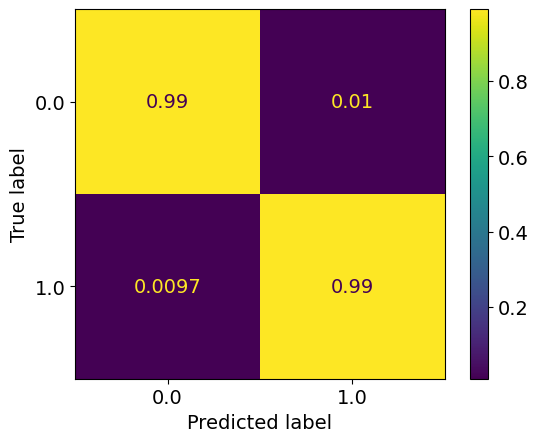

epoch: 70
Learning rate: 0.0006547314527436389


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.041436308654331004
train acc: 0.98663044


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.03344287829446223
test acc: 0.9903273
epoch: 71
Learning rate: 0.0006245720115273849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.022127467873795114
train acc: 0.9932964


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.029911087866982117
test acc: 0.99283314
epoch: 72
Learning rate: 0.000593920941493171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.01988080731434956
train acc: 0.99447423


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.023046417315901423
test acc: 0.993184
epoch: 73
Learning rate: 0.00056289920841128


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.019753961400789166
train acc: 0.9942487


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.028464379271848455
test acc: 0.99303365
epoch: 74
Learning rate: 0.0005316292408897048


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.019990430953703932
train acc: 0.9946246


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.03061054044348352
test acc: 0.9926828
epoch: 75
Learning rate: 0.0005002344472043636


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.018492477131510542
train acc: 0.99485016


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.03078381689813207
test acc: 0.9920814
epoch: 76
Learning rate: 0.00046883872826301544


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.017954180834464355
train acc: 0.9949003


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.02381083180936163
test acc: 0.99358493
epoch: 77
Learning rate: 0.0004375659886249823


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01844426373683895
train acc: 0.9944116


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.03578928272541174
test acc: 0.9904776
epoch: 78
Learning rate: 0.0004065396475064596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.017539215204653454
train acc: 0.9950506


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.48it/s]


test loss: 0.029668988796937114
test acc: 0.9926828
epoch: 79
Learning rate: 0.0003758821517012555


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.01686514337500997
train acc: 0.99527615


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.51it/s]


test loss: 0.02312594943214208
test acc: 0.9945873
new best acc: 0.9945873


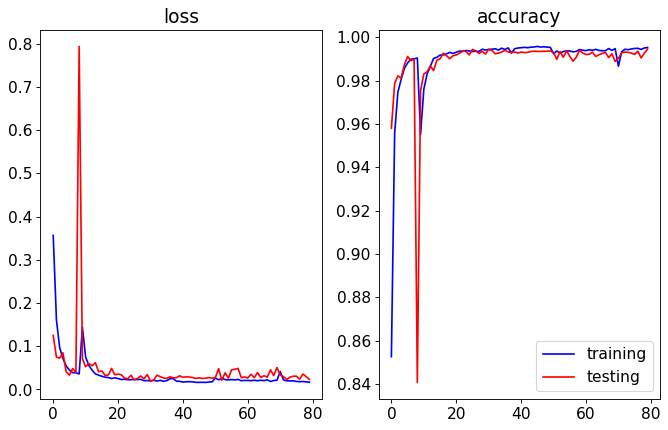

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.73it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


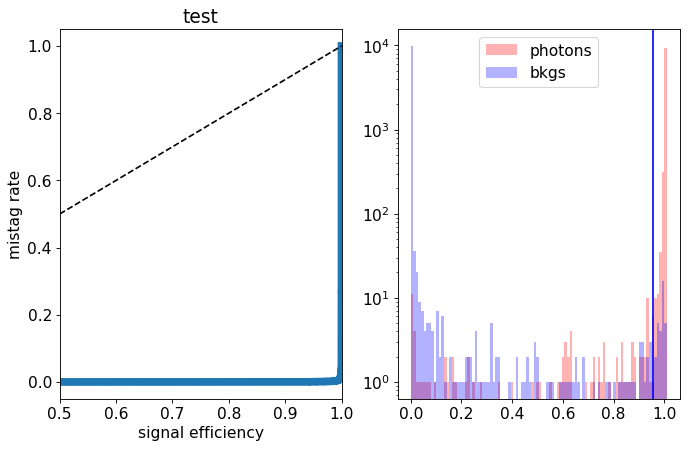

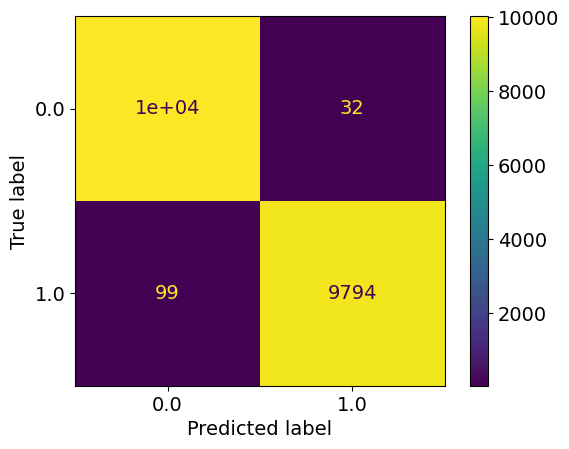

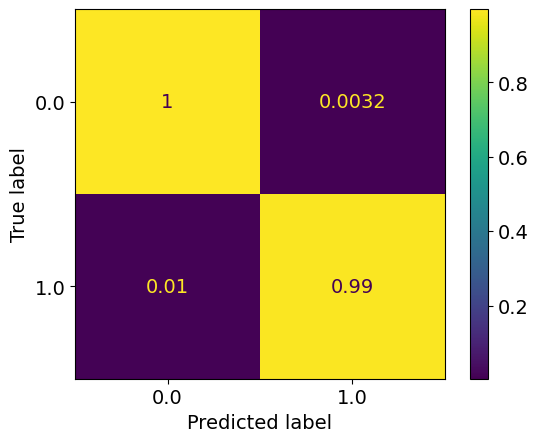

epoch: 80
Learning rate: 0.00034571449233923536


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.01569441650856639
train acc: 0.99558944


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.33it/s]


test loss: 0.04034200246336267
test acc: 0.9921816
epoch: 81
Learning rate: 0.00031615572738960855


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.016256918524212027
train acc: 0.995414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.031447734563912755
test acc: 0.9929835
epoch: 82
Learning rate: 0.00028732251179351616


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.014966865908311082
train acc: 0.99558944


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.02879385357065236
test acc: 0.99388564
epoch: 83
Learning rate: 0.00025932863708027284


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.016568932108886873
train acc: 0.99515086


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.02984166215516298
test acc: 0.99358493
epoch: 84
Learning rate: 0.00023228458228418658


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.01540477199952549
train acc: 0.99592775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.027139156678458676
test acc: 0.993184
epoch: 85
Learning rate: 0.00020629707793428436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.017451463833645875
train acc: 0.9955393


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.02636773478201683
test acc: 0.99288327
epoch: 86
Learning rate: 0.00018146868483767388


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.020390284369704435
train acc: 0.9941735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.026089427088770795
test acc: 0.9932341
epoch: 87
Learning rate: 0.00015789738931889374


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.01607282108926117
train acc: 0.9955017


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.018278552465798223
test acc: 0.99448705
epoch: 88
Learning rate: 0.00013567621651265567


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.014697672279704529
train acc: 0.9956521


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.51it/s]


test loss: 0.02499335794709623
test acc: 0.99373525
epoch: 89
Learning rate: 0.00011489286323613779


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.45it/s]


train loss: 0.014144652476186738
train acc: 0.9961658


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.026631015057586516
test acc: 0.99393576


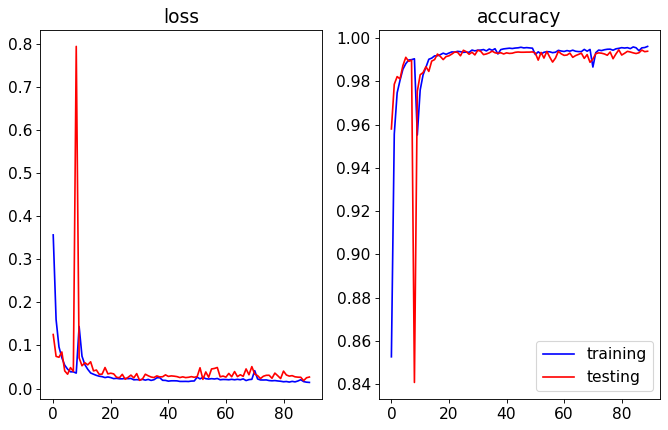

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


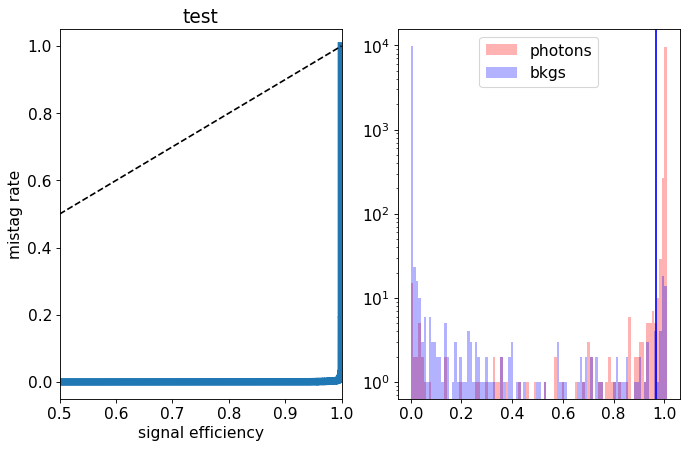

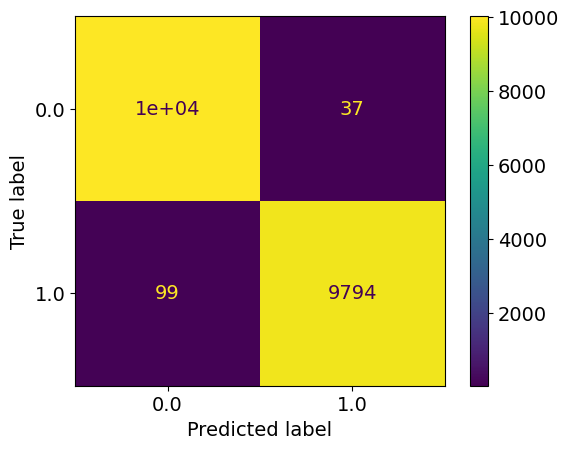

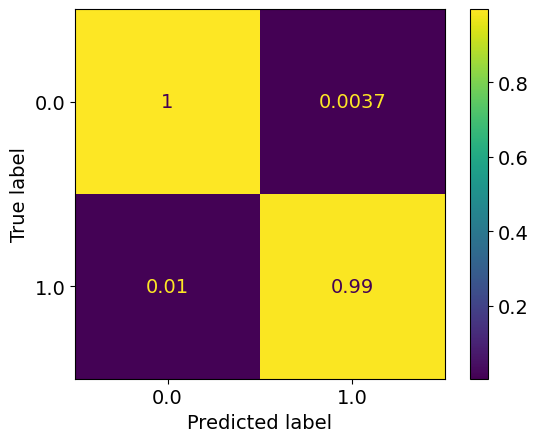

epoch: 90
Learning rate: 9.562935188971167e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.015061565646687793
train acc: 0.9960029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.025446252359816915
test acc: 0.99463737
new best acc: 0.99463737
epoch: 91
Learning rate: 7.796170675200053e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.0140978250106115
train acc: 0.9960154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.029981600202839163
test acc: 0.99363506
epoch: 92
Learning rate: 6.195965394678333e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.014705865376004452
train acc: 0.99576485


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.02763193964561009
test acc: 0.99358493
epoch: 93
Learning rate: 4.768634626584012e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.013982212032715324
train acc: 0.99606556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.02967938838992268
test acc: 0.9939859
epoch: 94
Learning rate: 3.519811393373329e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.013711835484322527
train acc: 0.99605304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.025468712843790212
test acc: 0.9939859
epoch: 95
Learning rate: 2.4544242298147113e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.014528766755371288
train acc: 0.99590266


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.34it/s]


test loss: 0.02881211115677348
test acc: 0.9937854
epoch: 96
Learning rate: 1.5766777323136307e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.01396695768676521
train acc: 0.9961407


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.026482599184793586
test acc: 0.9941362
epoch: 97
Learning rate: 8.900359652914913e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01432189459817335
train acc: 0.99605304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.027083379353451377
test acc: 0.99393576
epoch: 98
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.014403212046979762
train acc: 0.9959904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.025700426993834673
test acc: 0.99388564
epoch: 99
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.014380733572891843
train acc: 0.9960154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.02562392247851034
test acc: 0.99393576


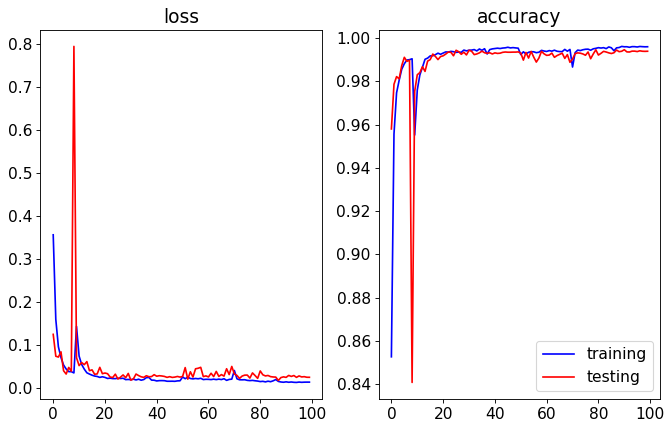

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


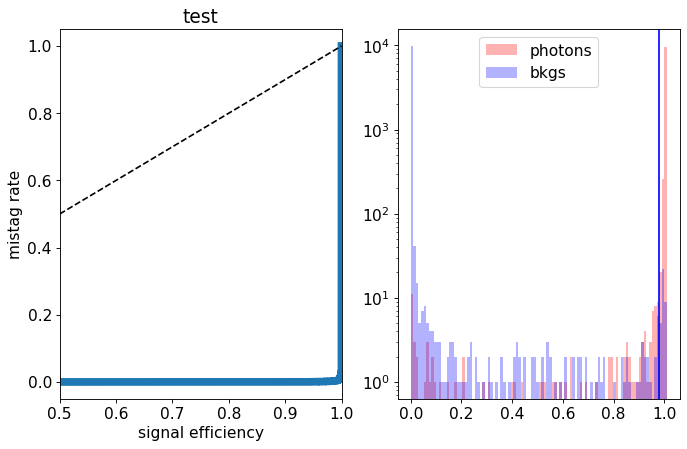

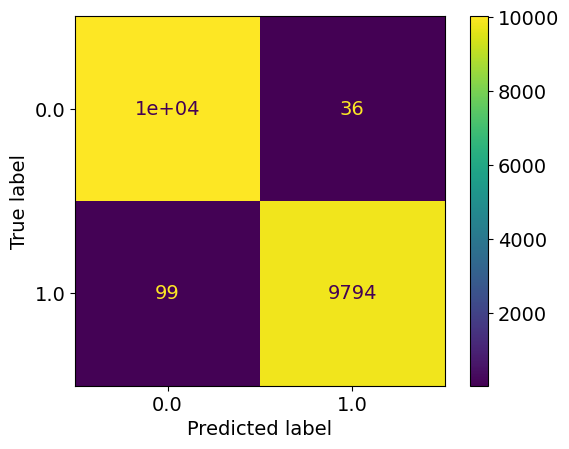

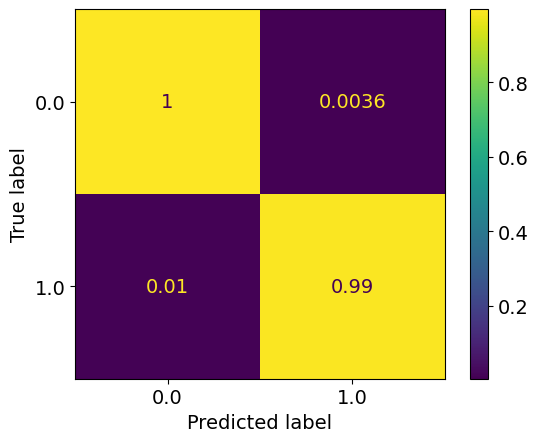

epoch: 100
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.02097952038633281
train acc: 0.9940733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.51it/s]


test loss: 0.031742874056148784
test acc: 0.99137974
epoch: 101
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.02154076055902901
train acc: 0.9937475


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.51it/s]


test loss: 0.03615748739856131
test acc: 0.9895254
epoch: 102
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.36it/s]


train loss: 0.019219410058402858
train acc: 0.99448675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.037827093921163506
test acc: 0.99148
epoch: 103
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.019776021589962906
train acc: 0.99448675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.04048974473741563
test acc: 0.9918809
epoch: 104
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.01919221406466538
train acc: 0.9945369


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.031649234784708824
test acc: 0.9923821
epoch: 105
Learning rate: 0.0009756006540427169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01739239680959579
train acc: 0.9949253


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.03240206806153497
test acc: 0.9937854
epoch: 106
Learning rate: 0.0009649744976107358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.019355912674654974
train acc: 0.9942988


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.018373274929164088
test acc: 0.994888
new best acc: 0.994888
epoch: 107
Learning rate: 0.0009525132992633266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.018235386312772422
train acc: 0.99468726


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.022769068425986916
test acc: 0.9945372
epoch: 108
Learning rate: 0.0009382662376573867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.017536431870039178
train acc: 0.9948627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.44it/s]


test loss: 0.025827468585168177
test acc: 0.99423647
epoch: 109
Learning rate: 0.0009222895394362114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.018332587989436377
train acc: 0.99467474


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.025129723683194778
test acc: 0.99393576


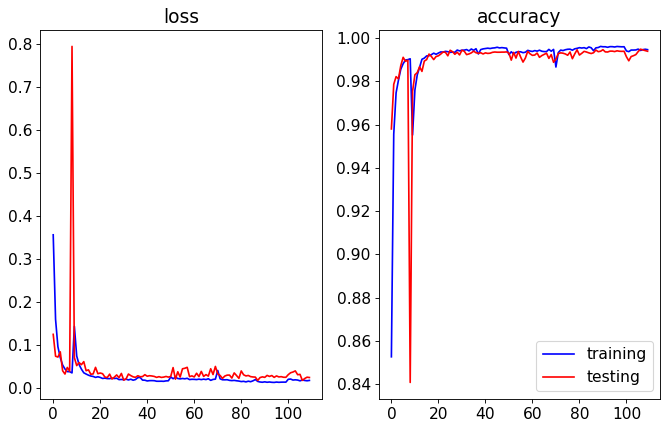

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


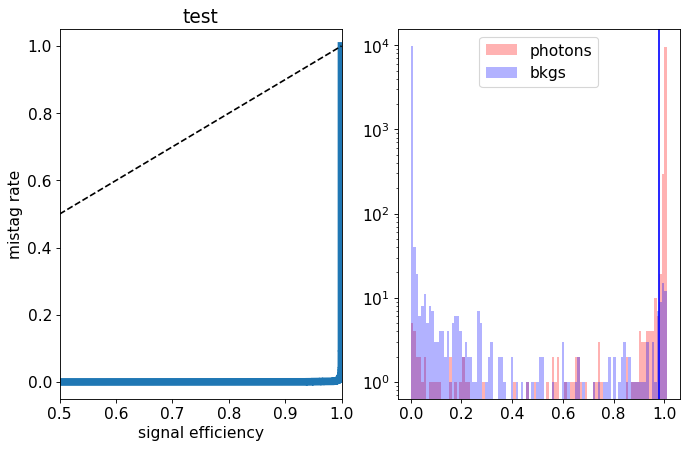

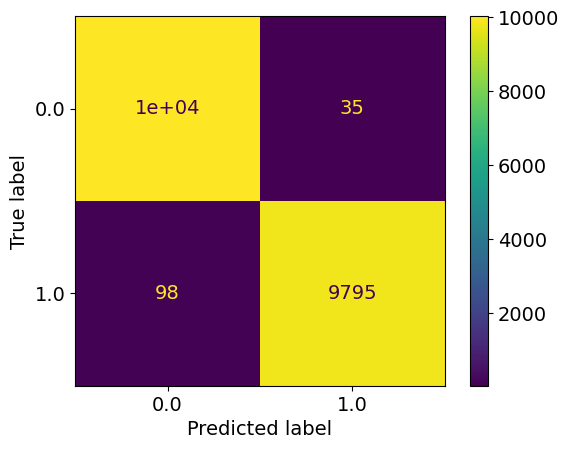

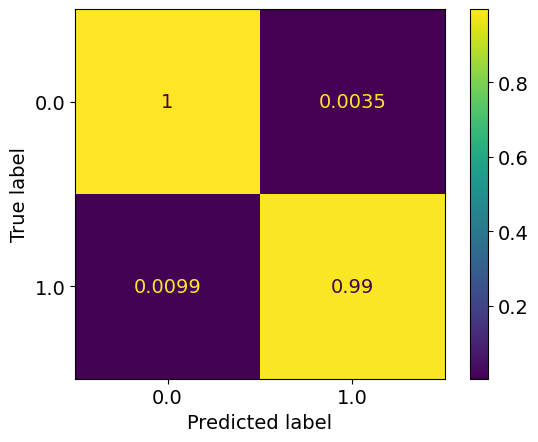

epoch: 110
Learning rate: 0.0009046462573286205


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.01888361237569601
train acc: 0.9943991


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.023313039694638812
test acc: 0.9920313
epoch: 111
Learning rate: 0.0008854060213086439


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.01714041536159591
train acc: 0.99501306


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.027459138059331215
test acc: 0.99288327
epoch: 112
Learning rate: 0.0008646447637978247


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.018461303670765525
train acc: 0.9947123


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.64it/s]


test loss: 0.0664482197505148
test acc: 0.9886734
epoch: 113
Learning rate: 0.0008424444199946417


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.021645837377430175
train acc: 0.9941359


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.028865930143237004
test acc: 0.9936852
epoch: 114
Learning rate: 0.0008188926045137139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.019897781288140078
train acc: 0.99515086


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.0996733027345994
test acc: 0.9743397
epoch: 115
Learning rate: 0.0007940822656109432


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.45it/s]


train loss: 0.05091166591971988
train acc: 0.9824955


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.05885942052940235
test acc: 0.98596704
epoch: 116
Learning rate: 0.0007681113183592136


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.02330092588655039
train acc: 0.9925697


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.06029616542133119
test acc: 0.98742044
epoch: 117
Learning rate: 0.00074108225822233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.019769073058477492
train acc: 0.99406075


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.0396182255627697
test acc: 0.9917306
epoch: 118
Learning rate: 0.0007131017565522502


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01781988930679969
train acc: 0.9944492


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.03625307522837401
test acc: 0.992332
epoch: 119
Learning rate: 0.0006842802396059904


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.017869517499147787
train acc: 0.99512583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.05507263311130159
test acc: 0.9908786


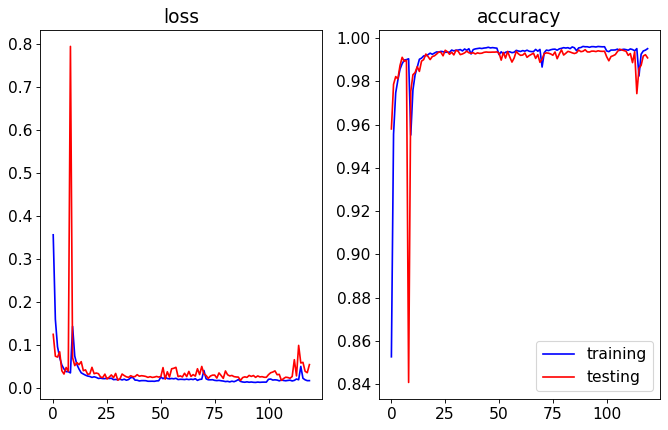

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


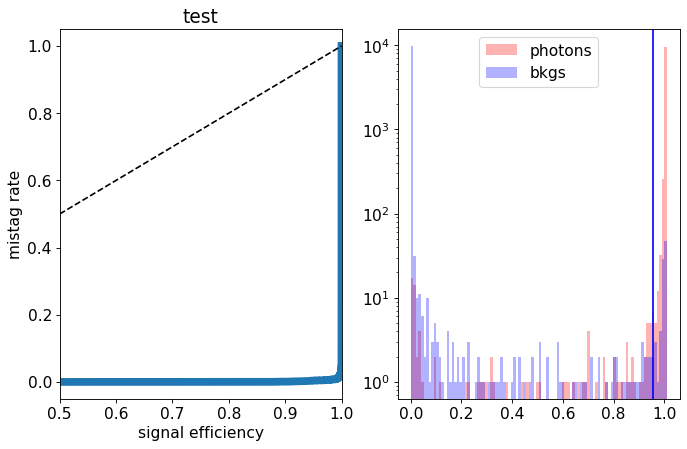

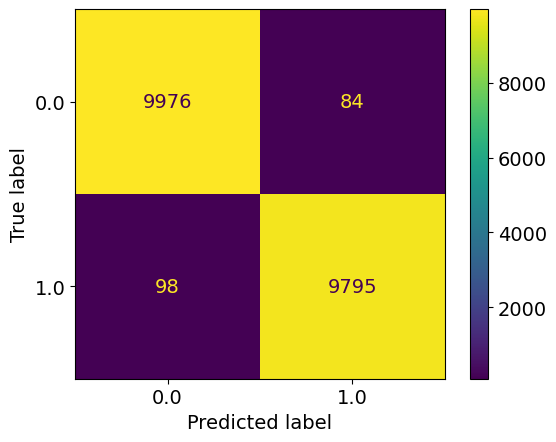

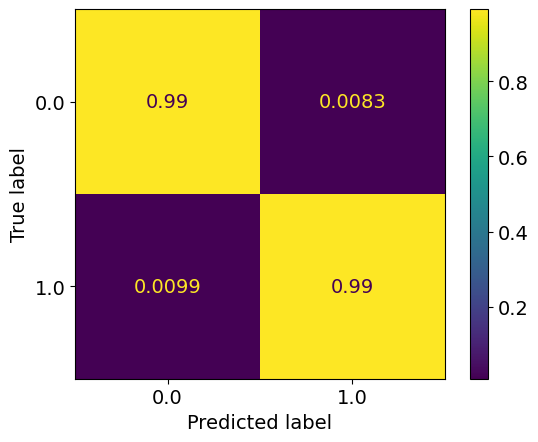

epoch: 120
Learning rate: 0.0006547314527436389


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.017259286805629423
train acc: 0.9949253


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.17it/s]


test loss: 0.04124817988999626
test acc: 0.99112916
epoch: 121
Learning rate: 0.0006245720115273849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.016600412125490717
train acc: 0.9953889


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.025030035429688936
test acc: 0.99423647
epoch: 122
Learning rate: 0.000593920941493171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01718629753074324
train acc: 0.99511325


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.049896877094665
test acc: 0.99052775
epoch: 123
Learning rate: 0.00056289920841128


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.016242684528871038
train acc: 0.99527615


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.026730282896417466
test acc: 0.9940861
epoch: 124
Learning rate: 0.0005316292408897048


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01616266429764844
train acc: 0.9951634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.0344012283911819
test acc: 0.9920814
epoch: 125
Learning rate: 0.0005002344472043636


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.016458528848285022
train acc: 0.99513835


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.42it/s]


test loss: 0.035571949426358676
test acc: 0.9912294
epoch: 126
Learning rate: 0.00046883872826301544


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.69it/s]


train loss: 0.014345118630879016
train acc: 0.99585253


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.03081745736348881
test acc: 0.993184
epoch: 127
Learning rate: 0.0004375659886249823


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01549072876579559
train acc: 0.99542654


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.030530777684522465
test acc: 0.99333435
epoch: 128
Learning rate: 0.0004065396475064596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.45it/s]


train loss: 0.01626111352433965
train acc: 0.9954892


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.024915042442872244
test acc: 0.99373525
epoch: 129
Learning rate: 0.000375882151701255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.015558338486033477
train acc: 0.9953513


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.031460112957146895
test acc: 0.99373525


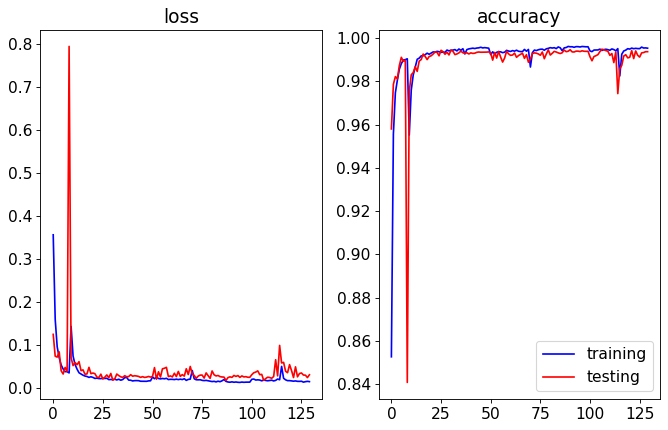

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


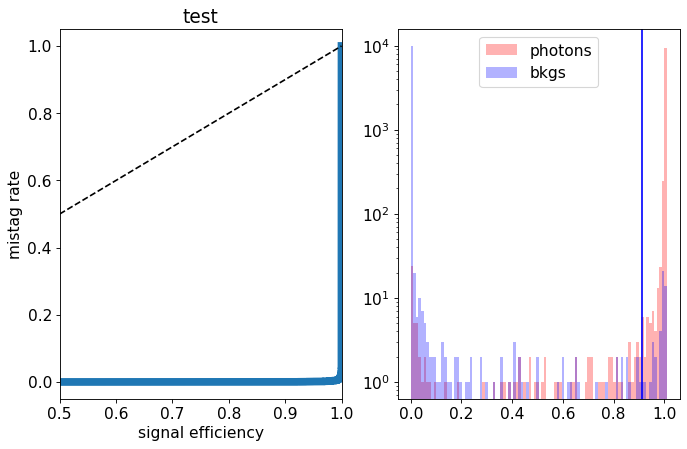

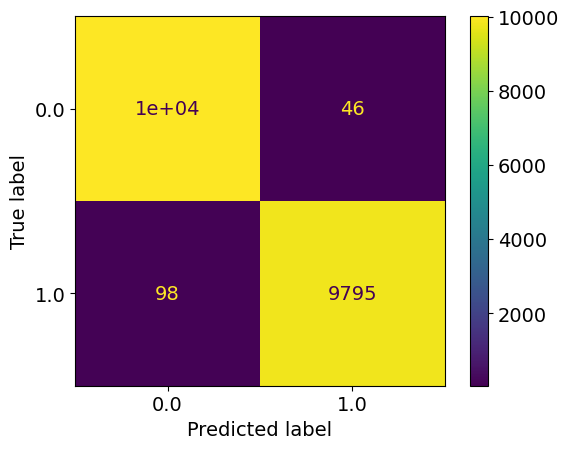

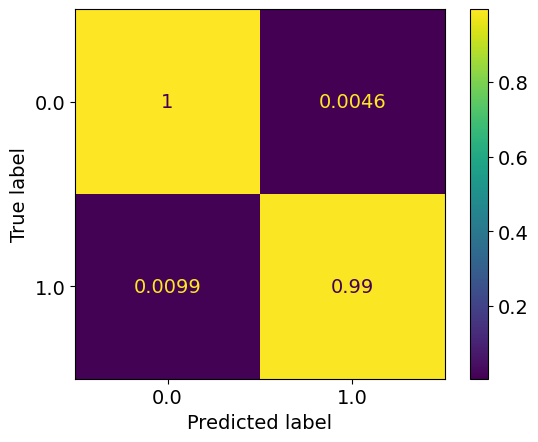

epoch: 130
Learning rate: 0.000345714492339235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.01461526976703676
train acc: 0.9957022


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.51it/s]


test loss: 0.021787716551711234
test acc: 0.9940861
epoch: 131
Learning rate: 0.0003161557273896083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.015117423310041872
train acc: 0.99557686


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.20it/s]


test loss: 0.030995164645205745
test acc: 0.9935348
epoch: 132
Learning rate: 0.0002873225117935158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.28it/s]


train loss: 0.01437495162173815
train acc: 0.9957899


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.02596237881216974
test acc: 0.99393576
epoch: 133
Learning rate: 0.0002593286370802722


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.013959359507069492
train acc: 0.9960029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.51it/s]


test loss: 0.02876168129938271
test acc: 0.9935348
epoch: 134
Learning rate: 0.0002322845822841862


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.013485352053487701
train acc: 0.99589014


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.02310849937630872
test acc: 0.9941362
epoch: 135
Learning rate: 0.00020629707793428403


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.014104986306222993
train acc: 0.9960781


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.03663604369606165
test acc: 0.9930838
epoch: 136
Learning rate: 0.00018146868483767353


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.013954684411092147
train acc: 0.99605304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.02085158007685095
test acc: 0.99448705
epoch: 137
Learning rate: 0.00015789738931889325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.014143320035064287
train acc: 0.99590266


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.025416086475803134
test acc: 0.9943868
epoch: 138
Learning rate: 0.00013567621651265532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.013304278577148825
train acc: 0.9960781


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.024583875578280318
test acc: 0.9943868
epoch: 139
Learning rate: 0.00011489286323613752


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.013122248595385855
train acc: 0.9961658


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.02252891061567318
test acc: 0.9941362


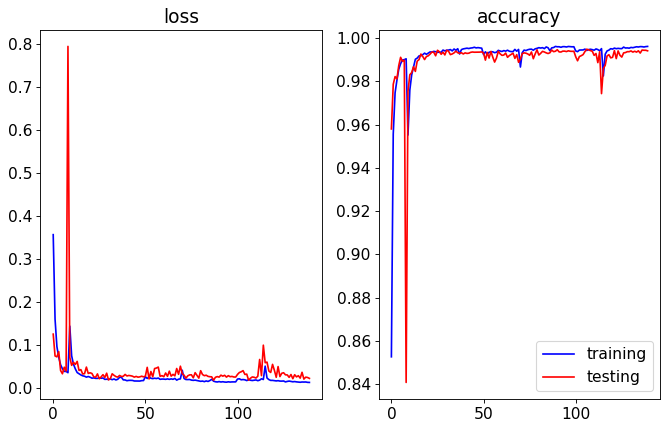

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.08it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


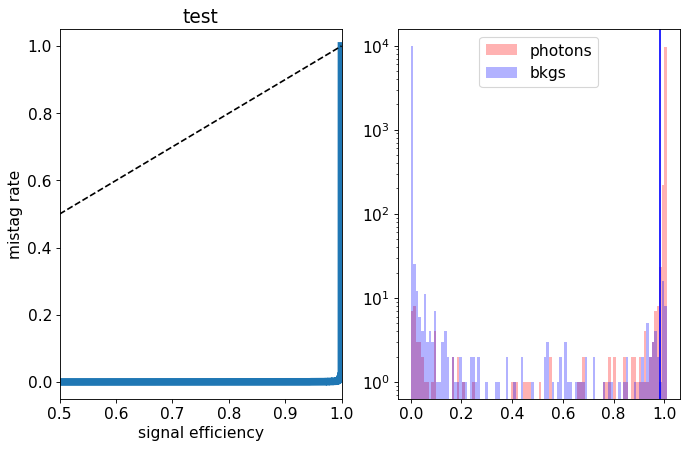

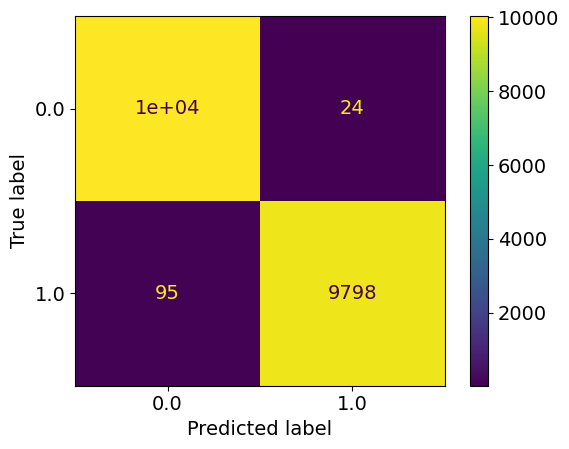

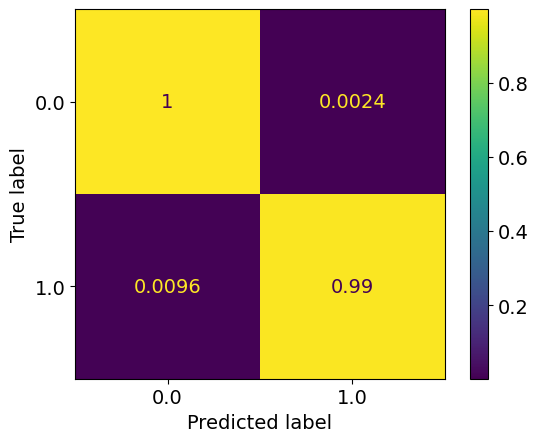

epoch: 140
Learning rate: 9.56293518897114e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.01435578956823438
train acc: 0.99622846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.02684036940199268
test acc: 0.99403596
epoch: 141
Learning rate: 7.79617067520002e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.013543986751864762
train acc: 0.9959904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.02466718906554674
test acc: 0.9938355
epoch: 142
Learning rate: 6.195965394678321e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.45it/s]


train loss: 0.012722664790700621
train acc: 0.9963788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.030546638464062092
test acc: 0.99358493
epoch: 143
Learning rate: 4.7686346265839844e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.014653200415699785
train acc: 0.99610317


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.030140826759366867
test acc: 0.99343455
epoch: 144
Learning rate: 3.5198113933733125e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.74it/s]


train loss: 0.014305477902821419
train acc: 0.99575233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.52it/s]


test loss: 0.029749544981100103
test acc: 0.9932341
epoch: 145
Learning rate: 2.4544242298147e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.70it/s]


train loss: 0.012768055547338062
train acc: 0.9961783


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.025544963838696918
test acc: 0.99373525
epoch: 146
Learning rate: 1.5766777323136195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.013439918057680297
train acc: 0.99622846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.02647409666165271
test acc: 0.99393576
epoch: 147
Learning rate: 8.900359652914802e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.01380194067336452
train acc: 0.9963287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.02651344084434266
test acc: 0.99373525
epoch: 148
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.012606447227229712
train acc: 0.9964039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.02712480375981506
test acc: 0.99373525
epoch: 149
Learning rate: 1.0014117046611704e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.012876429827571626
train acc: 0.9964039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.026270972358521678
test acc: 0.9937854


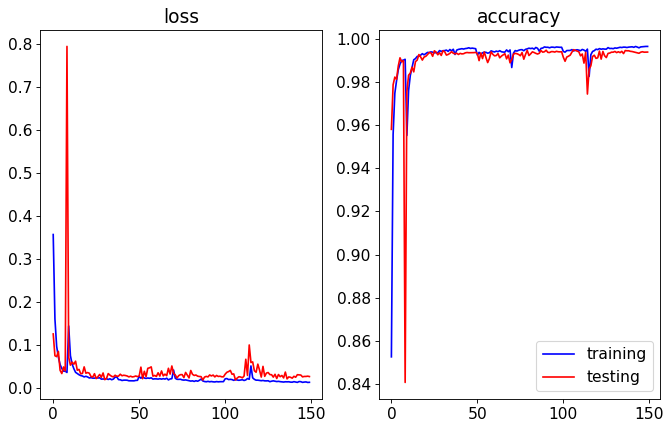

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


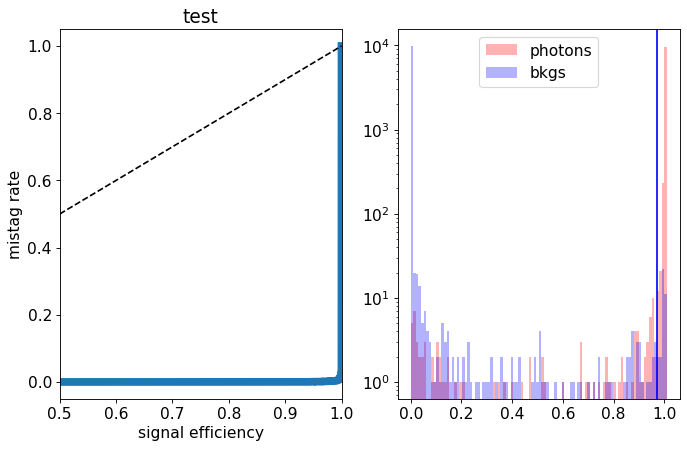

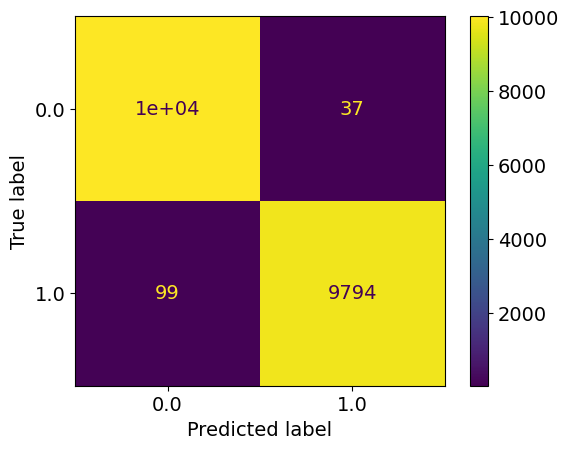

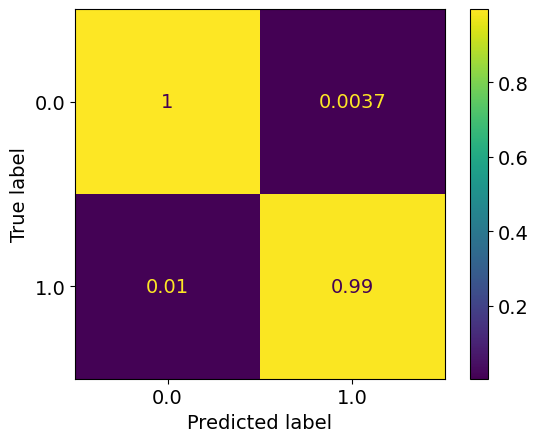

epoch: 150
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.018340796968941368
train acc: 0.99467474


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.32it/s]


test loss: 0.10114709868588868
test acc: 0.984263
epoch: 151
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.27it/s]


train loss: 0.020365910683654304
train acc: 0.99419856


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.06739723872776855
test acc: 0.98581666
epoch: 152
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01865503347197325
train acc: 0.9944492


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.51it/s]


test loss: 0.03800898409420316
test acc: 0.99243224
epoch: 153
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.35it/s]


train loss: 0.016793090192455132
train acc: 0.9947875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.03364721421316704
test acc: 0.99243224
epoch: 154
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.016801166397679264
train acc: 0.99510074


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.57it/s]


test loss: 0.07442111067254753
test acc: 0.988072
epoch: 155
Learning rate: 0.0009756006540427168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.01815408147148677
train acc: 0.99497545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.021020800238201284
test acc: 0.9941362
epoch: 156
Learning rate: 0.0009649744976107356


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.02059245903006713
train acc: 0.9940733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.02478854126050411
test acc: 0.9933845
epoch: 157
Learning rate: 0.0009525132992633265


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.0182723472859169
train acc: 0.9950506


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.63it/s]


test loss: 0.025917775497552666
test acc: 0.9926828
epoch: 158
Learning rate: 0.0009382662376573865


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.015426334103138479
train acc: 0.99540144


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.03957276783801396
test acc: 0.9915301
epoch: 159
Learning rate: 0.0009222895394362112


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.018739528895712825
train acc: 0.99447423


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.058880577576072776
test acc: 0.9897258


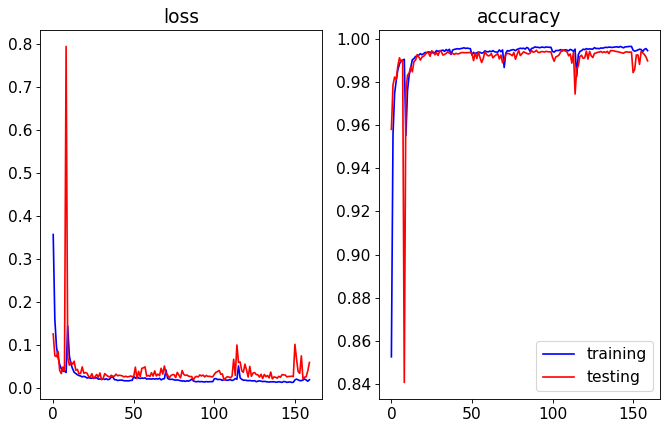

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.35it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


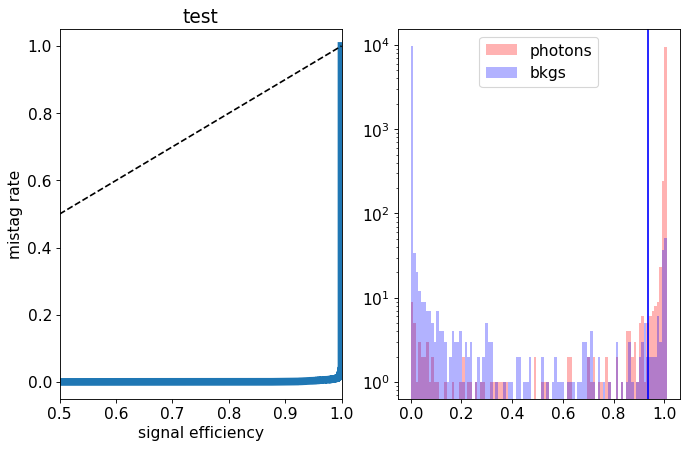

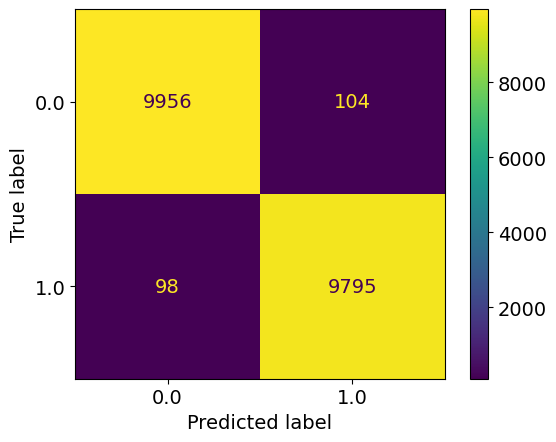

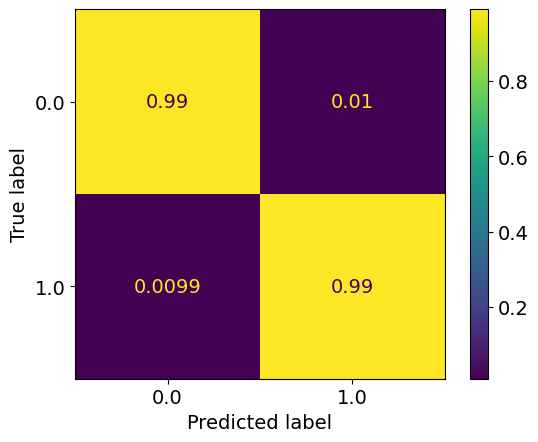

epoch: 160
Learning rate: 0.0009046462573286203


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.018184109722023462
train acc: 0.99497545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.02434927537379896
test acc: 0.9929835
epoch: 161
Learning rate: 0.0008854060213086437


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.015419481135383526
train acc: 0.99512583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.43it/s]


test loss: 0.03554472162881318
test acc: 0.99228185
epoch: 162
Learning rate: 0.0008646447637978243


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.016431763439800646
train acc: 0.9953388


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.021471715525395292
test acc: 0.99393576
epoch: 163
Learning rate: 0.0008424444199946415


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01833611930227046
train acc: 0.99482507


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.02641460226753706
test acc: 0.9939859
epoch: 164
Learning rate: 0.0008188926045137135


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.014816419636733386
train acc: 0.99556434


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.02308343755601741
test acc: 0.9943868
epoch: 165
Learning rate: 0.0007940822656109428


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.015808454201746893
train acc: 0.995201


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.020184827120615142
test acc: 0.99393576
epoch: 166
Learning rate: 0.0007681113183592132


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.45it/s]


train loss: 0.01667680377453399
train acc: 0.9952386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.015597592977642575
test acc: 0.99503833
new best acc: 0.99503833
epoch: 167
Learning rate: 0.0007410822582223297


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.020819134780778306
train acc: 0.99403566


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.57it/s]


test loss: 0.0325365875272409
test acc: 0.9929835
epoch: 168
Learning rate: 0.0007131017565522497


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.45it/s]


train loss: 0.01612312879601021
train acc: 0.9950256


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.029075291672009316
test acc: 0.9934847
epoch: 169
Learning rate: 0.00068428023960599


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.014843512856429304
train acc: 0.99540144


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.06306447379071922
test acc: 0.98992634


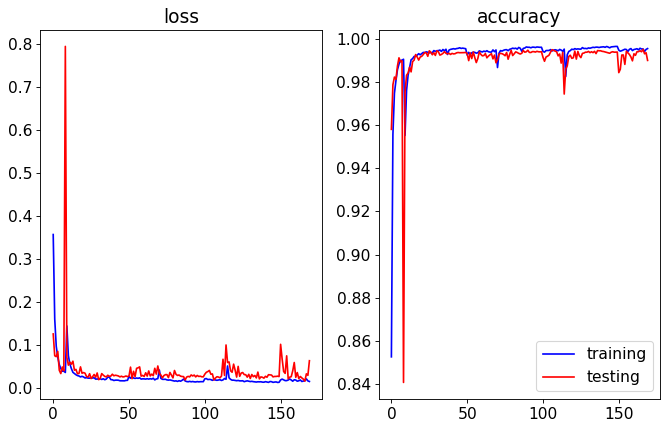

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


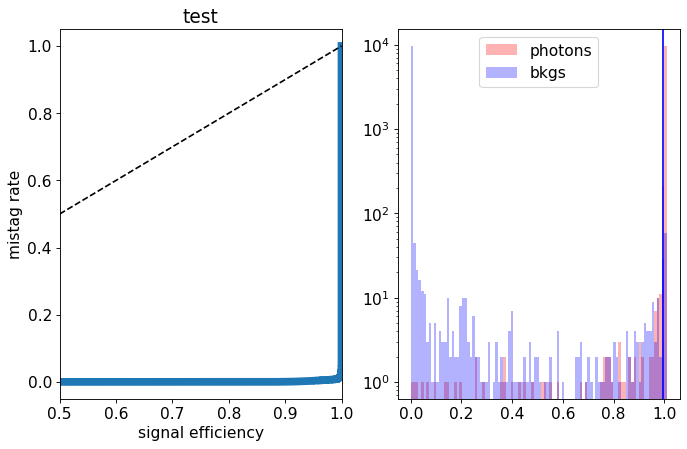

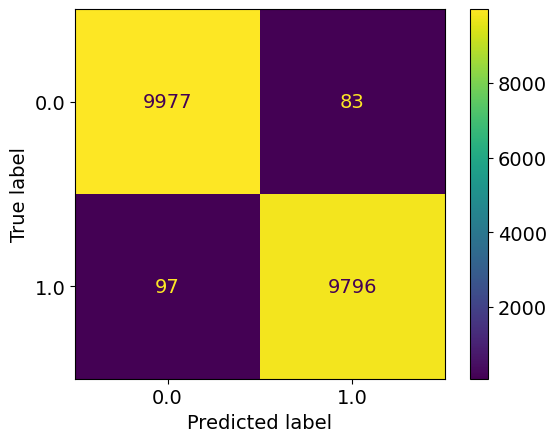

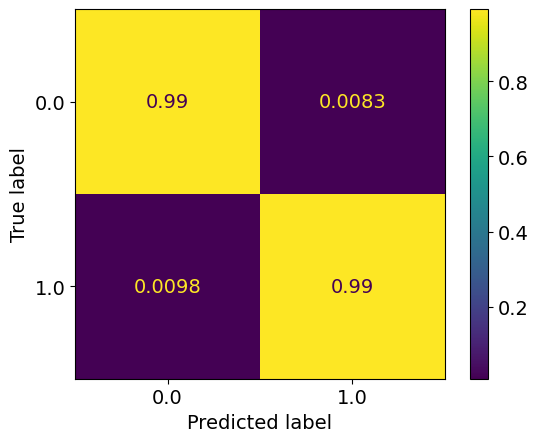

epoch: 170
Learning rate: 0.0006547314527436385


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.45it/s]


train loss: 0.016275592544463587
train acc: 0.99511325


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.022874143960721353
test acc: 0.9924823
epoch: 171
Learning rate: 0.0006245720115273845


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01594498730927721
train acc: 0.995414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.57it/s]


test loss: 0.025914082176955965
test acc: 0.9936852
epoch: 172
Learning rate: 0.0005939209414931706


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.014986651144233714
train acc: 0.9956646


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.03600515933323871
test acc: 0.9921816
epoch: 173
Learning rate: 0.0005628992084112796


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.014423917773972028
train acc: 0.99594027


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.57it/s]


test loss: 0.0174558903741212
test acc: 0.9945873
epoch: 174
Learning rate: 0.0005316292408897043


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.69it/s]


train loss: 0.01492219096950582
train acc: 0.9955268


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.48it/s]


test loss: 0.019370964782865485
test acc: 0.99423647
epoch: 175
Learning rate: 0.0005002344472043631


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.014788976750586793
train acc: 0.9957899


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.03461869271396769
test acc: 0.992332
epoch: 176
Learning rate: 0.000468838728263015


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.013796014436858099
train acc: 0.99585253


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.028872482108828777
test acc: 0.99278307
epoch: 177
Learning rate: 0.0004375659886249818


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.013840142621853346
train acc: 0.99577737


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.025903417400353217
test acc: 0.9943868
epoch: 178
Learning rate: 0.0004065396475064592


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01398215024756379
train acc: 0.99590266


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.01988764442777371
test acc: 0.9945372
epoch: 179
Learning rate: 0.000375882151701255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.013116470889063246
train acc: 0.99594027


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.023089610868791008
test acc: 0.9940861


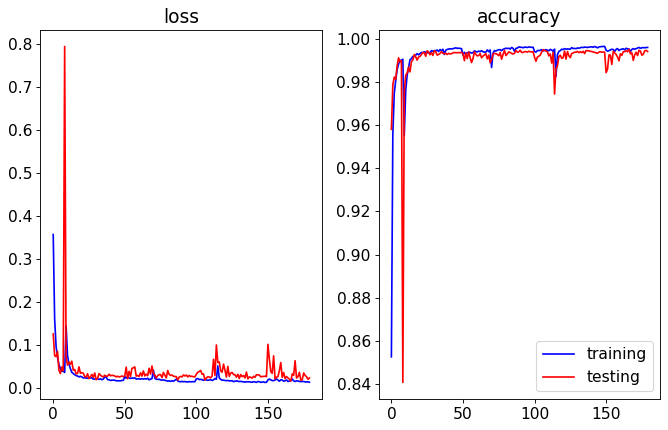

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


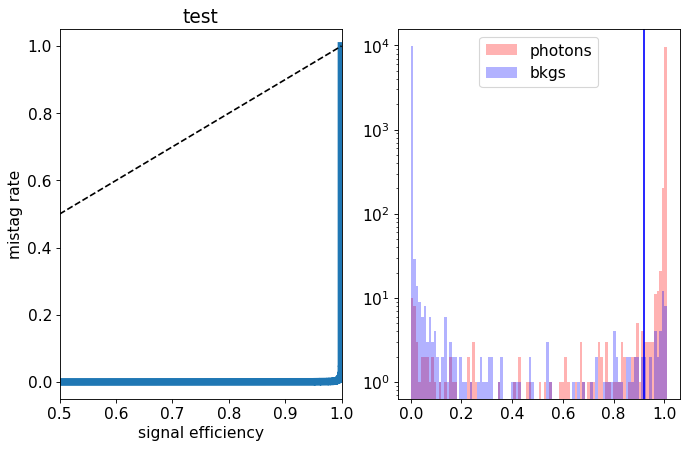

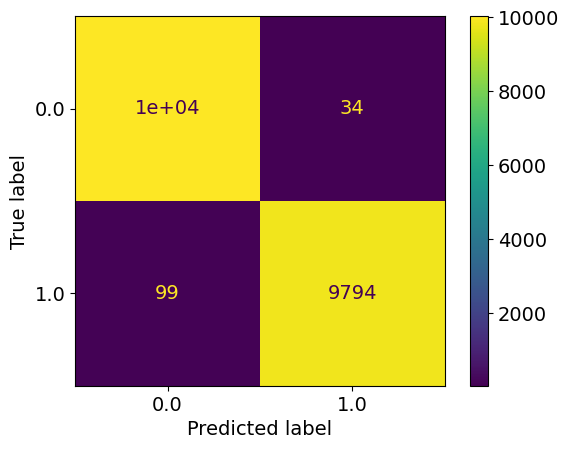

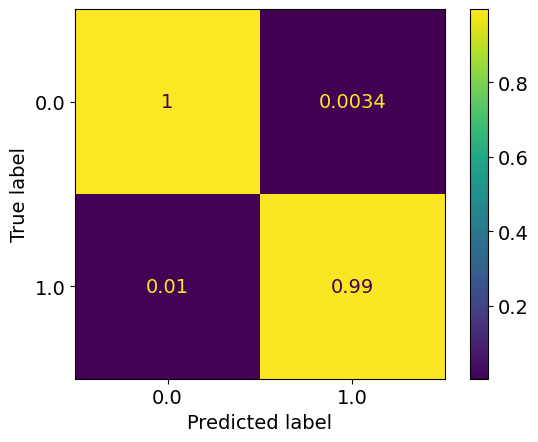

epoch: 180
Learning rate: 0.000345714492339235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01332243480684875
train acc: 0.99586505


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.017682315768016613
test acc: 0.99478775
epoch: 181
Learning rate: 0.0003161557273896083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.013449033293651535
train acc: 0.99589014


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.02660278996507473
test acc: 0.9940861
epoch: 182
Learning rate: 0.0002873225117935158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.013036833438368986
train acc: 0.9961157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.02178795435397393
test acc: 0.9944369
epoch: 183
Learning rate: 0.0002593286370802722


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.013583360627335287
train acc: 0.9959904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.01780961502535159
test acc: 0.99463737
epoch: 184
Learning rate: 0.0002322845822841862


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.012675429793394435
train acc: 0.9962535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.018399232933434713
test acc: 0.9945873
epoch: 185
Learning rate: 0.00020629707793428403


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.012183583405176387
train acc: 0.99652916


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.02345128627904855
test acc: 0.9937854
epoch: 186
Learning rate: 0.00018146868483767353


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.012989496158908447
train acc: 0.9961783


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.02217044592843569
test acc: 0.9941362
epoch: 187
Learning rate: 0.00015789738931889325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.01286068662039358
train acc: 0.99635375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.34it/s]


test loss: 0.021760705795125377
test acc: 0.99418634
epoch: 188
Learning rate: 0.00013567621651265532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.012711924747494397
train acc: 0.99621594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.02183065877076896
test acc: 0.9944369
epoch: 189
Learning rate: 0.00011489286323613752


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.014502099529256239
train acc: 0.9963287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.022335377997746143
test acc: 0.99423647


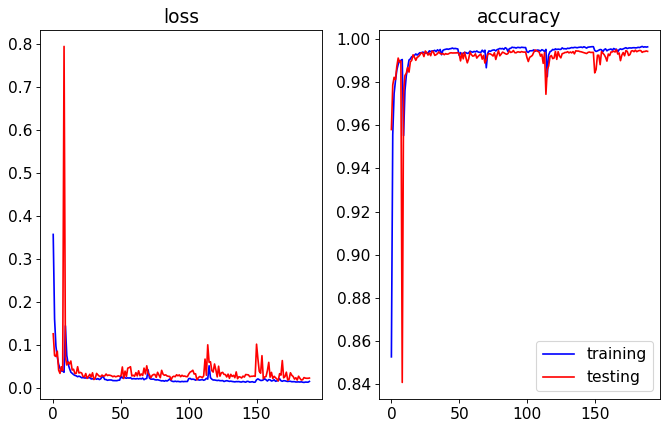

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.35it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


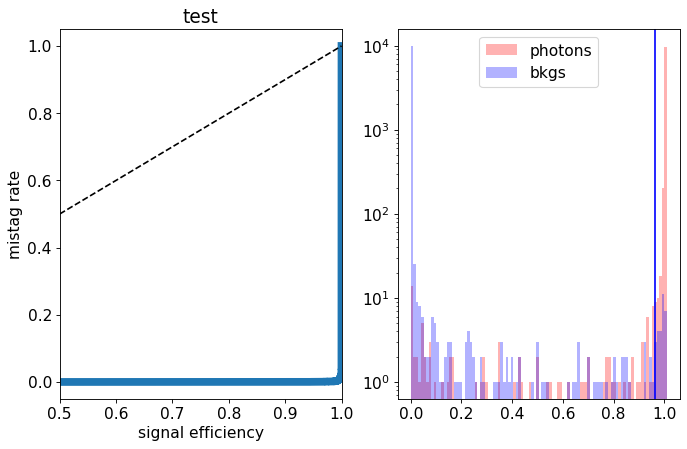

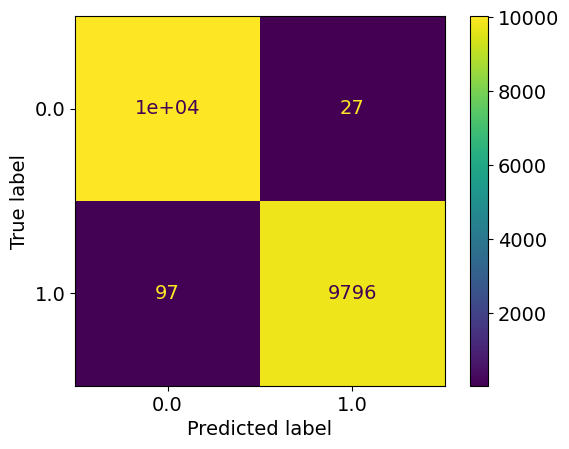

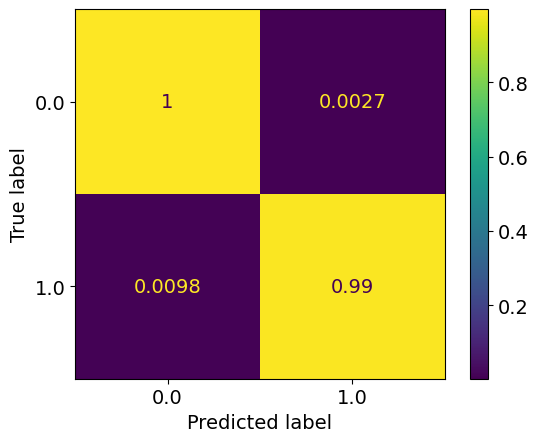

epoch: 190
Learning rate: 9.56293518897114e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.016132860479236982
train acc: 0.9955518


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.02023106358726235
test acc: 0.9942866
epoch: 191
Learning rate: 7.79617067520002e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01339225110827264
train acc: 0.9963036


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.45it/s]


test loss: 0.02328892072717495
test acc: 0.99388564
epoch: 192
Learning rate: 6.195965394678321e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.012359957580816056
train acc: 0.9963036


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.021350322010488632
test acc: 0.9942866
epoch: 193
Learning rate: 4.7686346265839844e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011926317066449407
train acc: 0.9964164


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.020591243863557738
test acc: 0.99433666
epoch: 194
Learning rate: 3.5198113933733125e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.011948336573029215
train acc: 0.996454


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.021501534207559684
test acc: 0.99433666
epoch: 195
Learning rate: 2.4544242298147e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.69it/s]


train loss: 0.011707860288354436
train acc: 0.99655426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.02217315197990769
test acc: 0.99423647
epoch: 196
Learning rate: 1.5766777323136195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.01206146354383942
train acc: 0.9964039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.020903997711951994
test acc: 0.9942866
epoch: 197
Learning rate: 8.900359652914802e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.012097300929523424
train acc: 0.9964415


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.021564901224337518
test acc: 0.99433666
epoch: 198
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.011383040480505946
train acc: 0.9966169


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.57it/s]


test loss: 0.02137712657922213
test acc: 0.9942866
epoch: 199
Learning rate: 1.0014117046611704e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.012036189584712214
train acc: 0.9967547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.47it/s]


test loss: 0.02141647561963028
test acc: 0.9942866


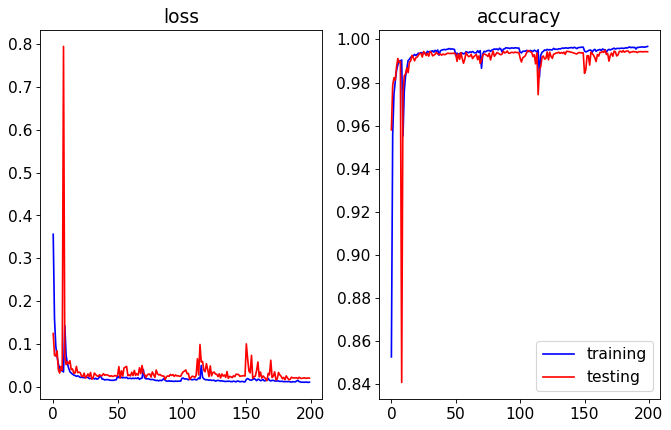

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


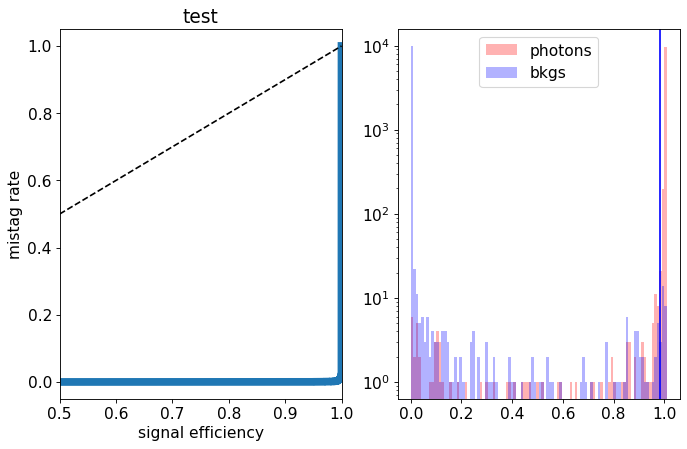

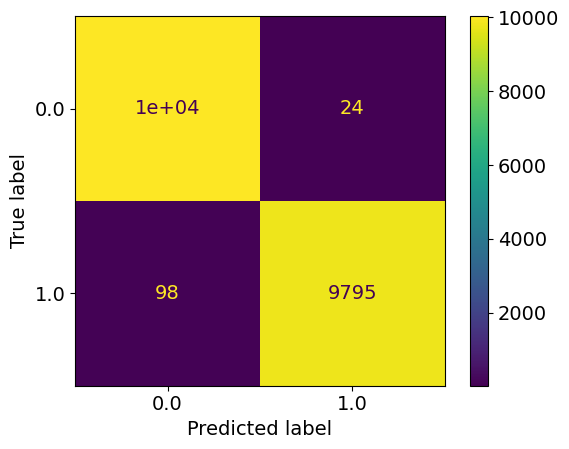

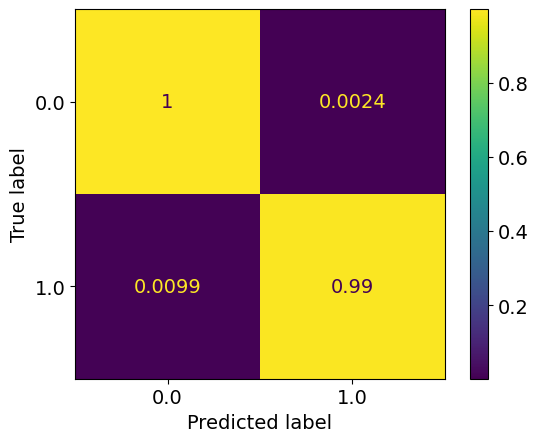

epoch: 200
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.45it/s]


train loss: 0.017587011023324658
train acc: 0.9949253


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.029393545978510863
test acc: 0.993184
epoch: 201
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.016895845217922173
train acc: 0.9948877


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.57it/s]


test loss: 0.032350999768823385
test acc: 0.992332
epoch: 202
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.45it/s]


train loss: 0.01656735697613487
train acc: 0.9953263


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.024004987803945207
test acc: 0.99283314
epoch: 203
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.015186881312905694
train acc: 0.9955518


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.57it/s]


test loss: 0.0192026941513177
test acc: 0.9949882
epoch: 204
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.015333688788379131
train acc: 0.99547666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.45it/s]


test loss: 0.03042828239952488
test acc: 0.99313384
epoch: 205
Learning rate: 0.0009756006540427168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.016223020489768945
train acc: 0.9953764


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.027531041681547377
test acc: 0.99363506
epoch: 206
Learning rate: 0.0009649744976107356


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.015253939090727536
train acc: 0.99563956


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.03371537384672967
test acc: 0.99333435
epoch: 207
Learning rate: 0.0009525132992633265


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.016108219695945707
train acc: 0.9951634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.039944828446844924
test acc: 0.9924823
epoch: 208
Learning rate: 0.0009382662376573865


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.01579330981458857
train acc: 0.995226


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.020738546257181203
test acc: 0.9940861
epoch: 209
Learning rate: 0.0009222895394362112


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.015314323049205453
train acc: 0.9955393


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.02596924253670937
test acc: 0.99358493


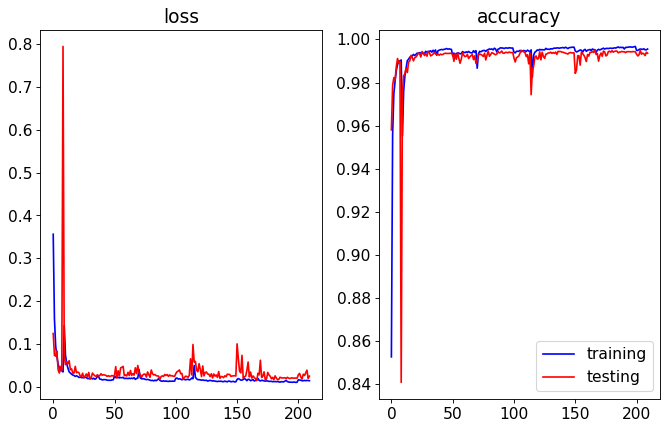

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.57it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


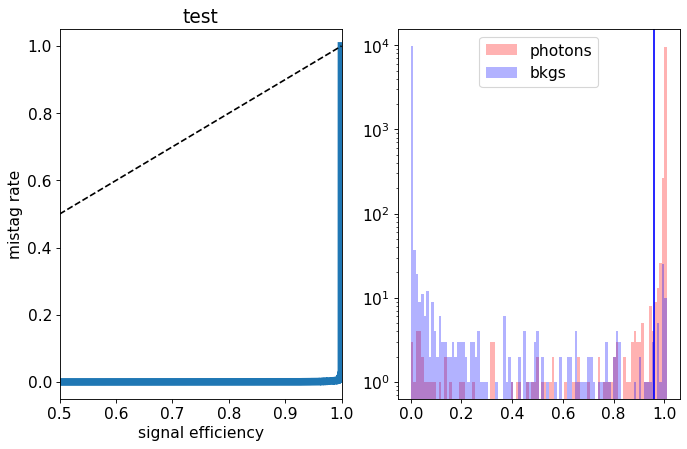

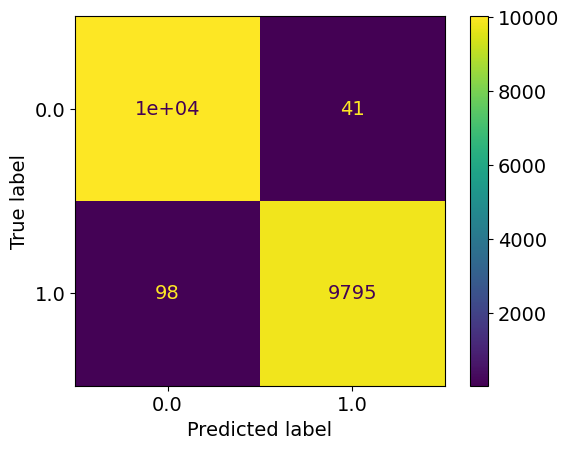

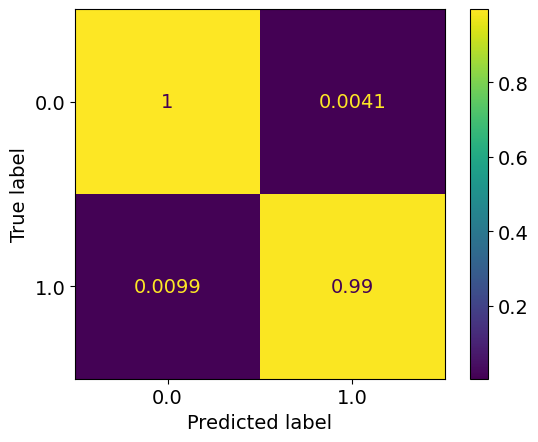

epoch: 210
Learning rate: 0.0009046462573286203


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.016022862081151844
train acc: 0.9953639


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.57it/s]


test loss: 0.03844469700690003
test acc: 0.9892748
epoch: 211
Learning rate: 0.0008854060213086437


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.021797904411136215
train acc: 0.9934969


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.040580009343102574
test acc: 0.99137974
epoch: 212
Learning rate: 0.0008646447637978243


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.014454611701327863
train acc: 0.9955268


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.027177375631735605
test acc: 0.9922317
epoch: 213
Learning rate: 0.0008424444199946415


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.013871399569325043
train acc: 0.9955268


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.04821674821569639
test acc: 0.99037737
epoch: 214
Learning rate: 0.0008188926045137135


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.015306530975555973
train acc: 0.9956521


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.018889038529082695
test acc: 0.9946875
epoch: 215
Learning rate: 0.0007940822656109428


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.01393754217632935
train acc: 0.9959152


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.57it/s]


test loss: 0.01734132754534264
test acc: 0.9947376
epoch: 216
Learning rate: 0.0007681113183592132


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.01581125341887054
train acc: 0.995414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.020666073206538224
test acc: 0.9939859
epoch: 217
Learning rate: 0.0007410822582223297


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.013639927868763465
train acc: 0.9959904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.48it/s]


test loss: 0.02617523827425697
test acc: 0.99313384
epoch: 218
Learning rate: 0.0007131017565522497


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.012543499367785076
train acc: 0.9962911


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.016640262856312534
test acc: 0.9945873
epoch: 219
Learning rate: 0.00068428023960599


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.013938971897059402
train acc: 0.9957022


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.027132709966013756
test acc: 0.9932842


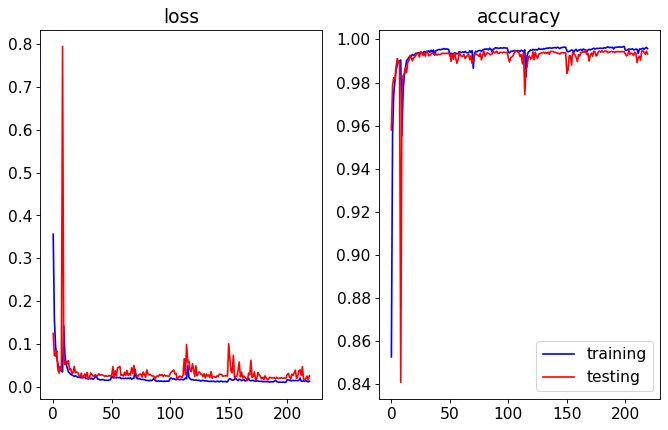

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.61it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


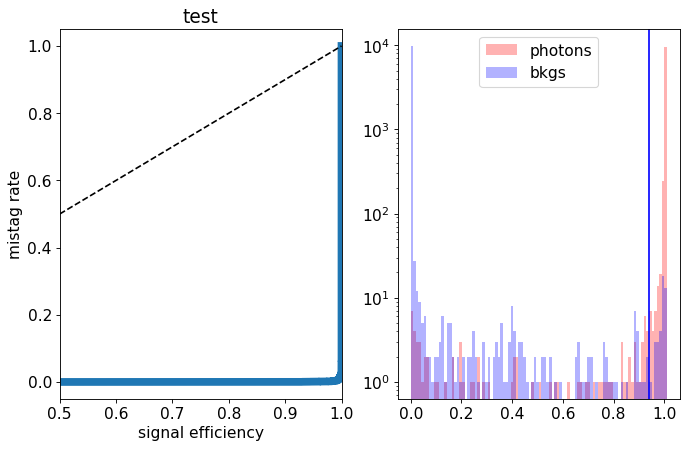

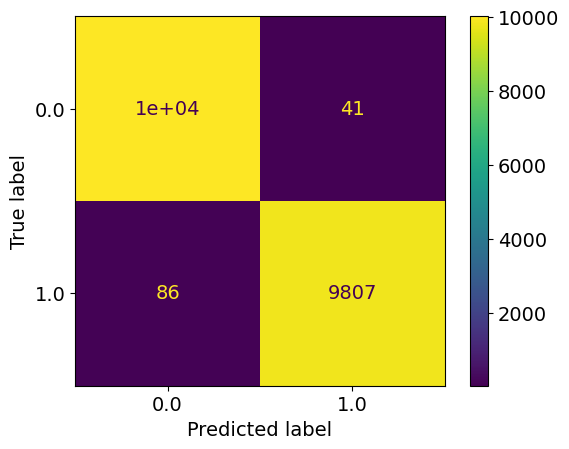

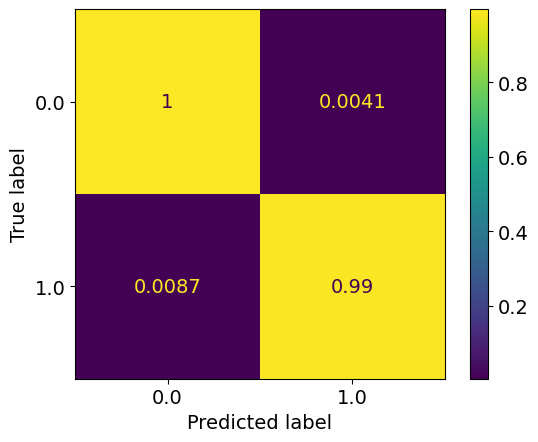

epoch: 220
Learning rate: 0.0006547314527436385


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.014032498186666157
train acc: 0.9960029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.02814119059107992
test acc: 0.9933845
epoch: 221
Learning rate: 0.0006245720115273845


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.013001706851460468
train acc: 0.99622846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.75it/s]


test loss: 0.03469197991687585
test acc: 0.9920313
epoch: 222
Learning rate: 0.0005939209414931706


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01319734852086864
train acc: 0.9961282


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.024460824824312593
test acc: 0.99433666
epoch: 223
Learning rate: 0.0005628992084112796


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01273155547574218
train acc: 0.99585253


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.015895778950139442
test acc: 0.994888
epoch: 224
Learning rate: 0.0005316292408897043


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.013297288144964222
train acc: 0.99610317


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.02915989731263835
test acc: 0.99343455
epoch: 225
Learning rate: 0.0005002344472043631


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.012571628060339126
train acc: 0.9964164


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.021605147613841195
test acc: 0.9945873
epoch: 226
Learning rate: 0.000468838728263015


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.012179380364424145
train acc: 0.9967297


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.02150660706769593
test acc: 0.9944369
epoch: 227
Learning rate: 0.0004375659886249818


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.012123474089772816
train acc: 0.9963788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.02902370348901433
test acc: 0.9918308
epoch: 228
Learning rate: 0.0004065396475064592


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.01230677502897026
train acc: 0.99620336


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.016261456813320845
test acc: 0.9944369
epoch: 229
Learning rate: 0.000375882151701255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01280042774265188
train acc: 0.9963287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.51it/s]


test loss: 0.024223597591866135
test acc: 0.9934847


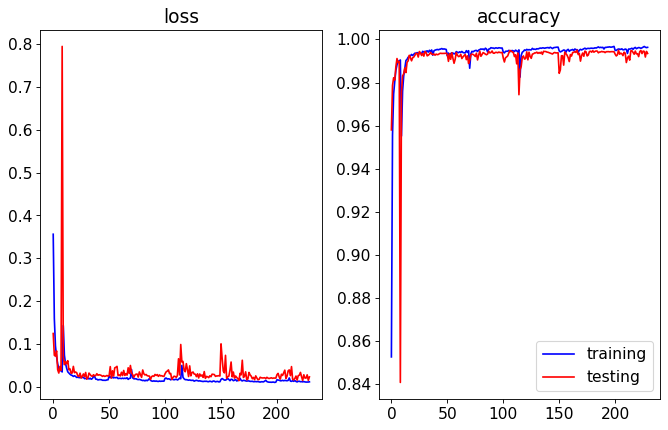

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


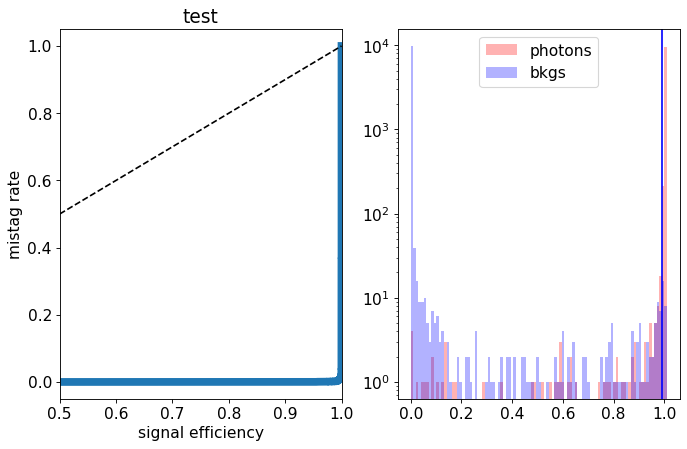

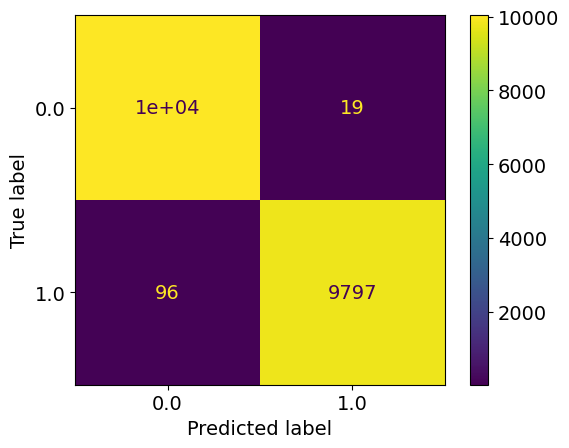

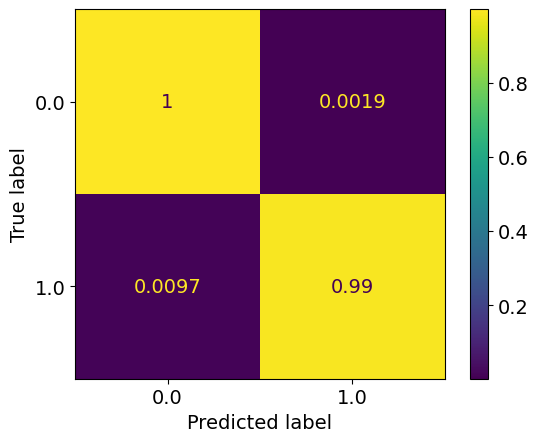

epoch: 230
Learning rate: 0.000345714492339235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.012239671807472052
train acc: 0.9963036


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.51it/s]


test loss: 0.024203605137967422
test acc: 0.99363506
epoch: 231
Learning rate: 0.0003161557273896083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.011933593042959361
train acc: 0.9964039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.016938442720428985
test acc: 0.9952889
new best acc: 0.9952889
epoch: 232
Learning rate: 0.0002873225117935158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.014423012456321506
train acc: 0.9958275


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.02328259886160274
test acc: 0.9936852
epoch: 233
Learning rate: 0.0002593286370802722


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011348149000750013
train acc: 0.996667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.018924743673243725
test acc: 0.99418634
epoch: 234
Learning rate: 0.0002322845822841862


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.011583045849562693
train acc: 0.9966043


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.01567808585926233
test acc: 0.9951887
epoch: 235
Learning rate: 0.00020629707793428403


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.01181425231283383
train acc: 0.9966169


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.01697248506688458
test acc: 0.9949381
epoch: 236
Learning rate: 0.00018146868483767353


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.011083362701057597
train acc: 0.99652916


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.01495559504324132
test acc: 0.994888
epoch: 237
Learning rate: 0.00015789738931889325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.010452277021857683
train acc: 0.99667954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.01640778169830275
test acc: 0.99503833
epoch: 238
Learning rate: 0.00013567621651265532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.011621858980663037
train acc: 0.9967672


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.020390291532641963
test acc: 0.99393576
epoch: 239
Learning rate: 0.00011489286323613752


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.010791898889787696
train acc: 0.9965417


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.01773189680705614
test acc: 0.9945372


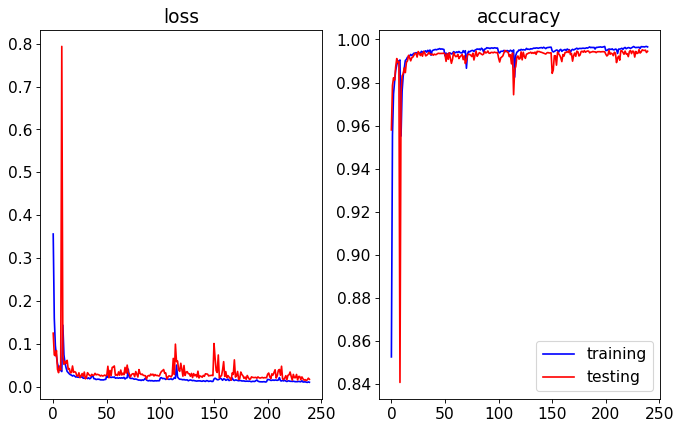

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


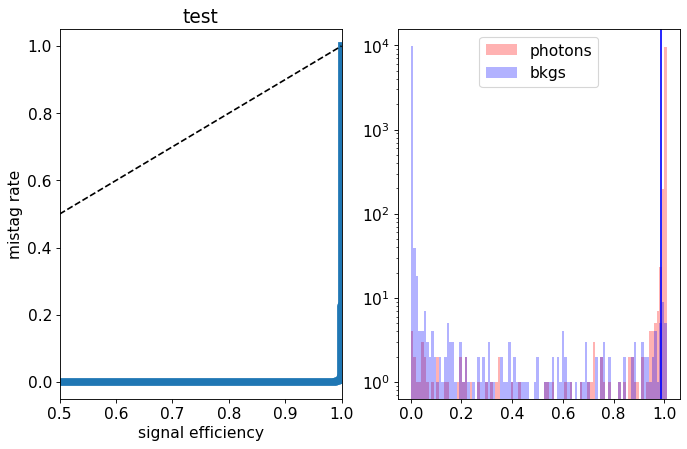

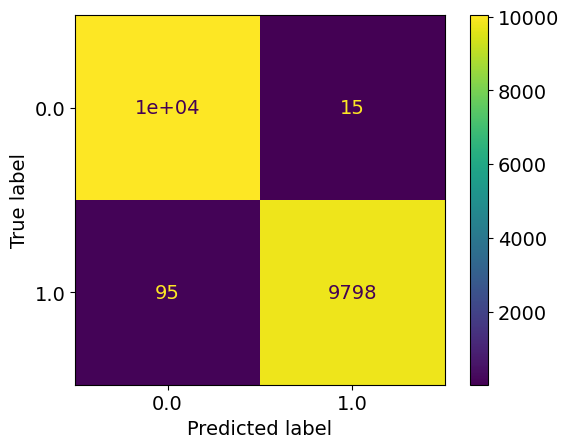

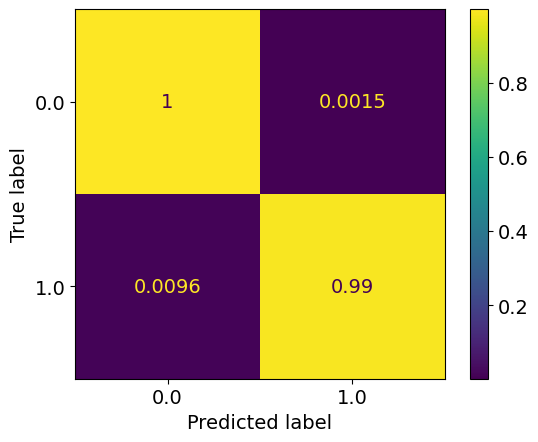

epoch: 240
Learning rate: 9.56293518897114e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.010382711614999892
train acc: 0.9967422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.01858183905716594
test acc: 0.99433666
epoch: 241
Learning rate: 7.79617067520002e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.26it/s]


train loss: 0.010529786182624816
train acc: 0.9969176


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.018437011102351415
test acc: 0.9949381
epoch: 242
Learning rate: 6.195965394678321e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.010480699708004162
train acc: 0.99667954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.018546317892340833
test acc: 0.99463737
epoch: 243
Learning rate: 4.7686346265839844e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.25it/s]


train loss: 0.011068008154175751
train acc: 0.99665445


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.01754043828976351
test acc: 0.9945873
epoch: 244
Learning rate: 3.5198113933733125e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.010945346033106795
train acc: 0.99652916


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.57it/s]


test loss: 0.01868372157075689
test acc: 0.99448705
epoch: 245
Learning rate: 2.4544242298147e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.010878357856444068
train acc: 0.9968675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.57it/s]


test loss: 0.016996267260230312
test acc: 0.99478775
epoch: 246
Learning rate: 1.5766777323136195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.010763852945885121
train acc: 0.9967171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.33it/s]


test loss: 0.017978174779701102
test acc: 0.9948379
epoch: 247
Learning rate: 8.900359652914802e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.26it/s]


train loss: 0.010962535560100883
train acc: 0.9965041


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.33it/s]


test loss: 0.01696255784105126
test acc: 0.9948379
epoch: 248
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.010490782118668265
train acc: 0.99680483


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.017029472188476252
test acc: 0.9947376
epoch: 249
Learning rate: 1.0014117046611704e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011310125511737346
train acc: 0.99647903


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.93it/s]


test loss: 0.017635294270482573
test acc: 0.99478775


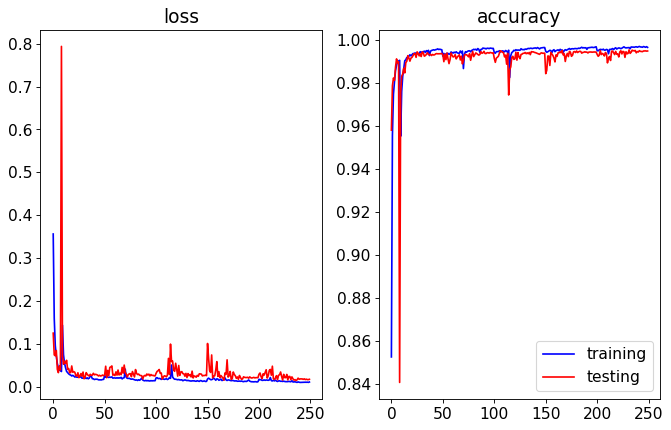

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


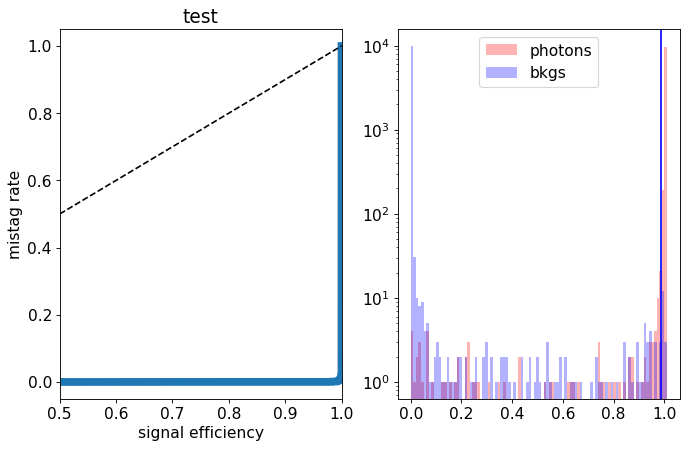

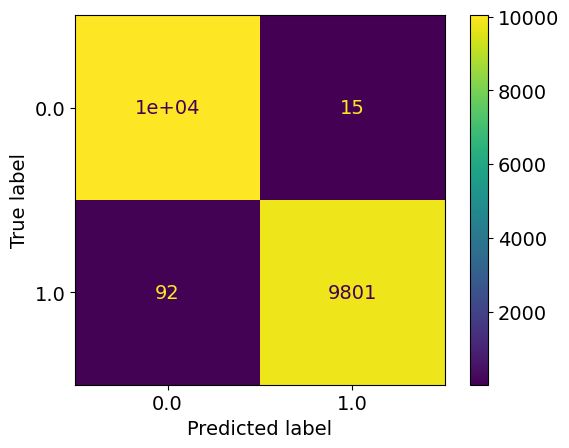

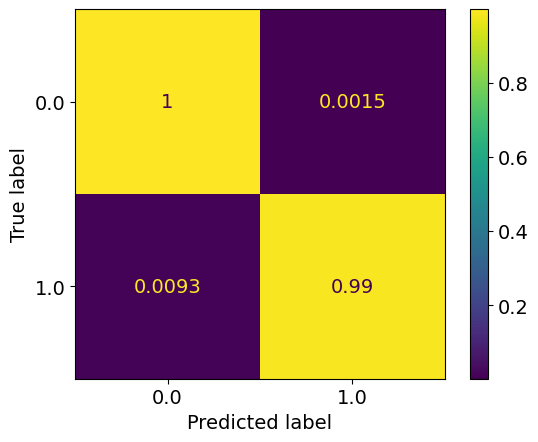

epoch: 250
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.014688745749820677
train acc: 0.9954641


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.026500397382358855
test acc: 0.99303365
epoch: 251
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.014083512717091375
train acc: 0.99557686


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.33it/s]


test loss: 0.019499975331949398
test acc: 0.9951386
epoch: 252
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.014728728674755862
train acc: 0.9953263


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.18it/s]


test loss: 0.020815415047656965
test acc: 0.99393576
epoch: 253
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.016806467646415173
train acc: 0.99512583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.0185801786103505
test acc: 0.99508846
epoch: 254
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.013837252201429054
train acc: 0.99594027


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.57it/s]


test loss: 0.03510071950800279
test acc: 0.99112916
epoch: 255
Learning rate: 0.0009756006540427168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.015056043443462895
train acc: 0.9953639


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.57it/s]


test loss: 0.01768313070266124
test acc: 0.9935348
epoch: 256
Learning rate: 0.0009649744976107356


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.016254748839801596
train acc: 0.99497545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.03018715008682407
test acc: 0.99228185
epoch: 257
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.015777899563979746
train acc: 0.99512583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.0294737611513804
test acc: 0.9937854
epoch: 258
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.01489178945111567
train acc: 0.9955518


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.024288636084426853
test acc: 0.99343455
epoch: 259
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.014459023154827196
train acc: 0.99585253


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.02155527375254999
test acc: 0.9945873


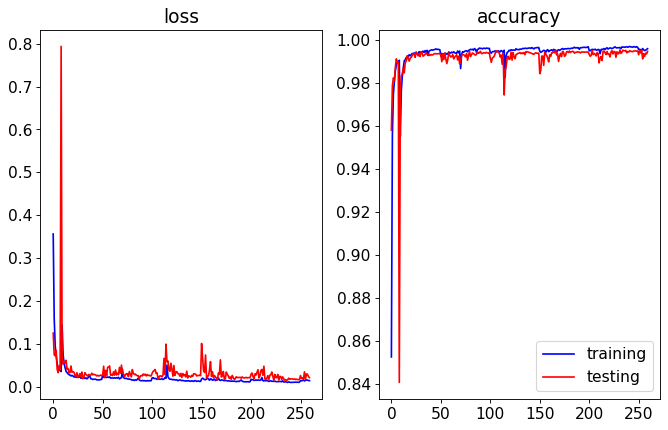

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


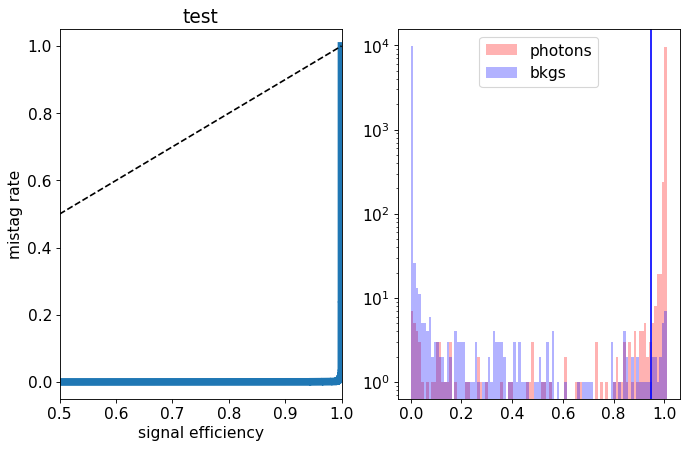

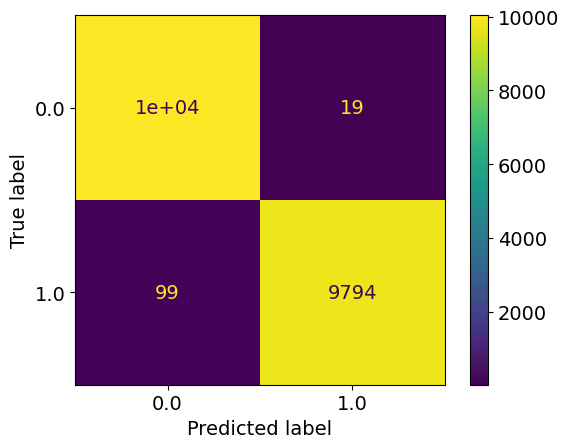

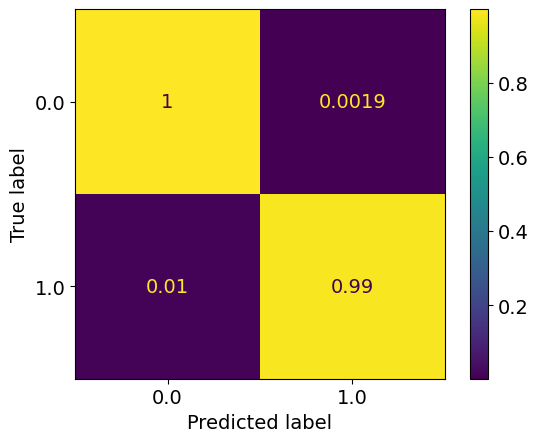

epoch: 260
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.014719713296838549
train acc: 0.99572724


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.03024676748078919
test acc: 0.9926327
epoch: 261
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.013918125141870573
train acc: 0.99563956


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.016496507485178027
test acc: 0.99403596
epoch: 262
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.013213597575635666
train acc: 0.9960154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.018557742012062055
test acc: 0.9949381
epoch: 263
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.013949930988236525
train acc: 0.9955518


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.042603932348463464
test acc: 0.9923821
epoch: 264
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.015658647499617134
train acc: 0.9958776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.014528033214018625
test acc: 0.99478775
epoch: 265
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.015846801480389576
train acc: 0.9953513


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.013621755793471546
test acc: 0.9951887
epoch: 266
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.012500166693011558
train acc: 0.9961783


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.015008121764848885
test acc: 0.99538916
new best acc: 0.99538916
epoch: 267
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.50it/s]


train loss: 0.013557388480238394
train acc: 0.99575233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.023148607187014184
test acc: 0.9941362
epoch: 268
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.75it/s]


train loss: 0.012512814705329599
train acc: 0.9961783


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.01761842192397179
test acc: 0.9945873
epoch: 269
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.012960536266657968
train acc: 0.9962535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.04074651361717021
test acc: 0.99213153


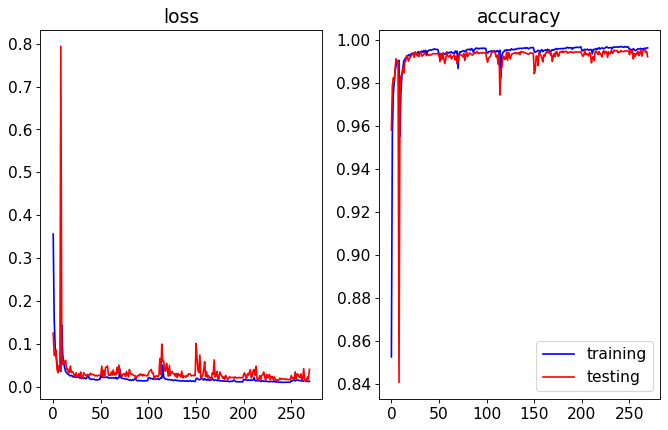

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


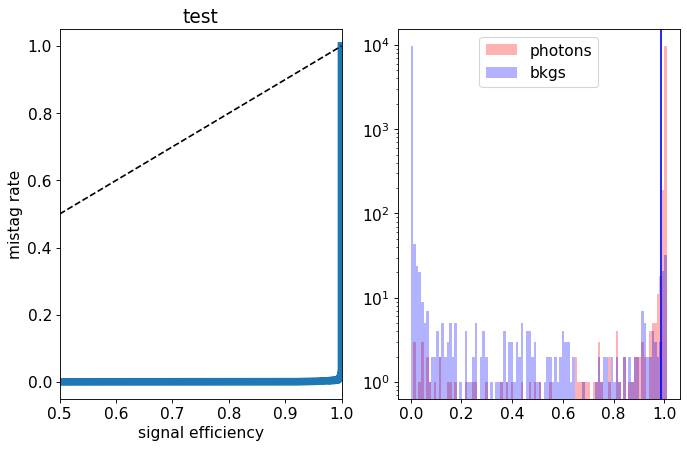

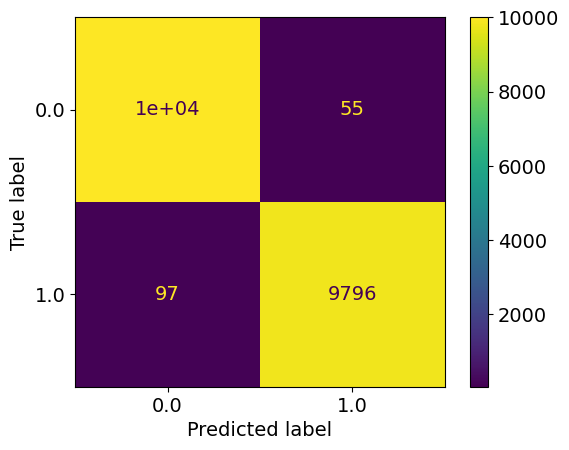

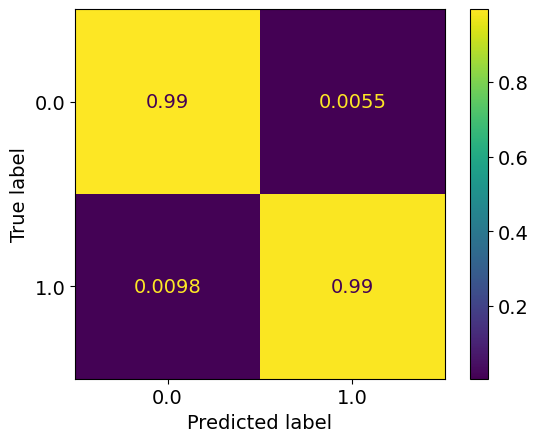

epoch: 270
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.013278512847557692
train acc: 0.99589014


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.014069874339517863
test acc: 0.99538916
epoch: 271
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.01217066287136195
train acc: 0.99631613


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.023250384920495835
test acc: 0.9943868
epoch: 272
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.012764188952730108
train acc: 0.99639136


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.031889742815538365
test acc: 0.99168044
epoch: 273
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.013276103658101123
train acc: 0.9959528


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.02972001764454249
test acc: 0.9930838
epoch: 274
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.012096480043904045
train acc: 0.9963412


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.01954261458526804
test acc: 0.9945873
epoch: 275
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.012202076172512202
train acc: 0.9965918


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.0183123791931019
test acc: 0.99584025
new best acc: 0.99584025
epoch: 276
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01448746618672288
train acc: 0.99619085


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.027175176851040518
test acc: 0.992332
epoch: 277
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.01696906335749177
train acc: 0.99447423


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.02311884405036621
test acc: 0.9929835
epoch: 278
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01200961164866032
train acc: 0.99649155


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.016724336782799047
test acc: 0.994888
epoch: 279
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011051060568179446
train acc: 0.996667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.51it/s]


test loss: 0.015857749361791375
test acc: 0.99478775


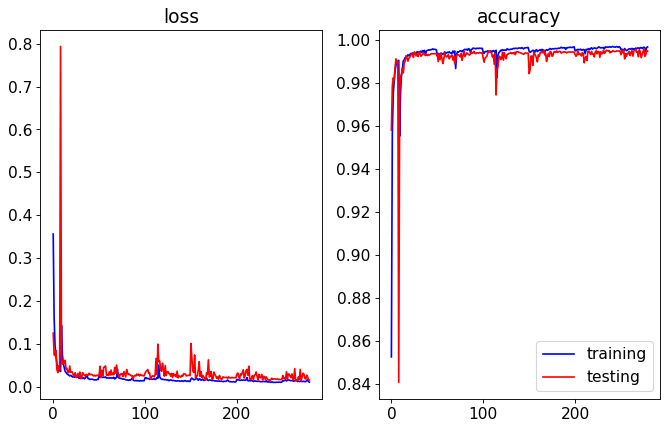

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


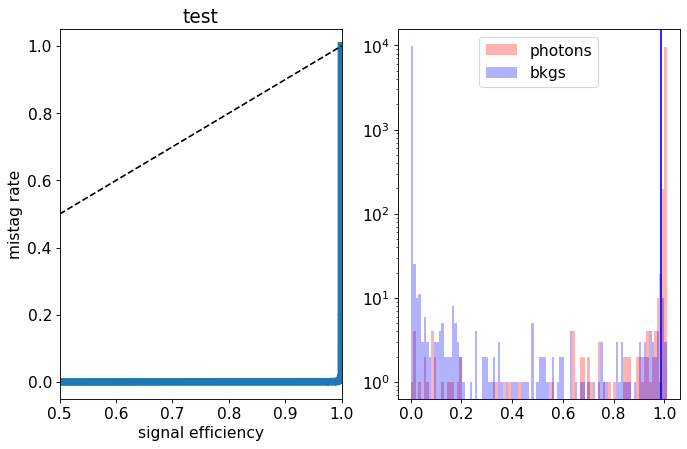

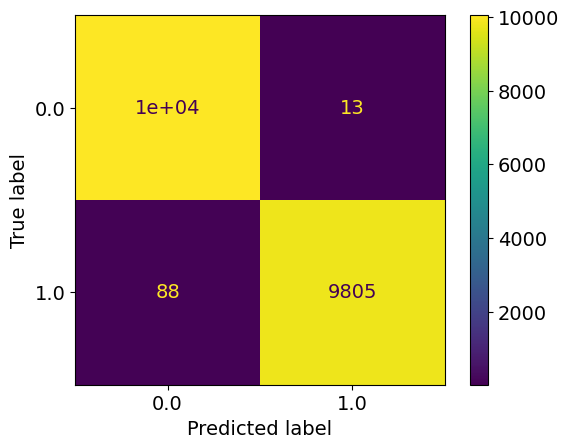

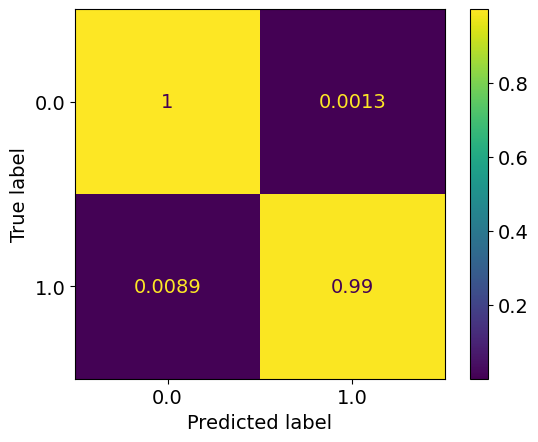

epoch: 280
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011970998303193266
train acc: 0.99631613


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.016323282196775406
test acc: 0.9949381
epoch: 281
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011735054990971711
train acc: 0.996667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.41it/s]


test loss: 0.028798279914018864
test acc: 0.99343455
epoch: 282
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011525474187271642
train acc: 0.9963788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.015694623117965153
test acc: 0.994888
epoch: 283
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.010772274930438959
train acc: 0.99649155


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.025983401105109164
test acc: 0.99343455
epoch: 284
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.45it/s]


train loss: 0.010708002028674054
train acc: 0.996667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.017624652949641186
test acc: 0.994888
epoch: 285
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011091967689256972
train acc: 0.99669206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.016254247751716962
test acc: 0.99478775
epoch: 286
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.010907746226689257
train acc: 0.9965417


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.016352351532559088
test acc: 0.9948379
epoch: 287
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011336248906662882
train acc: 0.9967798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.022525064037729275
test acc: 0.99403596
epoch: 288
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.011245572512079752
train acc: 0.9965918


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.61it/s]


test loss: 0.02267900841851609
test acc: 0.9939859
epoch: 289
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.71it/s]


train loss: 0.010882394610940645
train acc: 0.9967171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.64it/s]


test loss: 0.01886082550866858
test acc: 0.99448705


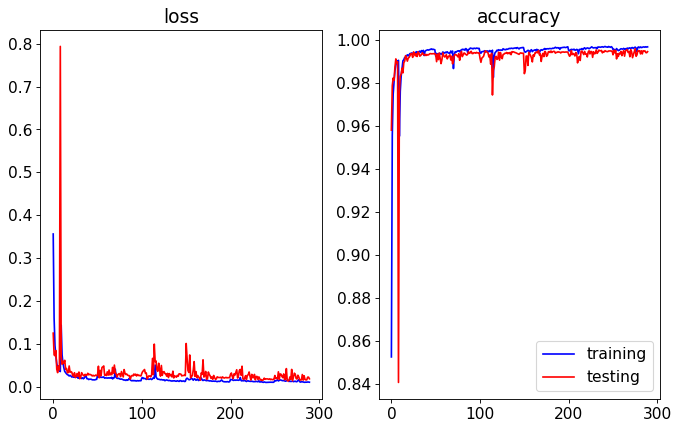

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.61it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


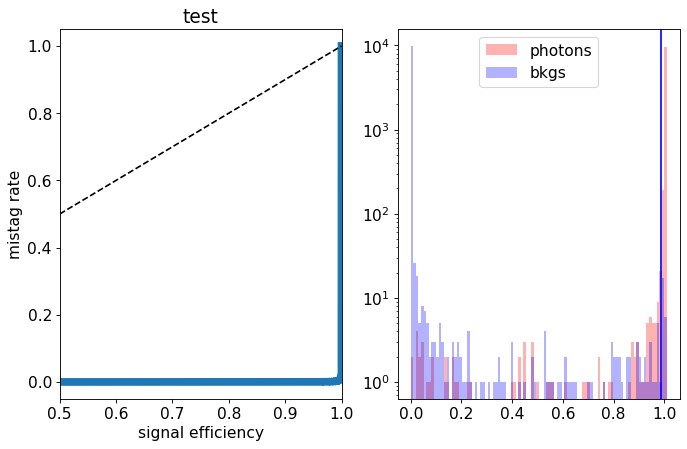

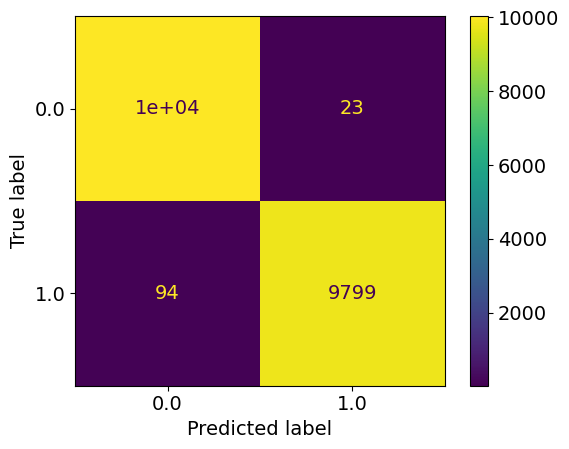

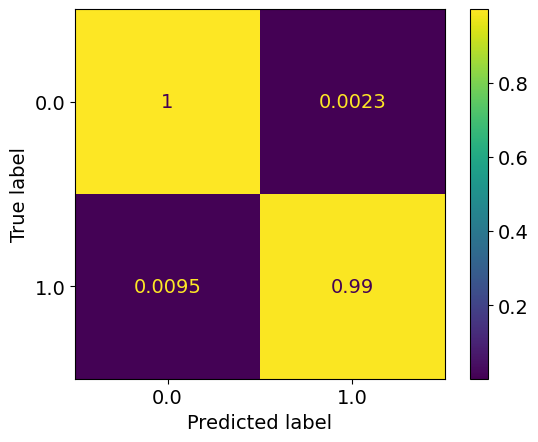

epoch: 290
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.45it/s]


train loss: 0.011049678976931643
train acc: 0.99669206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.63it/s]


test loss: 0.01537396660868955
test acc: 0.99538916
epoch: 291
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.71it/s]


train loss: 0.010507930922534825
train acc: 0.9967547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.63it/s]


test loss: 0.015900674166486543
test acc: 0.99533904
epoch: 292
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.46it/s]


train loss: 0.01054111383889415
train acc: 0.9967547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.63it/s]


test loss: 0.01456907597158159
test acc: 0.9954894
epoch: 293
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.71it/s]


train loss: 0.010391107970612374
train acc: 0.9969552


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.64it/s]


test loss: 0.01854104836633376
test acc: 0.9947376
epoch: 294
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.46it/s]


train loss: 0.010685023918588048
train acc: 0.99685496


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.61it/s]


test loss: 0.017875208854949212
test acc: 0.9948379
epoch: 295
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.71it/s]


train loss: 0.010154333720683058
train acc: 0.99681735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.62it/s]


test loss: 0.017958644541709767
test acc: 0.9949381
epoch: 296
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.71it/s]


train loss: 0.01043246263584275
train acc: 0.9970805


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.65it/s]


test loss: 0.018164224463843685
test acc: 0.9949381
epoch: 297
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.46it/s]


train loss: 0.009747300942084376
train acc: 0.9972058


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.0178084513566265
test acc: 0.99503833
epoch: 298
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.009987964744222656
train acc: 0.9969301


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.01762352248381242
test acc: 0.99503833
epoch: 299
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.010323869163870252
train acc: 0.99685496


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.019178718545898685
test acc: 0.99503833


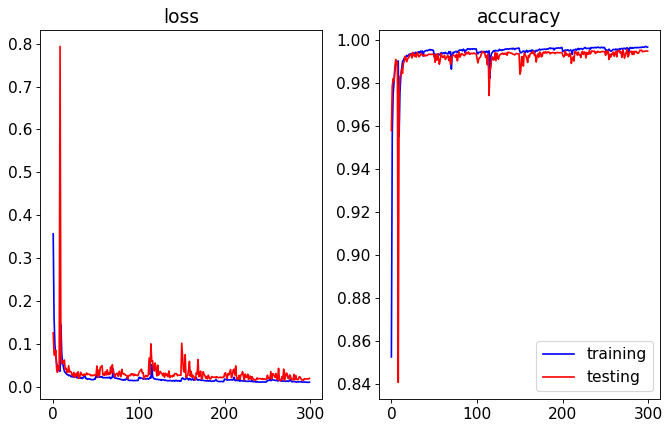

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.51it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


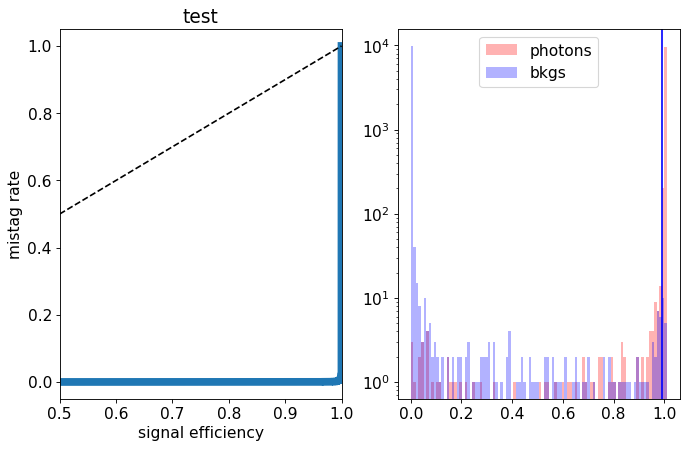

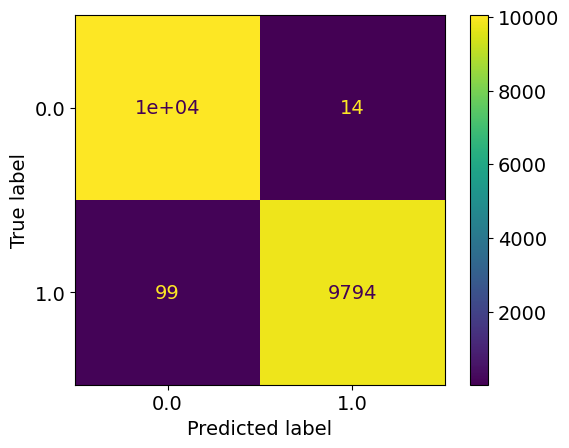

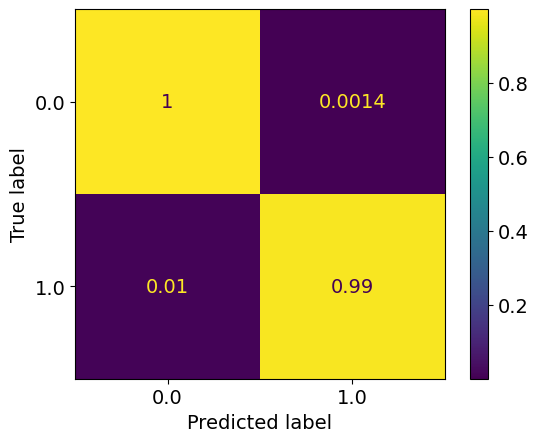

epoch: 300
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.0137507182528123
train acc: 0.9959152


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.014134196311180644
test acc: 0.9955896
epoch: 301
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.016477356007828292
train acc: 0.9953764


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.02333349599982338
test acc: 0.9939859
epoch: 302
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.74it/s]


train loss: 0.013687243367916272
train acc: 0.99602795


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.029982026303460932
test acc: 0.99278307
epoch: 303
Learning rate: 0.0009911875023977945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.51it/s]


train loss: 0.012933186379412482
train acc: 0.9961783


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.030098178321221733
test acc: 0.9929334
epoch: 304
Learning rate: 0.0009843498319744624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.75it/s]


train loss: 0.013725698162769945
train acc: 0.99586505


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.016418078351895984
test acc: 0.9952889
epoch: 305
Learning rate: 0.0009756006540427171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.01419209233144604
train acc: 0.9956521


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.01988287868837634
test acc: 0.99418634
epoch: 306
Learning rate: 0.000964974497610736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.01353810362278053
train acc: 0.99590266


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.02173928198253099
test acc: 0.99463737
epoch: 307
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.013444447586071372
train acc: 0.99576485


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.020678028087679517
test acc: 0.9938355
epoch: 308
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.013523325982641294
train acc: 0.99585253


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.013978181755245553
test acc: 0.9960407
new best acc: 0.9960407
epoch: 309
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.013114387705077682
train acc: 0.99572724


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.029565353237558156
test acc: 0.99198115


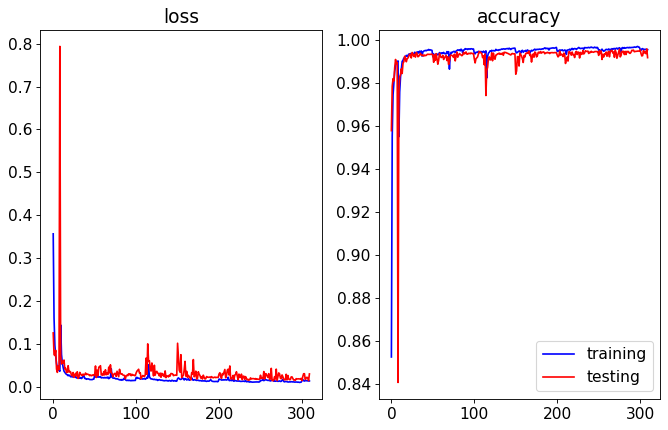

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


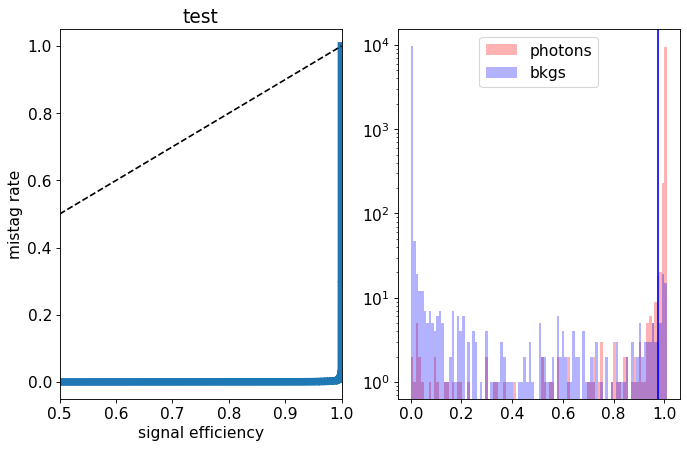

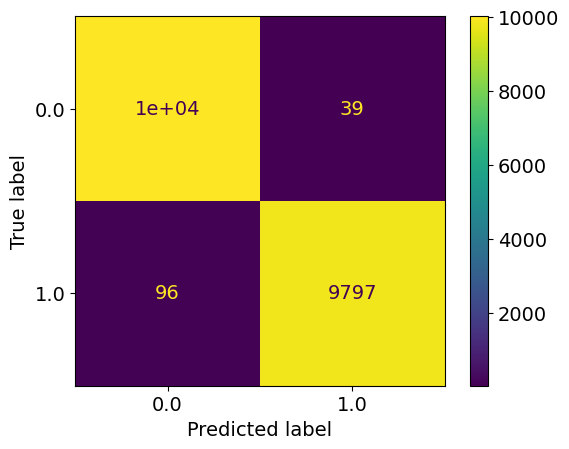

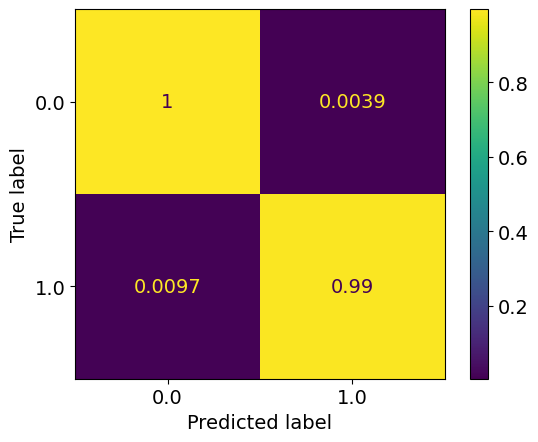

epoch: 310
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.013096399247286226
train acc: 0.9956521


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.022952480803189033
test acc: 0.9938355
epoch: 311
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.013101758630842026
train acc: 0.99621594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.43it/s]


test loss: 0.048628619598115194
test acc: 0.99278307
epoch: 312
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.013513263513042082
train acc: 0.99585253


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.023585844976717934
test acc: 0.9948379
epoch: 313
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.013520465706563694
train acc: 0.9960154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.023546674521639943
test acc: 0.9934847
epoch: 314
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.012702978453693396
train acc: 0.9959904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.027929977417978293
test acc: 0.99403596
epoch: 315
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.013164199063699492
train acc: 0.99602795


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.030078864266055032
test acc: 0.99288327
epoch: 316
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.01190364861916472
train acc: 0.99620336


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.01856435343335547
test acc: 0.9948379
epoch: 317
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.69it/s]


train loss: 0.014113163248872128
train acc: 0.9956771


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.031608434455633605
test acc: 0.9918809
epoch: 318
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.45it/s]


train loss: 0.012231327179791545
train acc: 0.9964039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.024299036300576785
test acc: 0.99373525
epoch: 319
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0123591126605096
train acc: 0.9964039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.01279988293262089
test acc: 0.99563974


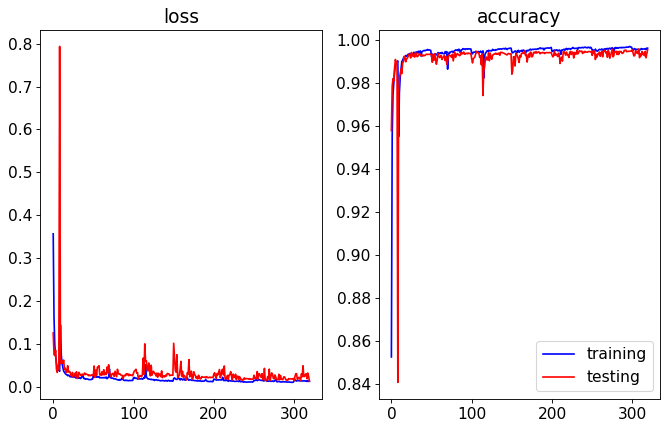

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


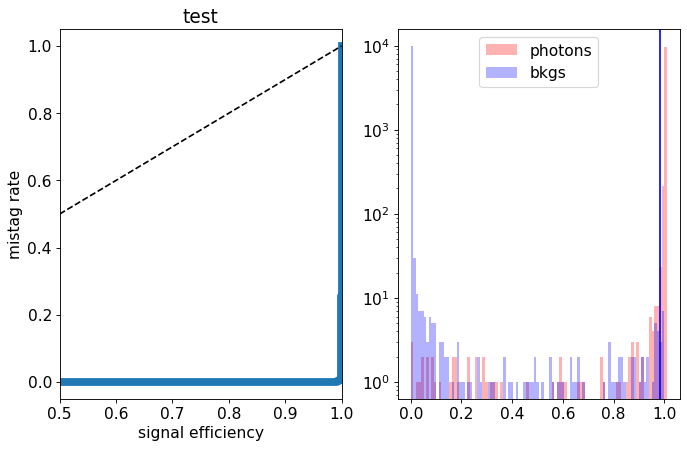

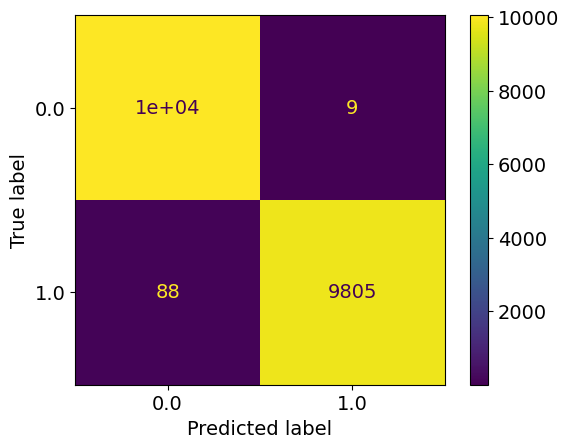

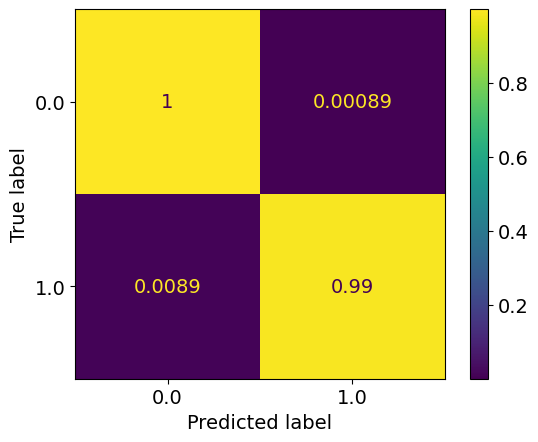

epoch: 320
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.011033996168190419
train acc: 0.9967798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.02086755308076082
test acc: 0.99433666
epoch: 321
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.69it/s]


train loss: 0.012072351221652908
train acc: 0.99649155


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.01508449815104113
test acc: 0.9955896
epoch: 322
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.01164498117251961
train acc: 0.9967171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.03693488390897127
test acc: 0.991931
epoch: 323
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01340652515142183
train acc: 0.996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.017455472559531164
test acc: 0.9947376
epoch: 324
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011361264564625141
train acc: 0.9964415


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.44it/s]


test loss: 0.016262629747335965
test acc: 0.99508846
epoch: 325
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.014949175260976041
train acc: 0.99594027


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.023138438015902305
test acc: 0.9936852
epoch: 326
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011044948764923793
train acc: 0.996667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.015285009175867718
test acc: 0.9947376
epoch: 327
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.010843671077896373
train acc: 0.9967171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.58it/s]


test loss: 0.01673147305743495
test acc: 0.9944369
epoch: 328
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011489846628950232
train acc: 0.99647903


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.013524020669351825
test acc: 0.9955896
epoch: 329
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.013548947452336643
train acc: 0.99622846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.0163929786067456
test acc: 0.9940861


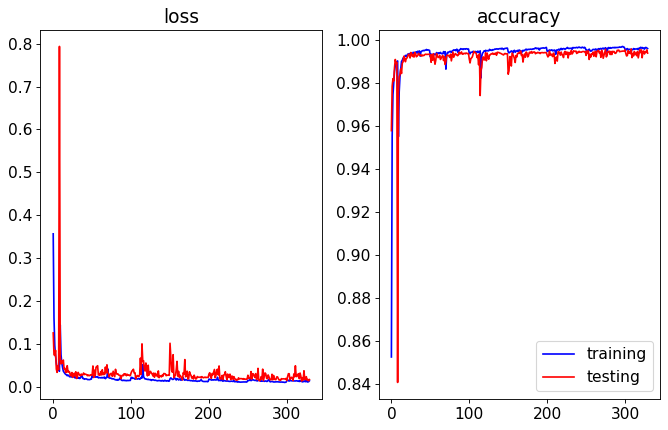

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


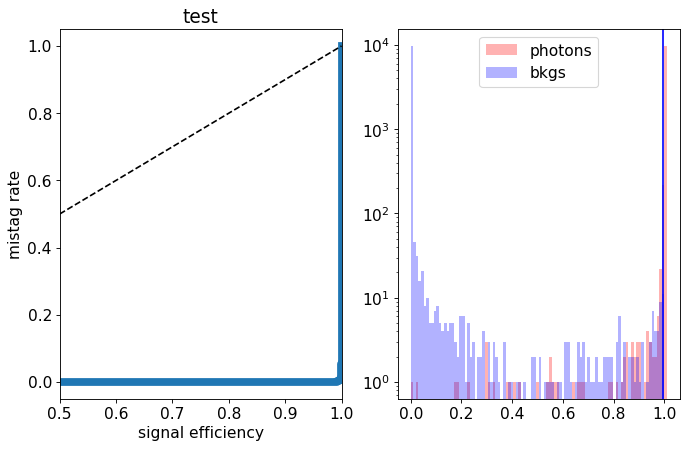

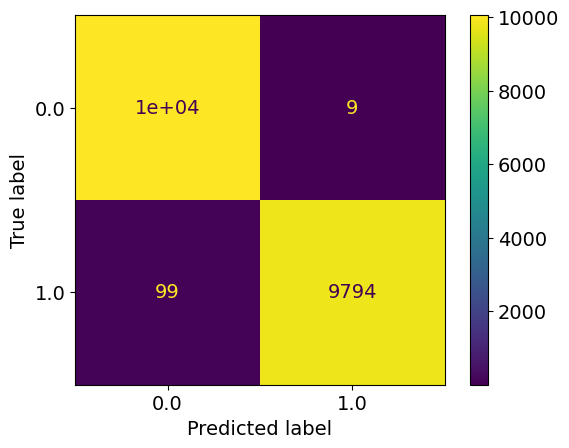

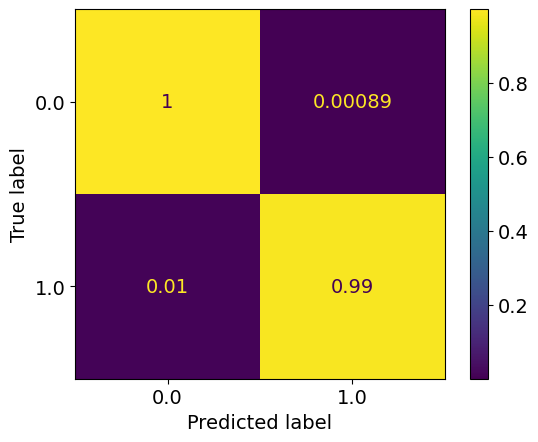

epoch: 330
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011212034814699142
train acc: 0.9965668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.01568870635374504
test acc: 0.99523884
epoch: 331
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.011096337288896094
train acc: 0.99639136


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.012951225593603928
test acc: 0.9954393
epoch: 332
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011499185058628835
train acc: 0.9965668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.014848727398844751
test acc: 0.9955896
epoch: 333
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.011073051283740675
train acc: 0.99664193


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.010182675662423101
test acc: 0.996191
new best acc: 0.996191
epoch: 334
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.010839426086386253
train acc: 0.99680483


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.013712053865139536
test acc: 0.9952889
epoch: 335
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.010333494104275533
train acc: 0.9971682


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.013761764580575639
test acc: 0.99478775
epoch: 336
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.010273074894288204
train acc: 0.9969176


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.01435414356563021
test acc: 0.99533904
epoch: 337
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.009948015976010877
train acc: 0.99698025


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.15it/s]


test loss: 0.012048500115805142
test acc: 0.99584025
epoch: 338
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.010253030877150317
train acc: 0.997093


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.26it/s]


test loss: 0.014881382713450448
test acc: 0.99523884
epoch: 339
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.010210373618730352
train acc: 0.99681735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.14it/s]


test loss: 0.016649180260548534
test acc: 0.99508846


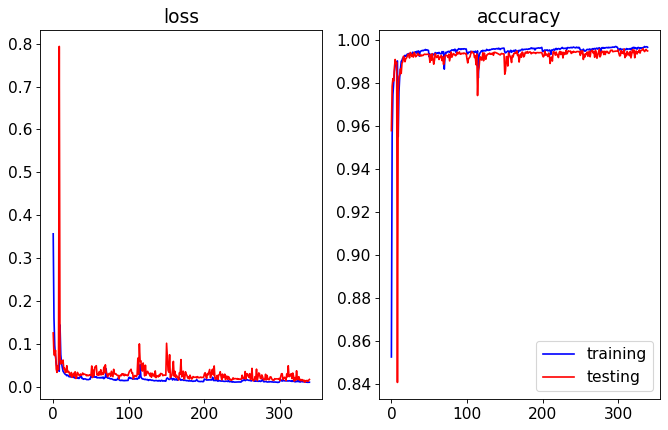

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


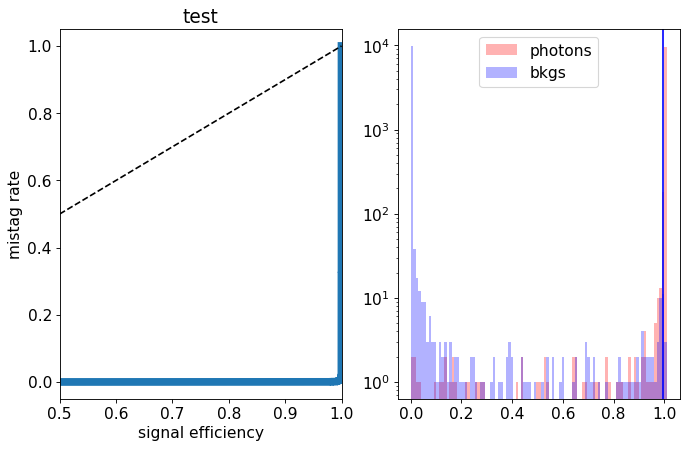

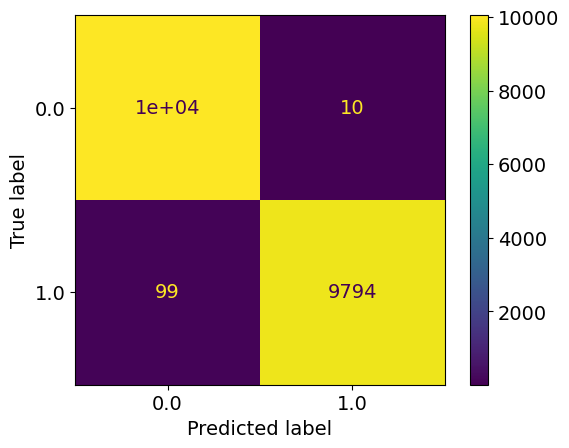

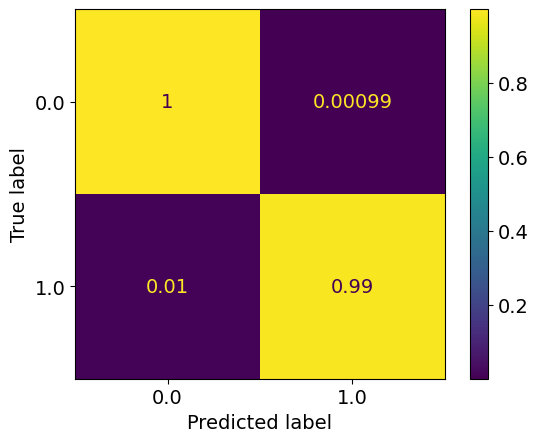

epoch: 340
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.009842813197424357
train acc: 0.9970053


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.022657635686782134
test acc: 0.9940861
epoch: 341
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.010475591411935721
train acc: 0.99681735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.13it/s]


test loss: 0.012089787277064341
test acc: 0.9960908
epoch: 342
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.010239987388260163
train acc: 0.9970053


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.013194342607354937
test acc: 0.99574
epoch: 343
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.010246409840860974
train acc: 0.9967672


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.01216785142177661
test acc: 0.9958903
epoch: 344
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.010353207391853542
train acc: 0.9969051


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.015363956470323233
test acc: 0.99533904
epoch: 345
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.009958570551799625
train acc: 0.9972058


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.013956354208537103
test acc: 0.99538916
epoch: 346
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.010238192760174462
train acc: 0.99696773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.014957894214175586
test acc: 0.9954393
epoch: 347
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.009996221971579953
train acc: 0.9970429


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.015049471432575956
test acc: 0.99538916
epoch: 348
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.009889317083162943
train acc: 0.99698025


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.016547640090506962
test acc: 0.9952889
epoch: 349
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.00961085705958819
train acc: 0.9970805


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.01482114112620954
test acc: 0.9952889


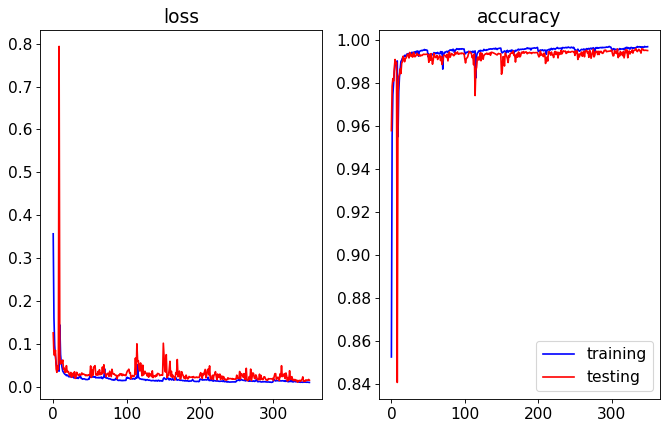

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


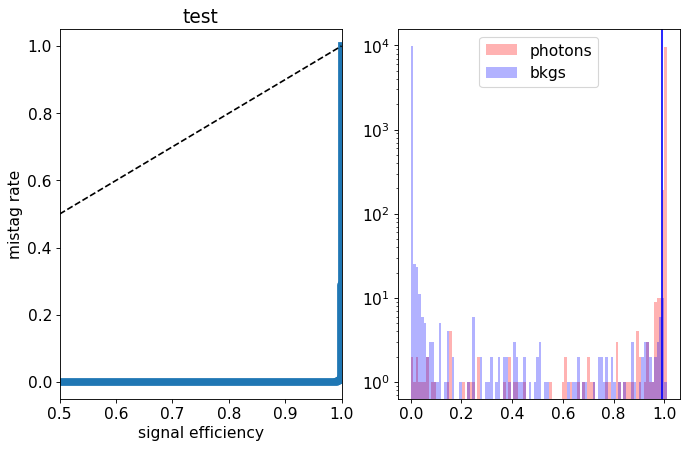

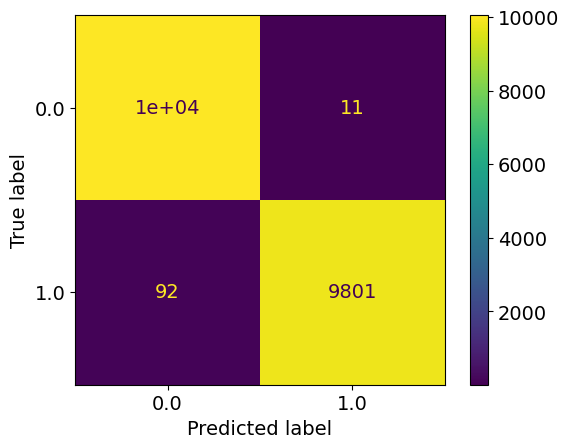

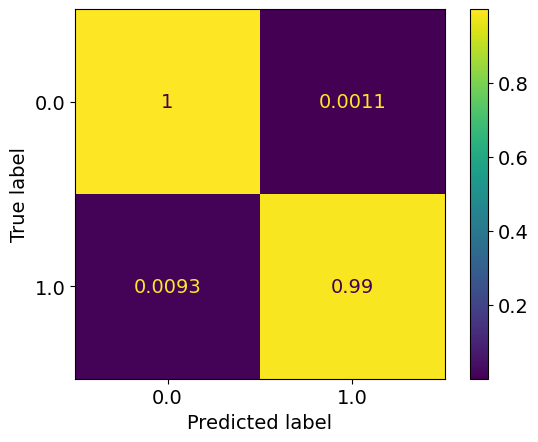

epoch: 350
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.014265484568826271
train acc: 0.9960154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.02918374032699777
test acc: 0.99288327
epoch: 351
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01281732978792722
train acc: 0.9959904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.01776772262939416
test acc: 0.9942866
epoch: 352
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.01311450932216622
train acc: 0.9959653


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.25it/s]


test loss: 0.026564562022138166
test acc: 0.99142987
epoch: 353
Learning rate: 0.0009911875023977945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.014892961630517784
train acc: 0.9957022


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.011566649127737893
test acc: 0.99584025
epoch: 354
Learning rate: 0.0009843498319744624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01428393274718448
train acc: 0.9958776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.77it/s]


test loss: 0.0203595014549244
test acc: 0.99283314
epoch: 355
Learning rate: 0.0009756006540427171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.012255369887125639
train acc: 0.9961533


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.024085716068785748
test acc: 0.9932842
epoch: 356
Learning rate: 0.000964974497610736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.013355572530287388
train acc: 0.9960029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.026703136793324065
test acc: 0.9936852
epoch: 357
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.012955443623142665
train acc: 0.99605304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.0318172361345633
test acc: 0.9924823
epoch: 358
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01279704782778094
train acc: 0.9959528


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.02569982371471055
test acc: 0.9926828
epoch: 359
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.013005553769927694
train acc: 0.9962535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.013471222996218678
test acc: 0.9954393


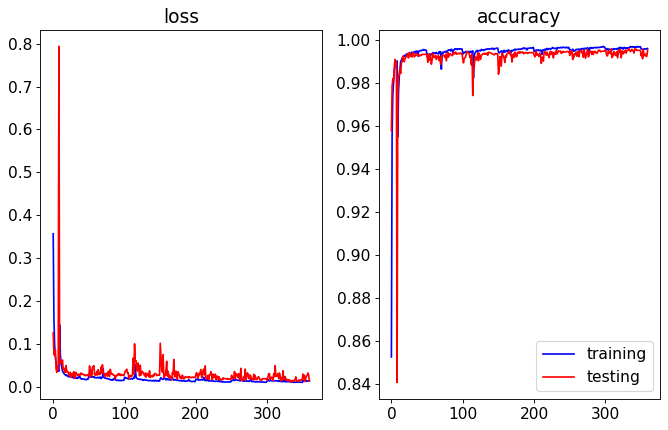

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


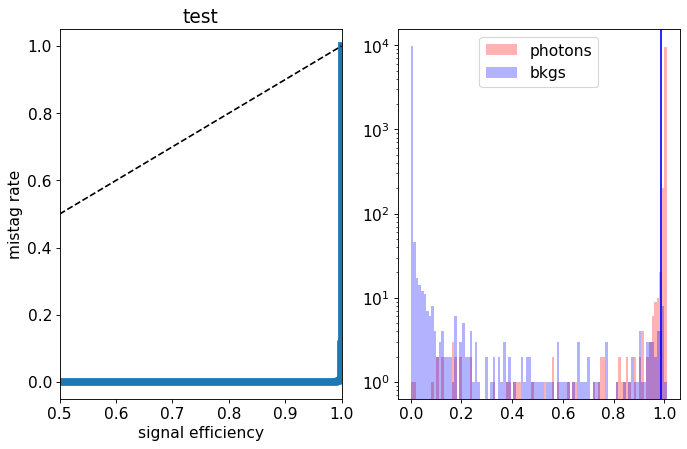

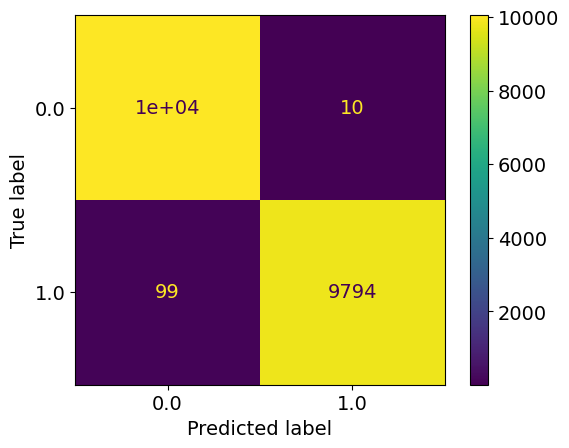

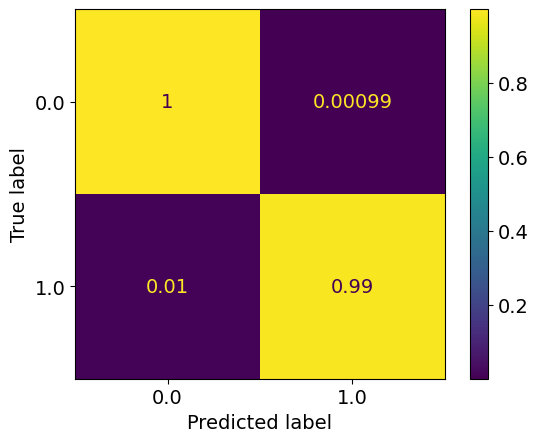

epoch: 360
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.012157570212756676
train acc: 0.9962911


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.93it/s]


test loss: 0.01907795837477726
test acc: 0.99478775
epoch: 361
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.013693738170141882
train acc: 0.9961658


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.02036850308478974
test acc: 0.99373525
epoch: 362
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.011815840248033707
train acc: 0.9960781


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.01760735492194619
test acc: 0.9947376
epoch: 363
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.012956057713680236
train acc: 0.9959778


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.024100428707349825
test acc: 0.99393576
epoch: 364
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.013362170902511744
train acc: 0.99635375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.021986415568629607
test acc: 0.9926828
epoch: 365
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.013124447839467692
train acc: 0.99605304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.02105656686677214
test acc: 0.9938355
epoch: 366
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.012190377027397531
train acc: 0.99639136


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.018105819619342906
test acc: 0.99403596
epoch: 367
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.011549086280756998
train acc: 0.9965668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.031452155877452564
test acc: 0.9926828
epoch: 368
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011688649066230421
train acc: 0.99631613


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.01625488543718615
test acc: 0.9944369
epoch: 369
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011216674317995003
train acc: 0.9966294


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.01617686018032734
test acc: 0.994888


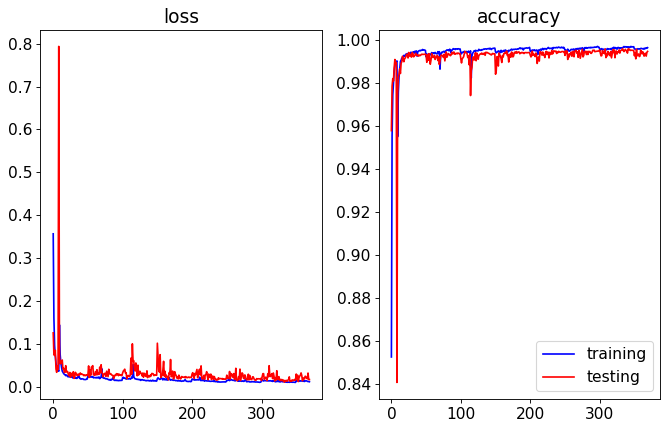

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


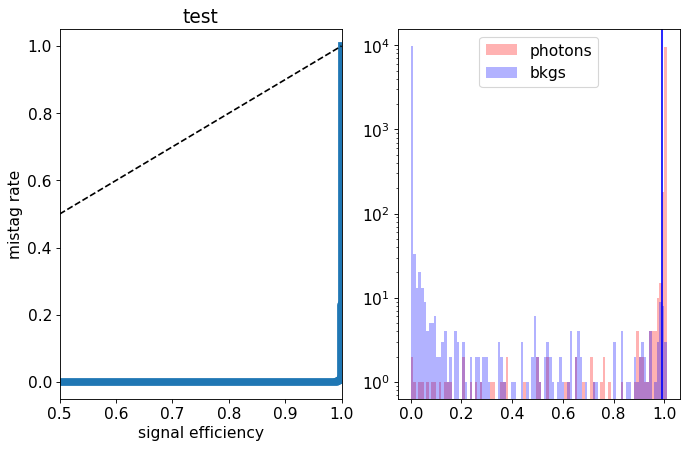

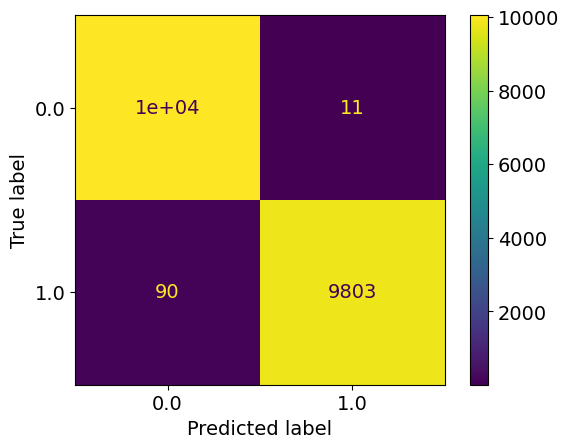

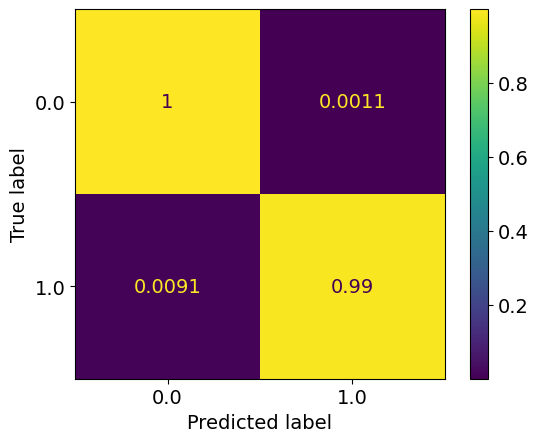

epoch: 370
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011410147668411539
train acc: 0.9967923


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.014233164972050445
test acc: 0.99533904
epoch: 371
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.69it/s]


train loss: 0.011155805255133492
train acc: 0.9967046


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.54it/s]


test loss: 0.01869765849893584
test acc: 0.99363506
epoch: 372
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.010827493650954714
train acc: 0.9967547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.018792820060351753
test acc: 0.9944369
epoch: 373
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.0116303269629742
train acc: 0.9964164


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.016076742355139954
test acc: 0.9948379
epoch: 374
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.010731406741403738
train acc: 0.99680483


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.02568526067497099
test acc: 0.99433666
epoch: 375
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.013083182654079439
train acc: 0.9964415


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.01352394199656213
test acc: 0.99568987
epoch: 376
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.012528848207592145
train acc: 0.9965417


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.01248863574309165
test acc: 0.99553955
epoch: 377
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011284744166860308
train acc: 0.9965417


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.011803158313448555
test acc: 0.9957901
epoch: 378
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.010803122862256062
train acc: 0.99701786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.011668556844918332
test acc: 0.99574
epoch: 379
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.010909195228055408
train acc: 0.9964039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.014114701589706409
test acc: 0.99508846


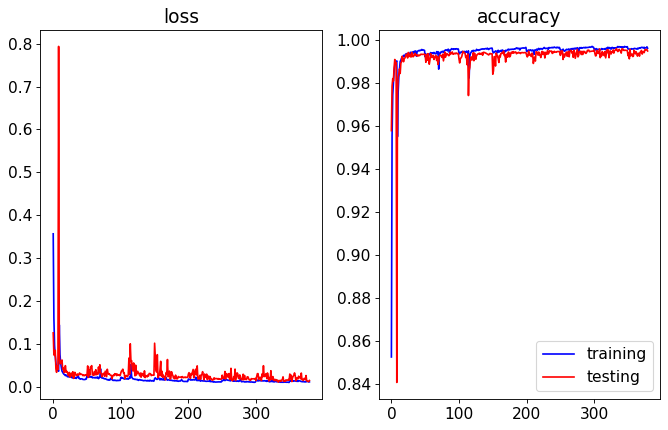

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.51it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


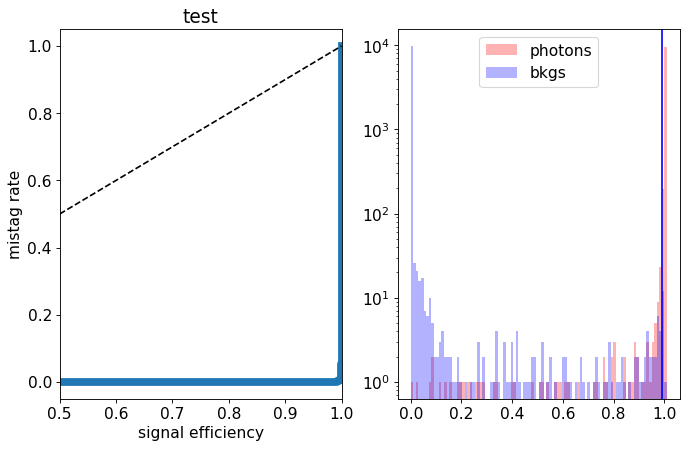

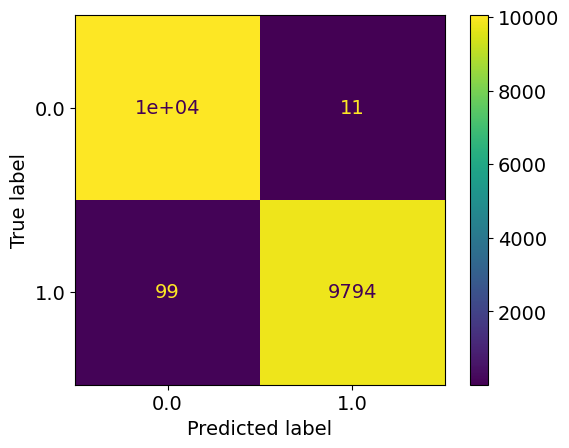

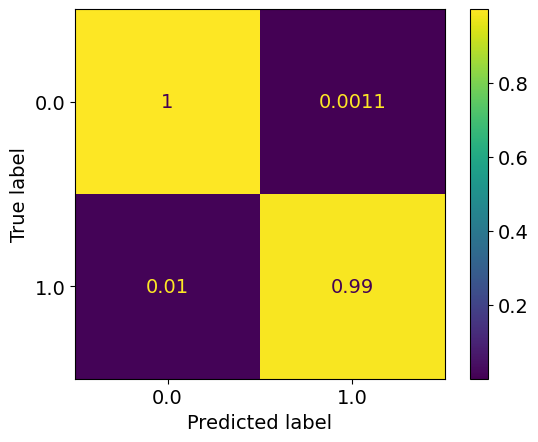

epoch: 380
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.010234737754868927
train acc: 0.99684244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.01435552810674862
test acc: 0.9949882
epoch: 381
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.009732612600315922
train acc: 0.9970053


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.57it/s]


test loss: 0.013898246510721305
test acc: 0.9954393
epoch: 382
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.010185213343400175
train acc: 0.99688


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.01359739144305315
test acc: 0.9952889
epoch: 383
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.009907828279685772
train acc: 0.9967422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.016608888760161148
test acc: 0.9949381
epoch: 384
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.010085339015059014
train acc: 0.99699277


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.02389754609697882
test acc: 0.99418634
epoch: 385
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.010100701952931342
train acc: 0.99696773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.014744091368116
test acc: 0.9955896
epoch: 386
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.009896589248869735
train acc: 0.9969051


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.014870838426063796
test acc: 0.9949381
epoch: 387
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.009935756279928546
train acc: 0.99699277


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.021998991891878712
test acc: 0.99448705
epoch: 388
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.009721754913942874
train acc: 0.9967798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.01637622371644658
test acc: 0.99523884
epoch: 389
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.010029146975121781
train acc: 0.9969552


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.0177200625253403
test acc: 0.99463737


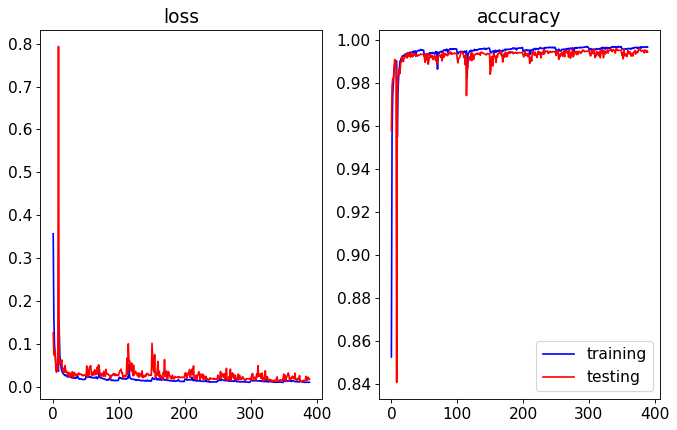

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


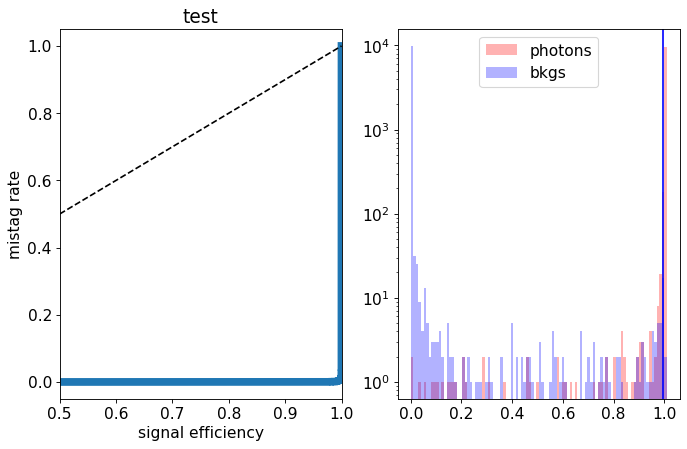

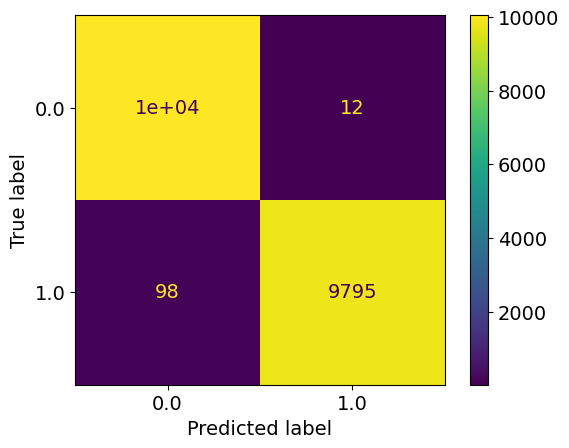

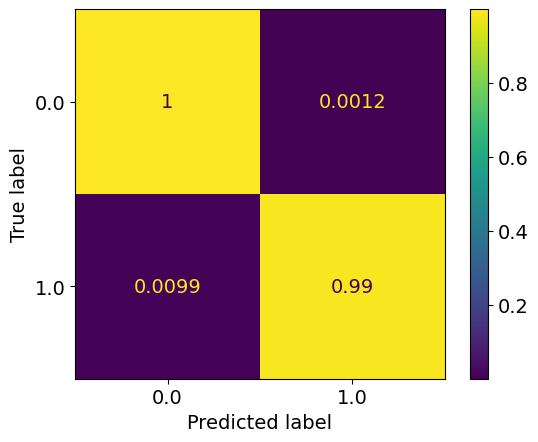

epoch: 390
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.009252177211699257
train acc: 0.9972434


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.015548669000375359
test acc: 0.99523884
epoch: 391
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.00972328017163438
train acc: 0.99726844


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.013339452620344031
test acc: 0.9952889
epoch: 392
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01136386277651025
train acc: 0.99715567


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.021415437282378075
test acc: 0.99418634
epoch: 393
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.009954166853602337
train acc: 0.9970304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.31it/s]


test loss: 0.017126579560092923
test acc: 0.9948379
epoch: 394
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.009859275141479884
train acc: 0.9970304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.016635619156980228
test acc: 0.99478775
epoch: 395
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.009399559163773405
train acc: 0.9972058


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.016404609853292212
test acc: 0.99523884
epoch: 396
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.00993877719323411
train acc: 0.9971682


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.016208821491625926
test acc: 0.994888
epoch: 397
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.008846211392504084
train acc: 0.99730605


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.01617860438401455
test acc: 0.994888
epoch: 398
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.00968037239001168
train acc: 0.99718076


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.016157628441065112
test acc: 0.994888
epoch: 399
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.009120412119629474
train acc: 0.9972308


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.017163564880748335
test acc: 0.994888


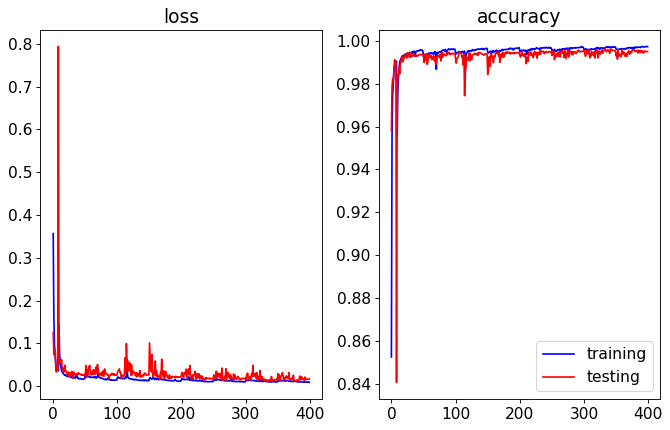

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.41it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


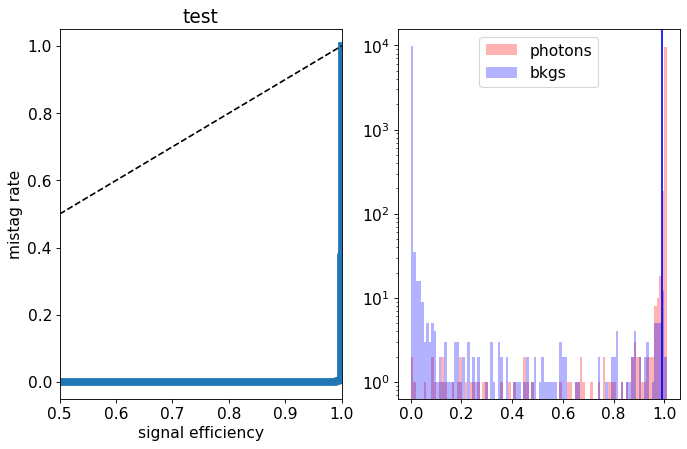

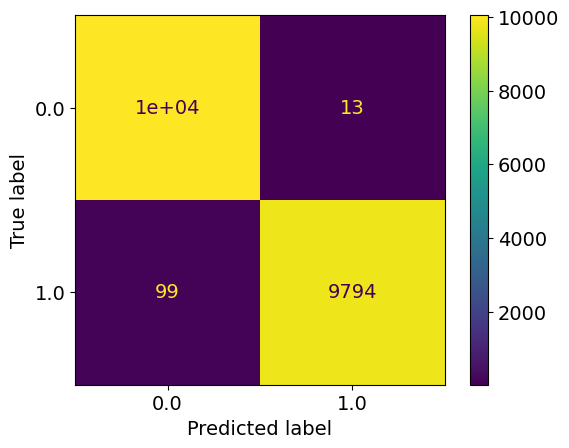

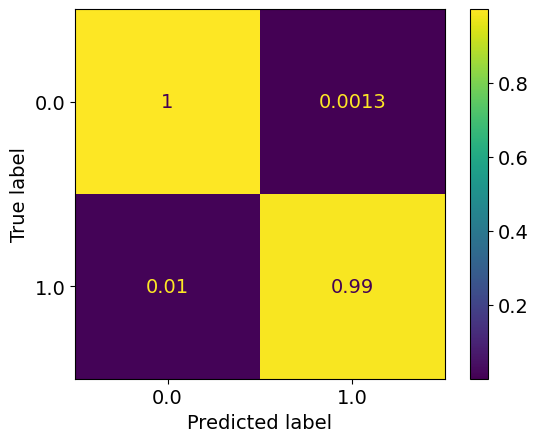

epoch: 400
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.014172170045368596
train acc: 0.9958275


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.018569105462280706
test acc: 0.99448705
epoch: 401
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.012291744363549819
train acc: 0.9961407


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.34it/s]


test loss: 0.016256117683095747
test acc: 0.9954894
epoch: 402
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.013069581947296575
train acc: 0.9959528


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.026014901170342723
test acc: 0.99258256
epoch: 403
Learning rate: 0.0009911875023977945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.011654258748245357
train acc: 0.9965417


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.021243492944289327
test acc: 0.9944369
epoch: 404
Learning rate: 0.0009843498319744624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.011964043456393837
train acc: 0.9963412


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.012330588226391496
test acc: 0.99574
epoch: 405
Learning rate: 0.0009756006540427171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.013411190952634815
train acc: 0.9959152


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.014553172462482881
test acc: 0.9951386
epoch: 406
Learning rate: 0.000964974497610736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.29it/s]


train loss: 0.012597993945828013
train acc: 0.9964039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.022298583110301372
test acc: 0.9945372
epoch: 407
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.014238493588714818
train acc: 0.9958776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.0190029363387593
test acc: 0.9946875
epoch: 408
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.012704534290392007
train acc: 0.9962911


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.024672364230569014
test acc: 0.99448705
epoch: 409
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.01317162962357597
train acc: 0.9959778


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.024367211537216518
test acc: 0.9934847


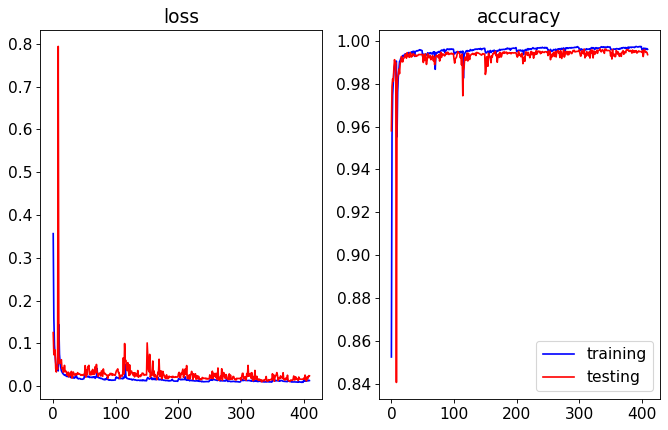

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


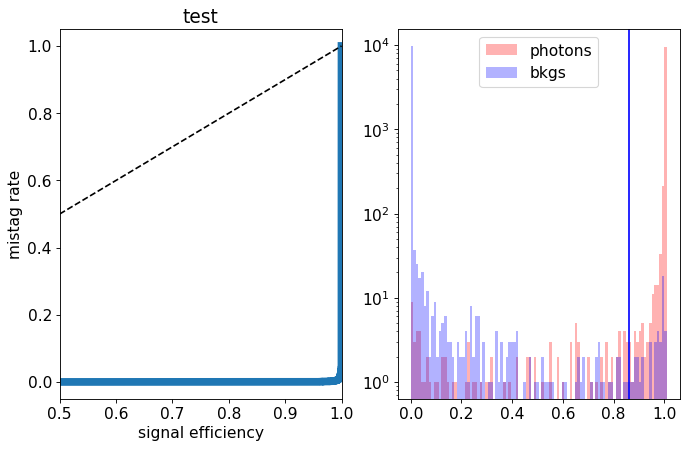

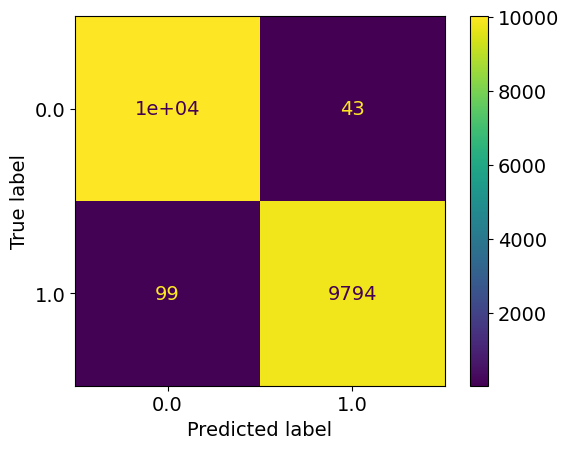

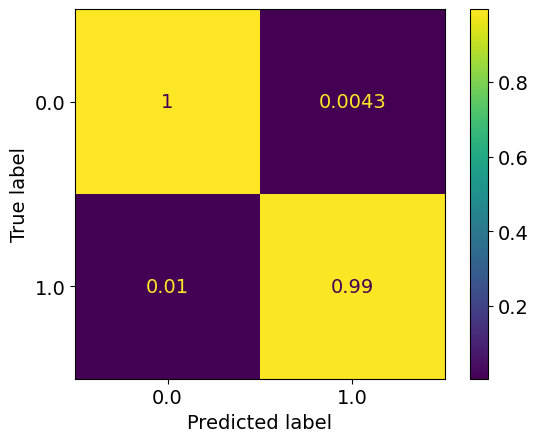

epoch: 410
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.012617578741661256
train acc: 0.9959904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.51it/s]


test loss: 0.015146345434272113
test acc: 0.9948379
epoch: 411
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.011513007950704934
train acc: 0.9964289


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.017247805697158638
test acc: 0.9951887
epoch: 412
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.013510358790908573
train acc: 0.99573976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.019584700595313573
test acc: 0.9945372
epoch: 413
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.012312867873958173
train acc: 0.99610317


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.011137189001173657
test acc: 0.99614096
epoch: 414
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.012371686959653091
train acc: 0.99610317


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.47it/s]


test loss: 0.015401881325113423
test acc: 0.9944369
epoch: 415
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.01119316826955569
train acc: 0.9966043


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.01084165606281364
test acc: 0.99614096
epoch: 416
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.011764649478821873
train acc: 0.99652916


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.02040993931073257
test acc: 0.9932341
epoch: 417
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.01188107370871333
train acc: 0.996454


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.012432584559599705
test acc: 0.9954894
epoch: 418
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.012738324053682831
train acc: 0.9960781


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.021454303902026045
test acc: 0.9932341
epoch: 419
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.014250305281627755
train acc: 0.9955268


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.01813516011872493
test acc: 0.9949381


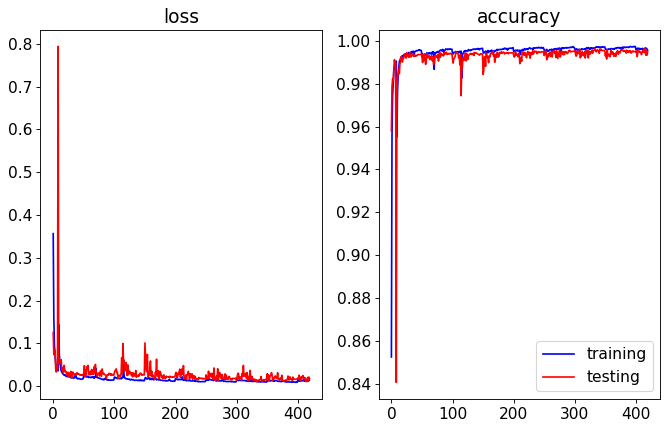

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


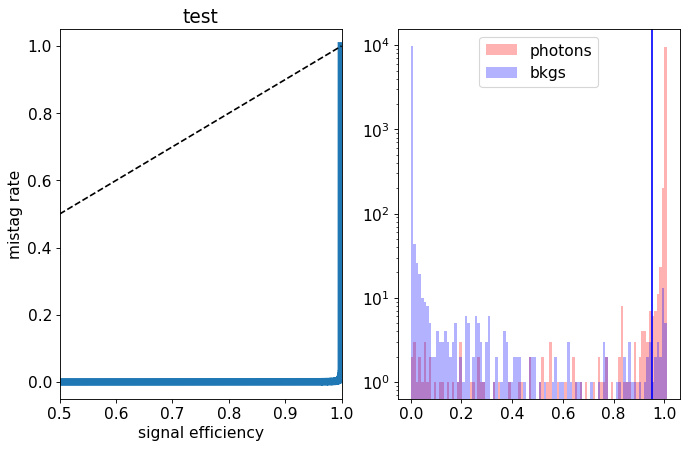

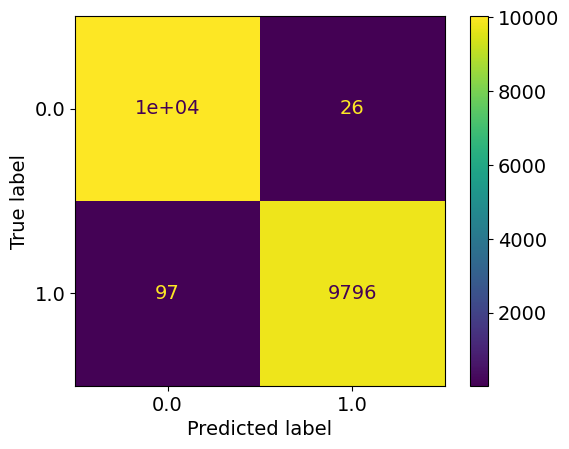

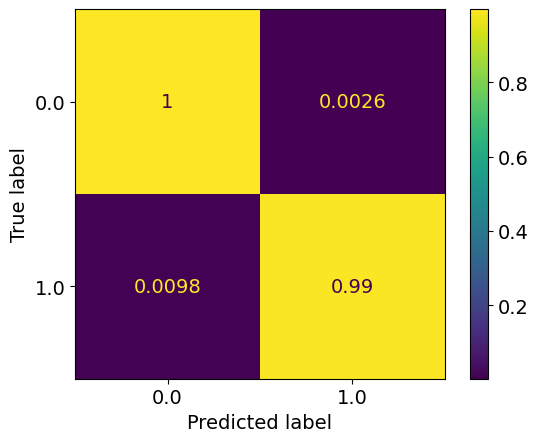

epoch: 420
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011881467929707646
train acc: 0.99639136


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.01754622968078098
test acc: 0.9951887
epoch: 421
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.012327334448285123
train acc: 0.99639136


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.016937764450524223
test acc: 0.9954393
epoch: 422
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011913728857249605
train acc: 0.9967547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.012963157917564624
test acc: 0.99563974
epoch: 423
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.010953424601283002
train acc: 0.99665445


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.011691984632360639
test acc: 0.9959906
epoch: 424
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.010884805171512971
train acc: 0.9967297


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.019891388152780777
test acc: 0.99418634
epoch: 425
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.010404442573281582
train acc: 0.996667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.03729985872119227
test acc: 0.99258256
epoch: 426
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.010750542372459595
train acc: 0.99665445


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.014234414860017268
test acc: 0.99568987
epoch: 427
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011174697519293916
train acc: 0.9967798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.58it/s]


test loss: 0.02136777253711925
test acc: 0.99393576
epoch: 428
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.010026307020739499
train acc: 0.99685496


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.016565944801079563
test acc: 0.99563974
epoch: 429
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.011325916402202254
train acc: 0.99639136


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.020682467568857485
test acc: 0.9937854


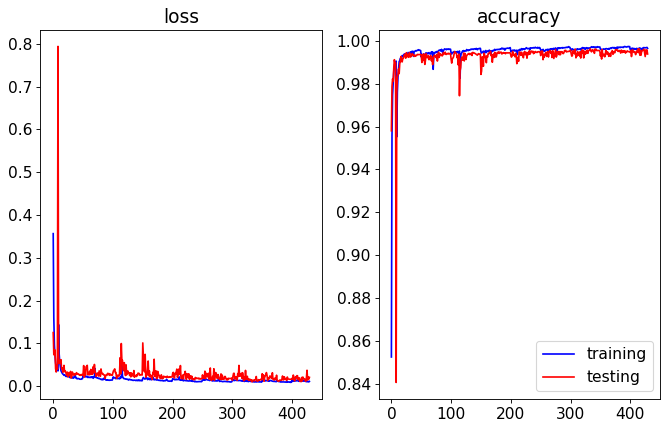

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.21it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


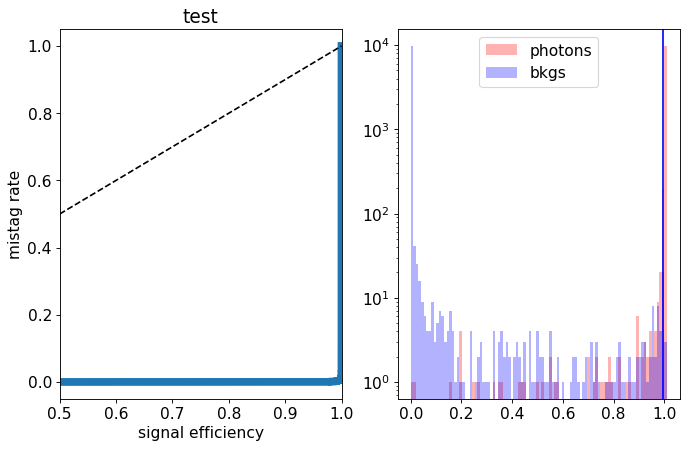

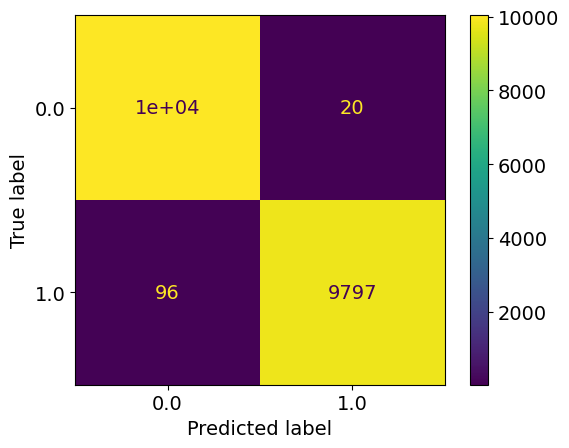

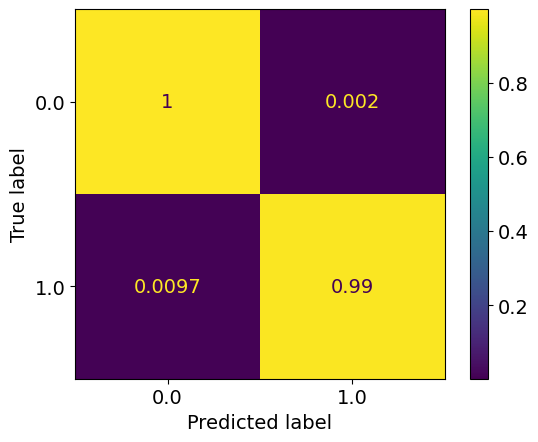

epoch: 430
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.009666993265359927
train acc: 0.997068


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.01859325484067941
test acc: 0.99423647
epoch: 431
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.010296479297572497
train acc: 0.99699277


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.33it/s]


test loss: 0.011625473626361996
test acc: 0.9958903
epoch: 432
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.0111031532157282
train acc: 0.99665445


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.019733542973613915
test acc: 0.99418634
epoch: 433
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011615160128018888
train acc: 0.9961157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.015612857192857465
test acc: 0.9945372
epoch: 434
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.010249535851580189
train acc: 0.9968926


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.021038324376979077
test acc: 0.99363506
epoch: 435
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.010130006293685025
train acc: 0.9968926


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.022388066219932893
test acc: 0.99373525
epoch: 436
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.36it/s]


train loss: 0.009765929004704554
train acc: 0.997093


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.031907316531835345
test acc: 0.9921816
epoch: 437
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.009838679123059768
train acc: 0.9970805


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.015335693328833097
test acc: 0.9949882
epoch: 438
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.009437612664048323
train acc: 0.9970554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.01740564226929564
test acc: 0.99508846
epoch: 439
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.009392088334729423
train acc: 0.9967798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.018562457883757922
test acc: 0.9949882


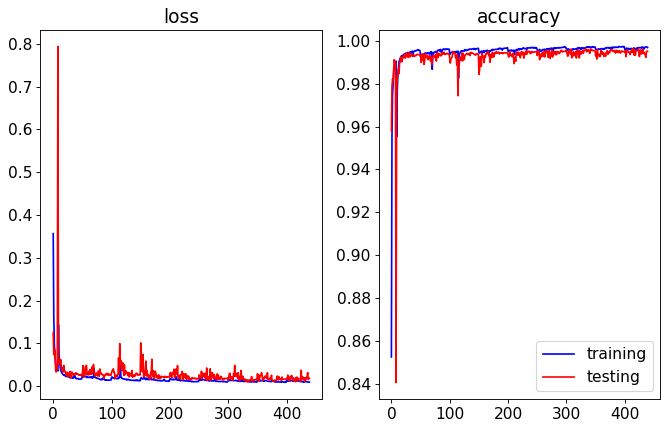

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


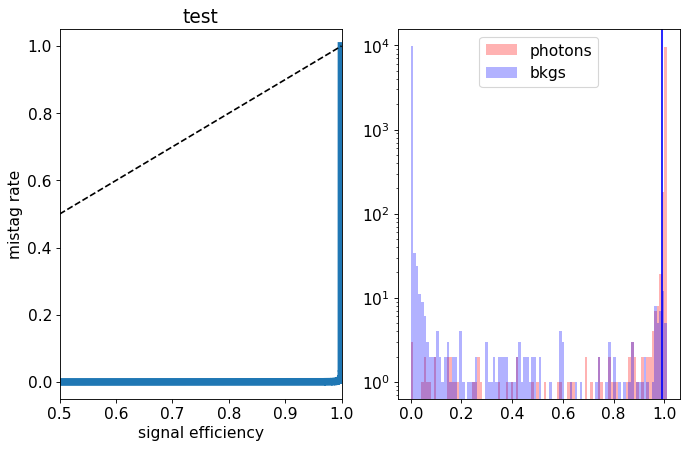

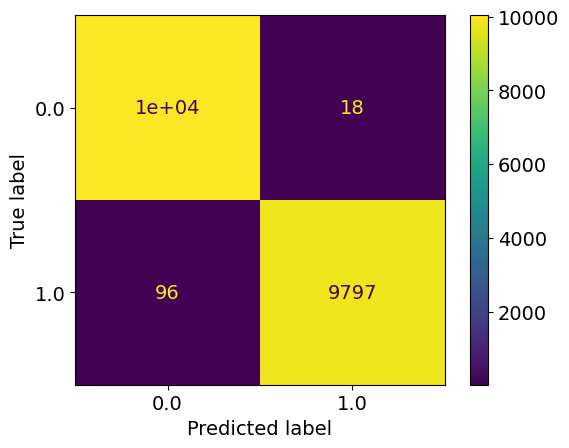

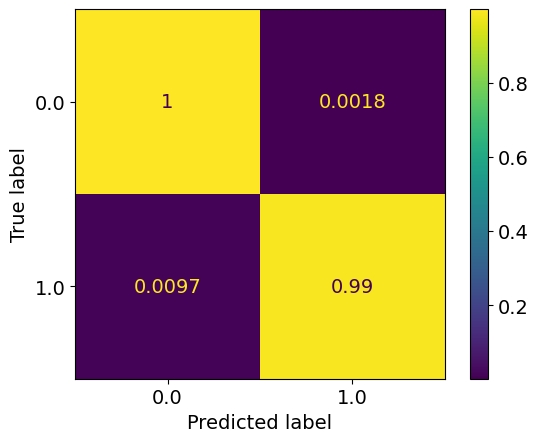

epoch: 440
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.00953472265561021
train acc: 0.99711806


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.32it/s]


test loss: 0.01789652302635231
test acc: 0.9945873
epoch: 441
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.008712114668829166
train acc: 0.99746895


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.09it/s]


test loss: 0.016627283318324342
test acc: 0.99533904
epoch: 442
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.009628841404997701
train acc: 0.9971682


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.015448511971044354
test acc: 0.9952889
epoch: 443
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.00926782772774513
train acc: 0.9972308


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.018227030666928518
test acc: 0.9949882
epoch: 444
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.009949289930108221
train acc: 0.9970554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.43it/s]


test loss: 0.018016745665055865
test acc: 0.9948379
epoch: 445
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.008747860424415166
train acc: 0.9973812


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.57it/s]


test loss: 0.018200719942155153
test acc: 0.9947376
epoch: 446
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.00919663043544854
train acc: 0.9972559


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.57it/s]


test loss: 0.0192675856712466
test acc: 0.9949882
epoch: 447
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.009061848875934453
train acc: 0.99713063


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.016856404349228422
test acc: 0.9949882
epoch: 448
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.0103945418464284
train acc: 0.9972058


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.01756627593353829
test acc: 0.994888
epoch: 449
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.009383328256792165
train acc: 0.9972434


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.016768128481036162
test acc: 0.9949882


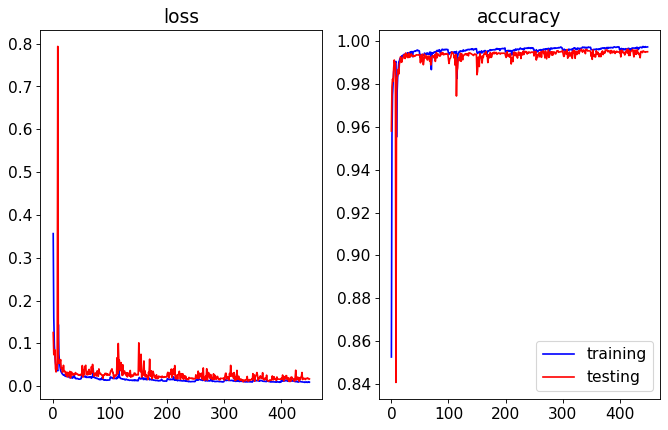

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


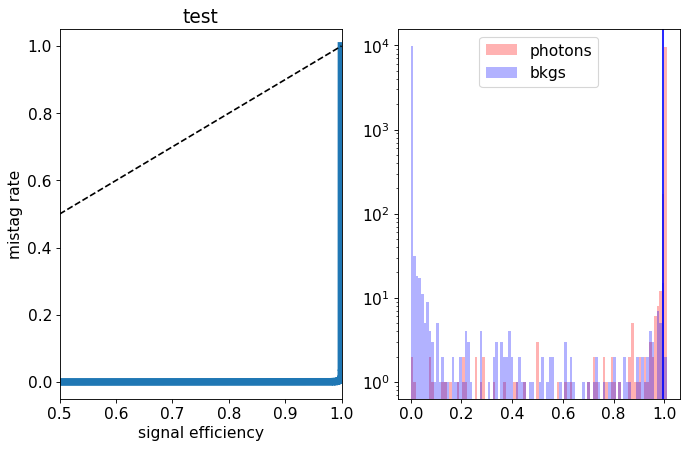

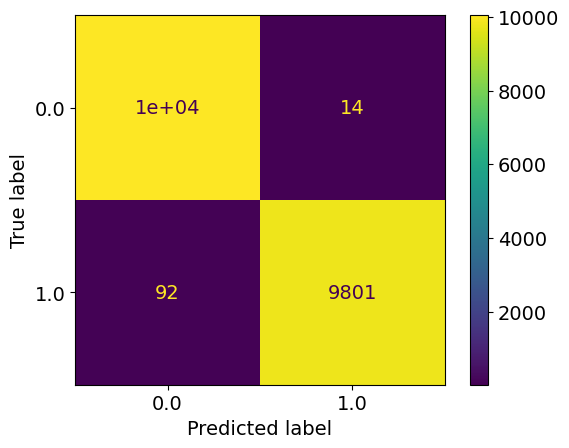

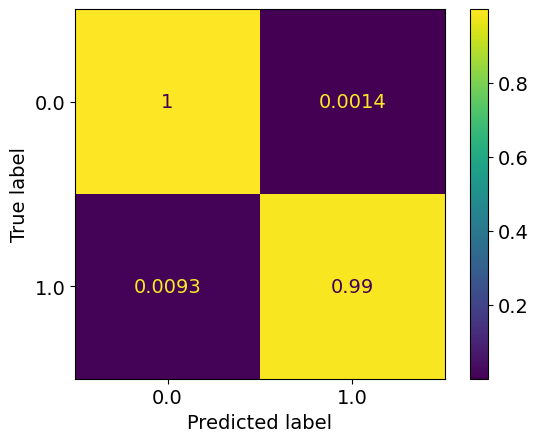

epoch: 450
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01300805105363825
train acc: 0.9961157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.01748358751544455
test acc: 0.9946875
epoch: 451
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.013909309945432399
train acc: 0.99590266


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.51it/s]


test loss: 0.01824969473733183
test acc: 0.9948379
epoch: 452
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.013744501963452394
train acc: 0.99639136


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.012676715142922202
test acc: 0.99584025
epoch: 453
Learning rate: 0.0009911875023977945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.36it/s]


train loss: 0.018471083374443784
train acc: 0.994161


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.020762361666985432
test acc: 0.9949381
epoch: 454
Learning rate: 0.0009843498319744624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.013495286846265836
train acc: 0.9960154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.01732148152009091
test acc: 0.99448705
epoch: 455
Learning rate: 0.0009756006540427171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.01239440113012781
train acc: 0.9962786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.015836846073130694
test acc: 0.9954393
epoch: 456
Learning rate: 0.000964974497610736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.012627615450007885
train acc: 0.9964665


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.02447424133253448
test acc: 0.99168044
epoch: 457
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011989279149305214
train acc: 0.9965793


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.45it/s]


test loss: 0.013508049859678174
test acc: 0.99553955
epoch: 458
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.013075190128883652
train acc: 0.99620336


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.013228726943078287
test acc: 0.99533904
epoch: 459
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.0128189439419657
train acc: 0.99631613


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.015717629993827465
test acc: 0.99478775


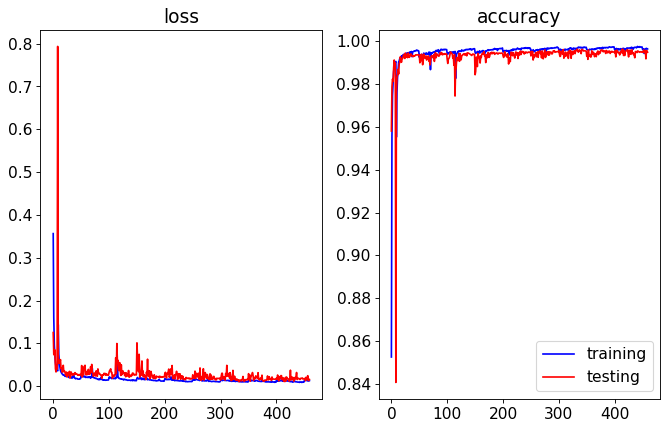

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.65it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


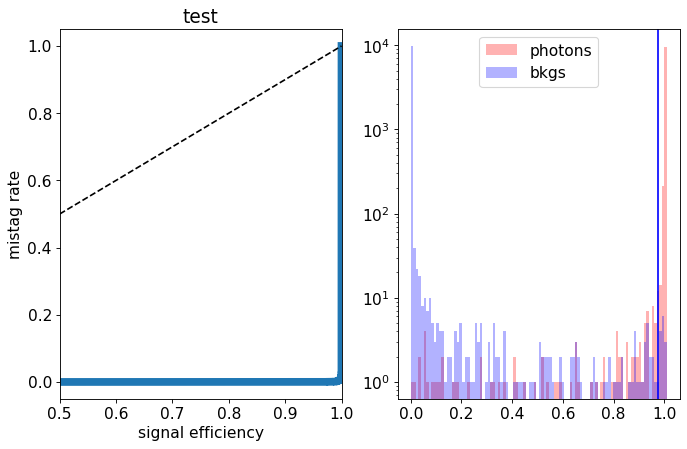

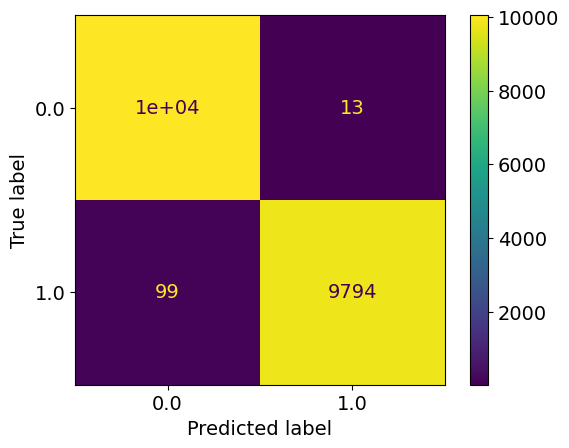

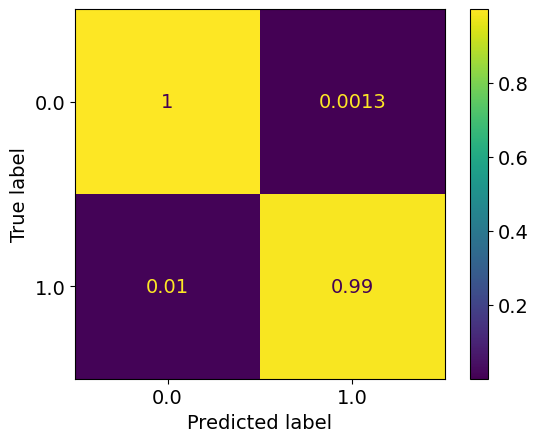

epoch: 460
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.012157274385774158
train acc: 0.9960781


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.022860545144580743
test acc: 0.9932842
epoch: 461
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.011254003393085936
train acc: 0.9964415


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.43it/s]


test loss: 0.01658680339289062
test acc: 0.99478775
epoch: 462
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01183074157087327
train acc: 0.9964415


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.014623359920840491
test acc: 0.99553955
epoch: 463
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01307252161951958
train acc: 0.9960405


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.021223425567287076
test acc: 0.9939859
epoch: 464
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.01191030320247836
train acc: 0.9965793


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.021507078918683177
test acc: 0.9938355
epoch: 465
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.010525924549140777
train acc: 0.99684244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.02138502527411808
test acc: 0.9940861
epoch: 466
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.011362001174354612
train acc: 0.9965417


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]


test loss: 0.010652265648412354
test acc: 0.9966421
new best acc: 0.9966421
epoch: 467
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.011712086742305883
train acc: 0.99667954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.015683930038101285
test acc: 0.9951386
epoch: 468
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.28it/s]


train loss: 0.012234080367293313
train acc: 0.996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.23it/s]


test loss: 0.013036165887195453
test acc: 0.9951386
epoch: 469
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.010815347836755989
train acc: 0.9967297


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.21it/s]


test loss: 0.011804158763398472
test acc: 0.99614096


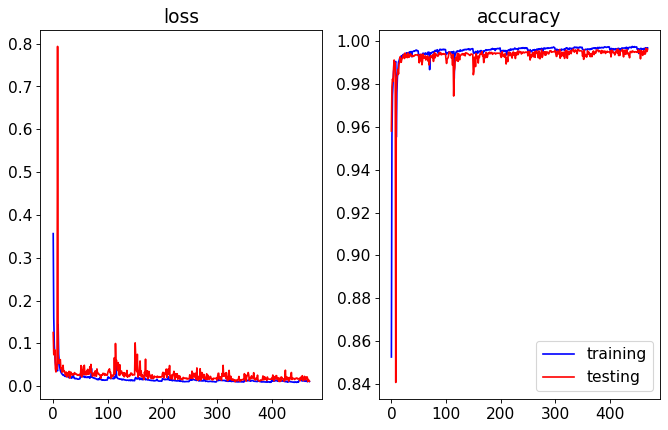

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


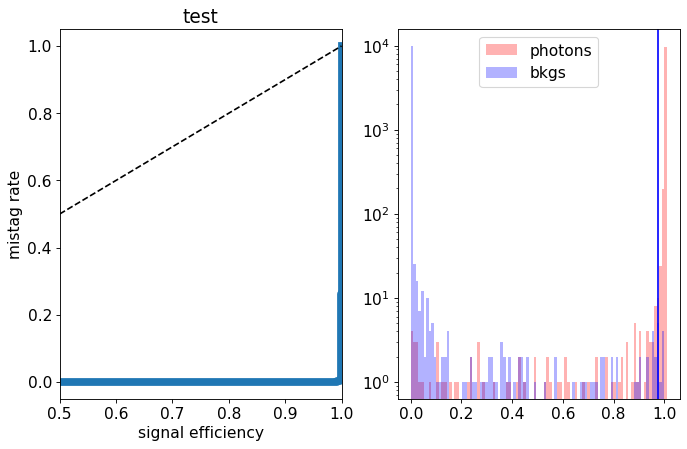

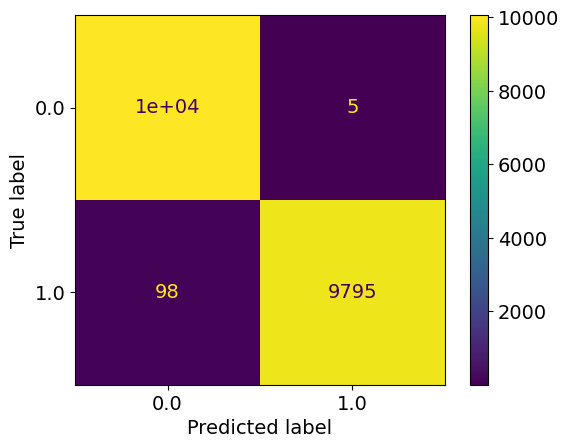

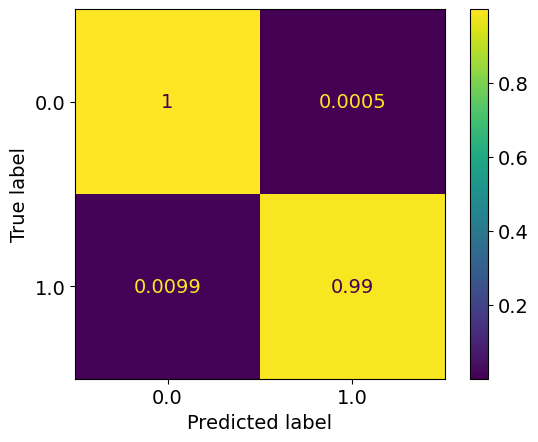

epoch: 470
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.36it/s]


train loss: 0.010885156620703915
train acc: 0.9965417


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.25it/s]


test loss: 0.012382271748185089
test acc: 0.9958903
epoch: 471
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.011482205130658176
train acc: 0.9966169


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.51it/s]


test loss: 0.011845262856428129
test acc: 0.99624115
epoch: 472
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.011455764859365716
train acc: 0.996454


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.04104209778939977
test acc: 0.98967576
epoch: 473
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.010971647346698081
train acc: 0.9965918


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.018538172856685433
test acc: 0.99418634
epoch: 474
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01080956436776636
train acc: 0.9964289


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.47it/s]


test loss: 0.03253397816682563
test acc: 0.9897258
epoch: 475
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.010753530334792476
train acc: 0.9968675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.011681004598572412
test acc: 0.99594045
epoch: 476
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.01255237509986497
train acc: 0.99680483


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.01990078914198367
test acc: 0.99403596
epoch: 477
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.013344885484257111
train acc: 0.99605304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.01331532493521295
test acc: 0.9947376
epoch: 478
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.010601370314130935
train acc: 0.9967672


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.014352869865594102
test acc: 0.9949381
epoch: 479
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.010528336850623404
train acc: 0.9967547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.57it/s]


test loss: 0.014180038281825973
test acc: 0.9949882


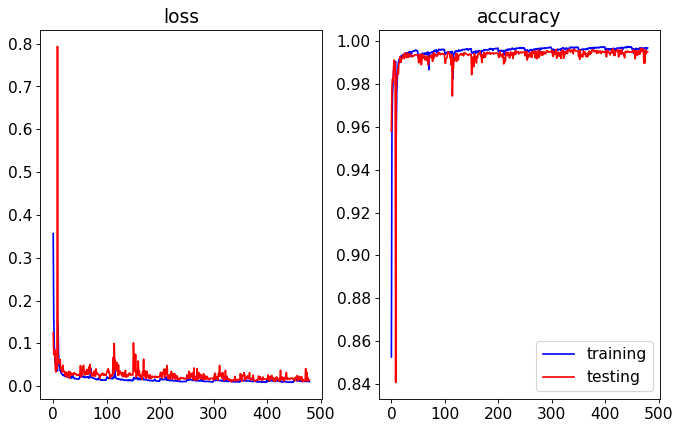

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.52it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


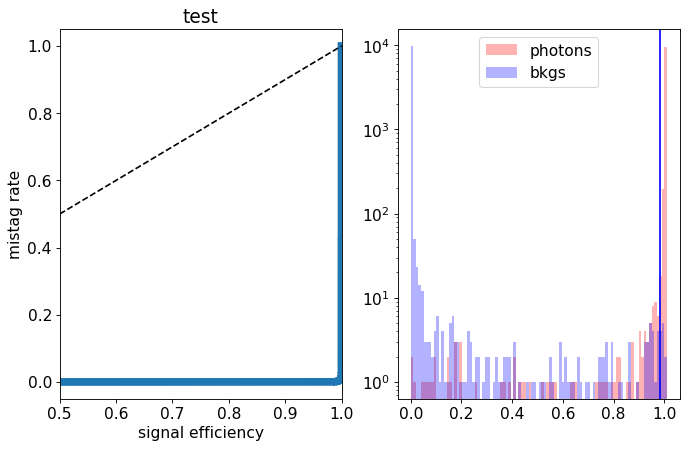

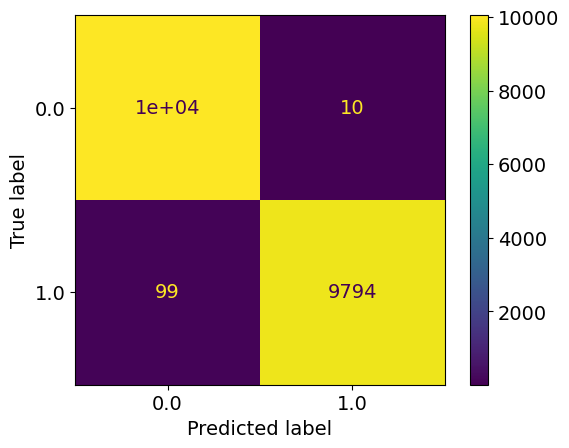

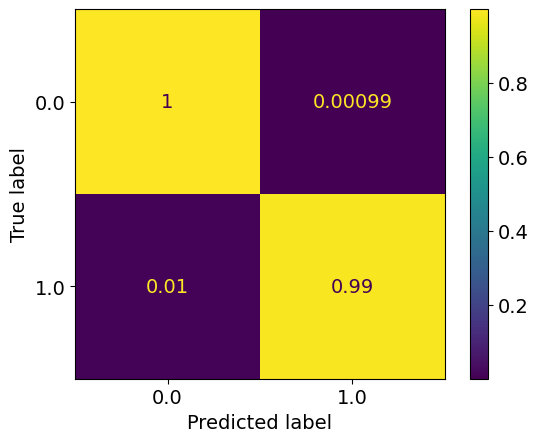

epoch: 480
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.010602743597701192
train acc: 0.9967171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.012610364455373628
test acc: 0.99563974
epoch: 481
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.010125152813916837
train acc: 0.99696773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.016441753952462664
test acc: 0.9943868
epoch: 482
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.0096856971556293
train acc: 0.99713063


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.02093594115200069
test acc: 0.9934847
epoch: 483
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.009858317976841814
train acc: 0.99698025


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.014067144572704016
test acc: 0.99563974
epoch: 484
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.009985123943440118
train acc: 0.99684244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.020216497667955562
test acc: 0.9945372
epoch: 485
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.009505345551262291
train acc: 0.9973562


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.014655785080428948
test acc: 0.99523884
epoch: 486
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.69it/s]


train loss: 0.009709959079984076
train acc: 0.9971933


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.019201013882754043
test acc: 0.99418634
epoch: 487
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.010568368750791163
train acc: 0.99711806


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.01243250205537633
test acc: 0.99574
epoch: 488
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01066016523017638
train acc: 0.9967547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.01750787759802359
test acc: 0.9952889
epoch: 489
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.009096184652472443
train acc: 0.99730605


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.56it/s]


test loss: 0.015553094456931028
test acc: 0.99523884


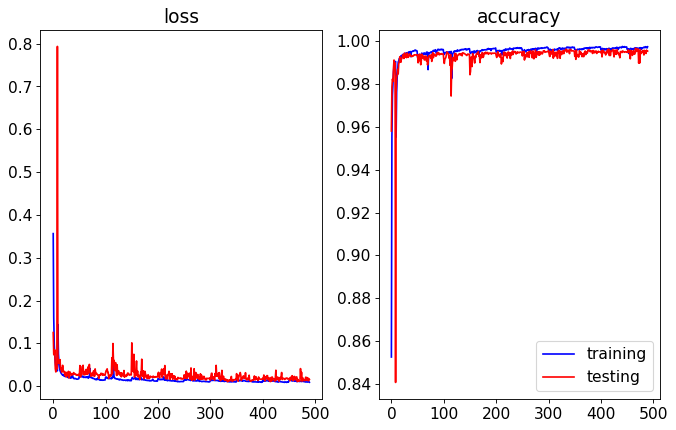

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


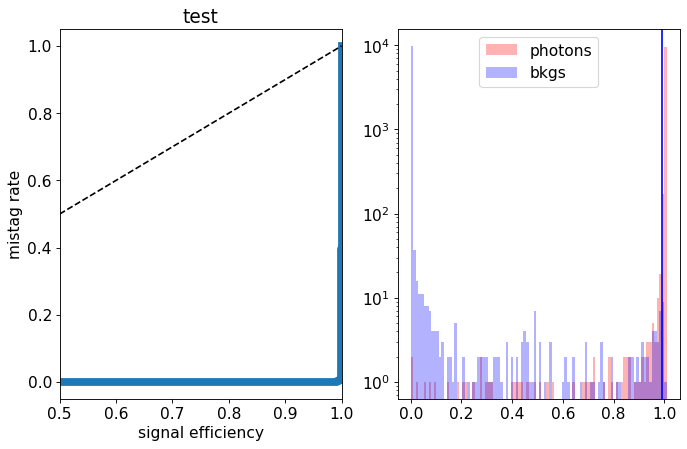

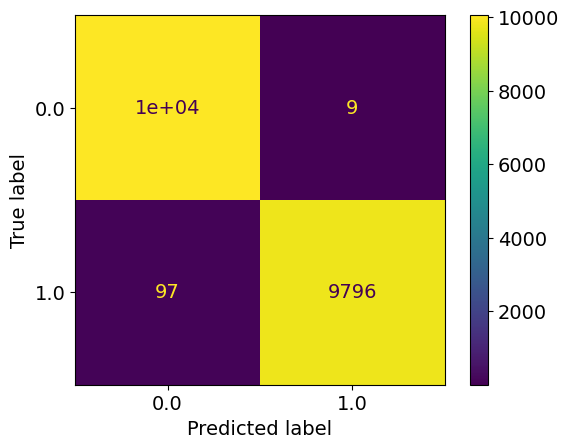

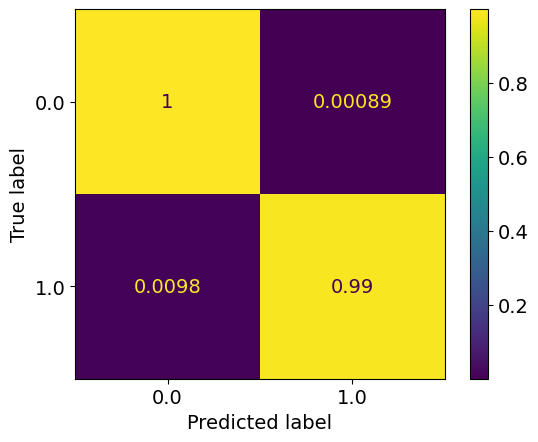

epoch: 490
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.00891025599140891
train acc: 0.9973436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.015320680227459353
test acc: 0.99508846
epoch: 491
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.009151534370206339
train acc: 0.99728096


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.61it/s]


test loss: 0.01610769092119025
test acc: 0.9951887
epoch: 492
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009327214797645974
train acc: 0.9971682


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.014984033959883484
test acc: 0.99533904
epoch: 493
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.0086241720334342
train acc: 0.9973812


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.51it/s]


test loss: 0.015272369298412847
test acc: 0.9951386
epoch: 494
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.009048635649595604
train acc: 0.9970805


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.015886269319761434
test acc: 0.99503833
epoch: 495
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.009482361493562859
train acc: 0.99710554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.01660827302154811
test acc: 0.9949882
epoch: 496
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.009805689049787375
train acc: 0.99715567


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.02031981006182511
test acc: 0.994888
epoch: 497
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.010250649912762385
train acc: 0.9973436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]


test loss: 0.016541283346561936
test acc: 0.9948379
epoch: 498
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.009250321976390011
train acc: 0.997093


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.54it/s]


test loss: 0.016620305816318518
test acc: 0.9948379
epoch: 499
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.009161825958757102
train acc: 0.9970554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.53it/s]


test loss: 0.016660487762077108
test acc: 0.9948379


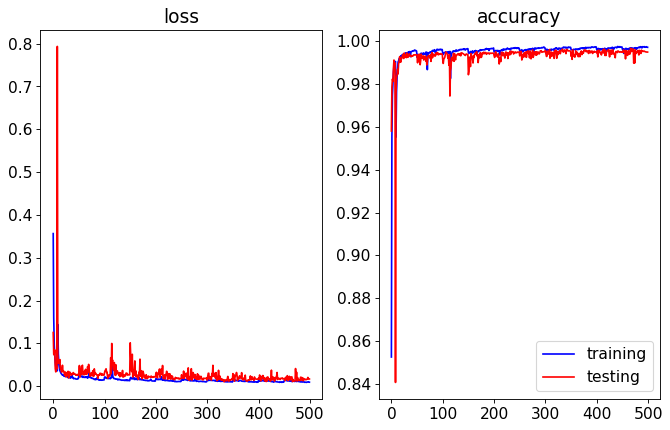

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.55it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


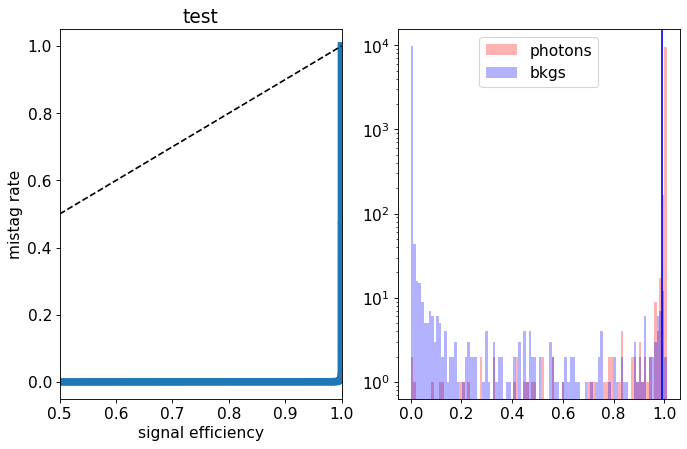

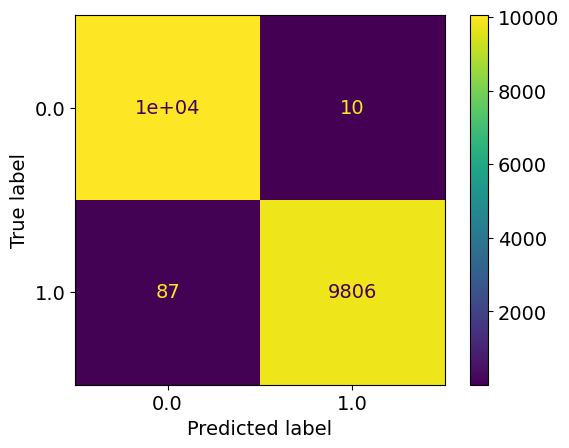

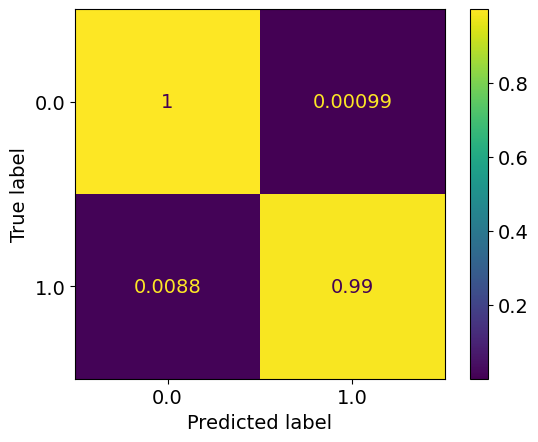

In [16]:
from tqdm import tqdm as tqdm

## OUTPUT directory
checkpoint_dir = out_dir
os.makedirs(checkpoint_dir, exist_ok=True)


nepoch=500
best_loss = 99999999
best_acc = 0.
losst = []
lossv = []
acct = []
accv = []
epochs = []
for epoch in range(nepoch):
    print ('epoch:',epoch)
    print("Learning rate:", optimizer.param_groups[0]['lr'])
    loss_t, acc_t = train(epoch)
    losst.append(loss_t)
    acct.append(acc_t)
    loss_v, acc_v = test(epoch)
    loss_epoch = loss_v
    lossv.append(loss_epoch)
    accv.append(acc_v)
    epochs.append(epoch)

    
     
    
    checkpoint = {
    'epoch': epoch + 1,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
    }
    checkpoint_file = 'model_epoch_%i.pth.tar' % ( epoch )
    torch.save(checkpoint,
                   os.path.join(checkpoint_dir,checkpoint_file ))
    
#     if loss_epoch < best_loss:
#         best_loss = loss_epoch
#         print('new best test loss:',best_loss)
#         torch.save(checkpoint,
#                    os.path.join(checkpoint_dir,'model_checkpoint_best.pth.tar' ))
    
    
    if acc_v > best_acc:
        print('new best acc:',acc_v)
        best_acc = acc_v
        torch.save(checkpoint,
                   os.path.join(checkpoint_dir,'model_checkpoint_bestacc.pth.tar' ))
    
    if ((epoch+1)%10 == 0):
        fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10, 6),dpi=80)
        
        ax0.plot(np.array(epochs),np.array(losst),c='b',label='training')
        ax0.plot(np.array(epochs),np.array(lossv),c='r',label='testing')
        ax0.title.set_text("loss")
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        #plt.legend()
        #plt.show()
        ax1.plot(np.array(epochs),np.array(acct),c='b',label='training')
        ax1.plot(np.array(epochs),np.array(accv),c='r',label='testing')
        ax1.title.set_text("accuracy")
        plt.legend()
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        plt.show()
        
        
        model.eval()
        scores = []
        trues = []
        true_preds, num_preds = 0., 0.
        for data in tqdm(testloader): ### change to loaderDNN for DNN
                datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
                optimizer.zero_grad()
                #label = label.to(torch.long).squeeze()
                result = model(datax, masks, info3d)
                scores.append(torch.exp(result)[:,1].detach().cpu().flatten().numpy())
                trues.append(label.detach().cpu().numpy().flatten())
        
        
        truesa = np.hstack(trues)
        scoresa = np.hstack(scores)
        fpr, tpr, thresholds = metrics.roc_curve(truesa, scoresa, pos_label=1)
        aucv = metrics.auc(fpr, tpr)

        tpr90,fpr90,threshold90 = 0,0,0
        for i,j,k in zip(tpr,fpr,thresholds):
            if i >0.99:
                tpr90 = i
                fpr90 = j
                threshold90 = k
                break

        fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10, 6),dpi=80)
        plt.rcParams['font.size'] = '14'
        ax0.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
        ax0.set_xlabel("signal efficiency")
        ax0.set_ylabel("mistag rate")
        ax0.set_xlim([0.5,1])
        ax0.plot([0.,1], [0.,1], 'k--')
        ax0.title.set_text("test")
        plt.legend()
        #ax.text(0.6,0.6,aucv,)
        #plt.yscale("log")
        
        ax1.hist(scoresa[truesa == 1],bins=100, range=[0,1.01], label='photons',linewidth=2.0, color="r" , alpha=0.3)
        ax1.hist(scoresa[truesa == 0],bins=100, range=[0,1.01], label='bkgs',linewidth=2.0, color="b", alpha=0.3 )
        ax1.axvline(threshold90,c="b")
        plt.yscale("log")
        plt.legend()
        plt.show()

        
        
        
        
        
        ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0))
        plt.show()
        ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="true")
        plt.show()
        

In [17]:
#print(epoch_size)

## Inference with model of last epoch

### Confusion matrix and Accuracy on test dataset

In [18]:
device = torch.device('cuda:1')
model.to(device)
model.eval()
scores = []
trues = []
true_preds, num_preds = 0., 0.
for data in tqdm(testloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        optimizer.zero_grad()
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        scores.append(torch.exp(result)[:,1].detach().cpu().flatten().numpy())
        trues.append(label.detach().cpu().numpy().flatten())
        #break

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


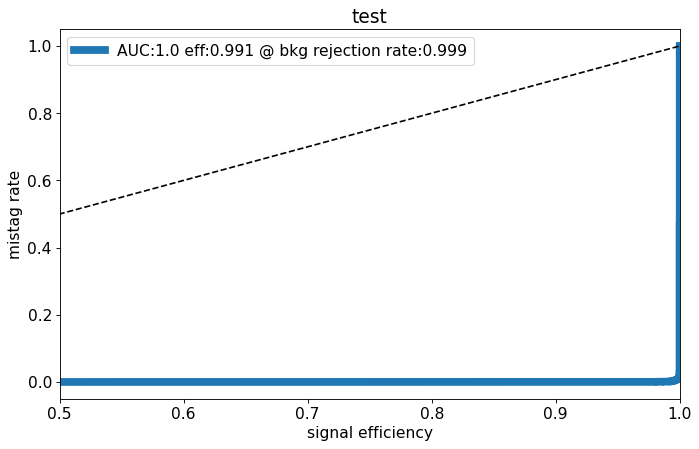

In [19]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.hstack(trues), np.hstack(scores), pos_label=1)
aucv = metrics.auc(fpr, tpr)

tpr90,fpr90,threshold90 = 0,0,0
for i,j,k in zip(tpr,fpr,thresholds):
    if i >0.99:
        tpr90 = i
        fpr90 = j
        threshold90 = k
        break

fig, ax = plt.subplots(figsize=(10, 6),dpi=80)
plt.rcParams['font.size'] = '14'
ax.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
ax.set_xlabel("signal efficiency")
ax.set_ylabel("mistag rate")
ax.set_xlim([0.5,1])
ax.plot([0.,1], [0.,1], 'k--')
ax.title.set_text("test")
#ax.text(0.6,0.6,aucv,)
#plt.yscale("log")
plt.legend()
plt.show()

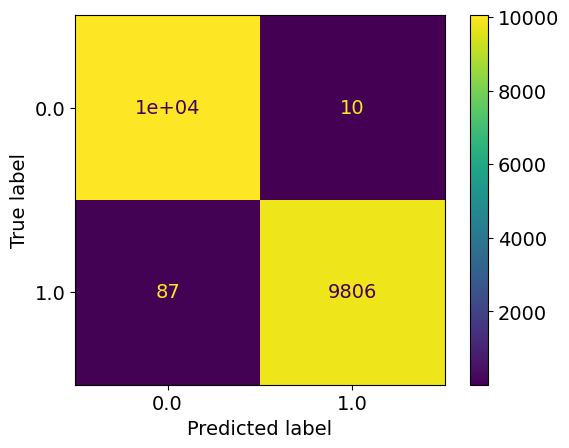

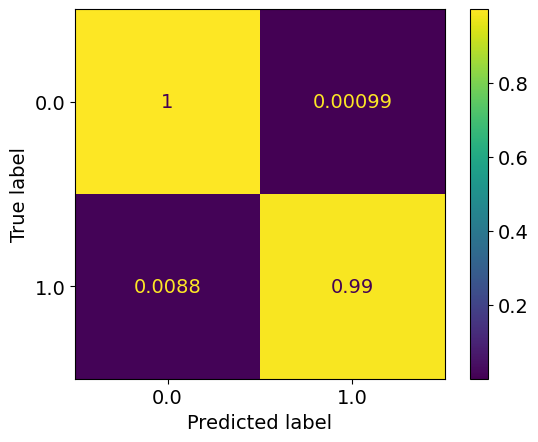

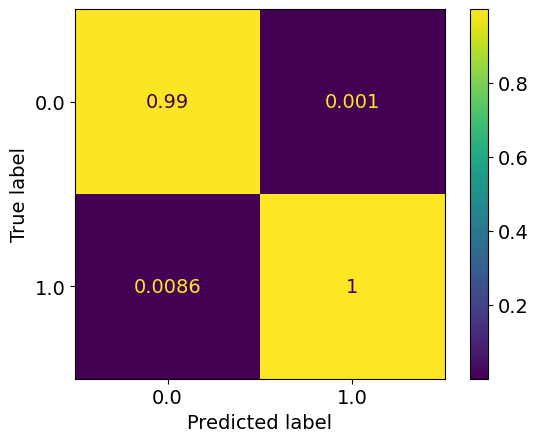

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#confusion_matrix(np.hstack(trues), np.where(np.hstack(scores)>0.5, 1, 0))

ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0))
plt.show()
ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="true")
plt.show()
ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="pred")
plt.show()

## Inference with model of best accuracy checkpoint

### Load best accuracy checkpoint and define model

In [21]:
### REMEMBER: specify the correct input model

device = torch.device('cuda:1')#('cuda' if torch.cuda.is_available() else 'cpu')
model_load = torch.load(out_dir+"/model_checkpoint_bestacc.pth.tar")
print(out_dir)


model = MHA_model(n_seq=150,
        input_dim = 4,
        dim_emb = 16,#32
        n_heads = 16,
        num_enclayers = 6,#4
        dim_feedforward = 64,
        output_dim = 2)


model.to(device)
model.load_state_dict(model_load["state_dict"])
model.eval()

20250227_235925_checkpoints


/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/jit/_recursive.py:266: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


MHA_model(
  (emb_inp): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=Dropout)
    (2): RecursiveScriptModule(original_name=ELU)
    (3): RecursiveScriptModule(original_name=Linear)
    (4): RecursiveScriptModule(original_name=Dropout)
    (5): RecursiveScriptModule(original_name=ELU)
  )
  (transformer_encoder): RecursiveScriptModule(
    original_name=TransformerEncoder
    (layers): RecursiveScriptModule(
      original_name=ModuleList
      (0): RecursiveScriptModule(
        original_name=TransformerEncoderLayer
        (self_attn): RecursiveScriptModule(
          original_name=MultiheadAttention
          (out_proj): RecursiveScriptModule(original_name=NonDynamicallyQuantizableLinear)
        )
        (linear1): RecursiveScriptModule(original_name=Linear)
        (dropout): RecursiveScriptModule(original_name=Dropout)
        (linear2): RecursiveScriptModule(original_name=Lin

### Confusion matrix and accuracy on test dataset (testloader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.81it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


accuracy: 0.9966421
threshold : 0.7975697


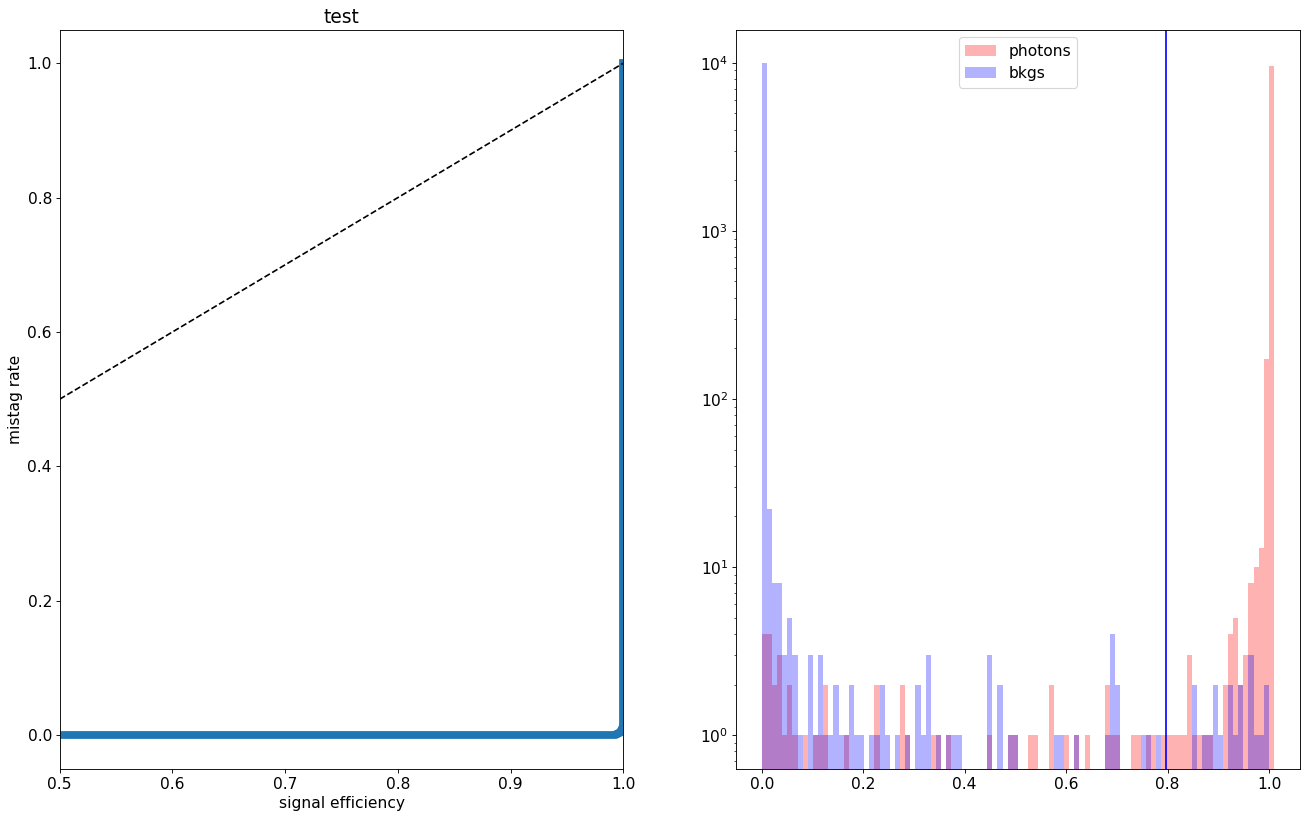

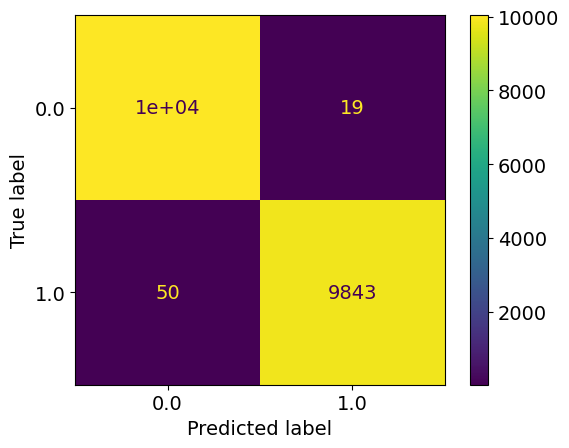

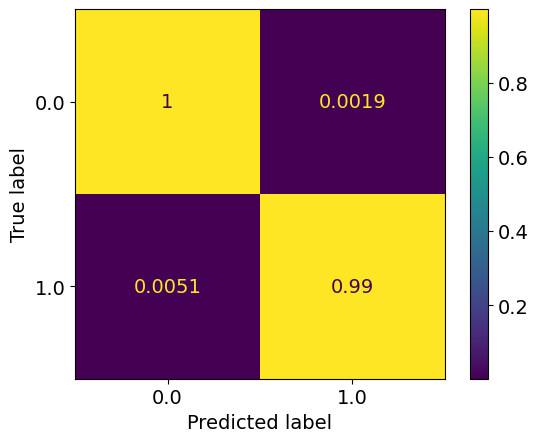

In [22]:
scores = []
trues = []
true_preds, num_preds = 0., 0.
#threshold90 = 0.152
mispredpho = []
mispredbkg = []
for data in tqdm(testloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )

######## use the following lines if you want to store mispredicted event indices for plotting  (REMEMBER to set batch_size=1)

#        opt = np.where(np.hstack(op)>threshold90, 1, 0)
#        if (ip == 1)&(opt == 0):
#            mispredpho.append(datax.detach().cpu().numpy())
#        elif (ip == 0)&(opt == 1):
#            mispredbkg.append(datax.detach().cpu().numpy())

        
        
        ######## use the following lines if you want just the overall scores for accuracy etc (Use this when you want to extract threshold and plot confusion matrices)
        
        label = label.to(torch.long).squeeze()
        pred_labels = torch.argmax(result.cpu(), dim=-1) 
        true_preds += (pred_labels == label.cpu()).sum()
        num_preds += label.shape[0]
        
acc = true_preds / num_preds
print("accuracy:",np.mean(np.array(acc)))

########################### this part extracts the threshold value and plots overall confusion matrices

truesa = np.hstack(trues)
scoresa = np.hstack(scores)
fpr, tpr, thresholds = metrics.roc_curve(truesa, scoresa, pos_label=1)
aucv = metrics.auc(fpr, tpr)

tpr90,fpr90,threshold90_test = 0,0,0
for i,j,k in zip(tpr,fpr,thresholds):
    if i >0.995:
        tpr90 = i
        fpr90 = j
        threshold90_test = k
        break
print("threshold :",threshold90_test)
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(20, 12),dpi=80)
plt.rcParams['font.size'] = '14'
### plot AUC
ax0.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
ax0.set_xlabel("signal efficiency")
ax0.set_ylabel("mistag rate")
ax0.set_xlim([0.5,1])
ax0.plot([0.,1], [0.,1], 'k--')
ax0.title.set_text("test")
plt.legend()
#plt.show()

## plot signal-bkg distribution
ax1.hist(scoresa[truesa == 1],bins=100, range=[0,1.01], label='photons',linewidth=2.0, color="r" , alpha=0.3)
ax1.hist(scoresa[truesa == 0],bins=100, range=[0,1.01], label='bkgs',linewidth=2.0, color="b", alpha=0.3 )
ax1.axvline(threshold90_test,c="b")
plt.yscale("log")
plt.legend()
plt.show()

#ax.text(0.6,0.6,aucv,)
#plt.yscale("log")
#plt.legend()
#plt.show()



### plot confusion matrices
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90_test, 1, 0))
plt.show()
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90_test, 1, 0), normalize="true")
plt.show()

### Confusion matrix and accuracy on full dataset (totalloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:10<00:00, 15.35it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


accuracy: 0.9974439
threshold : 0.8511485


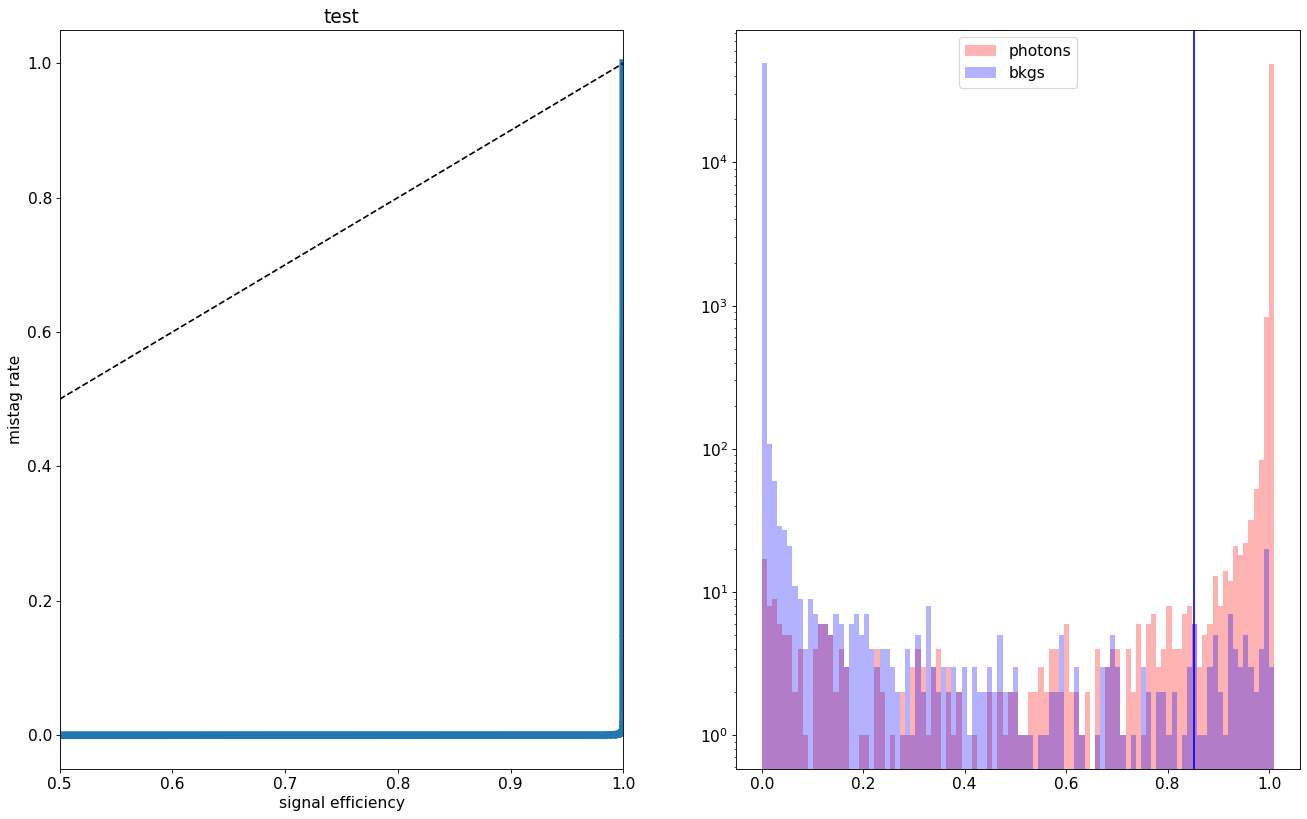

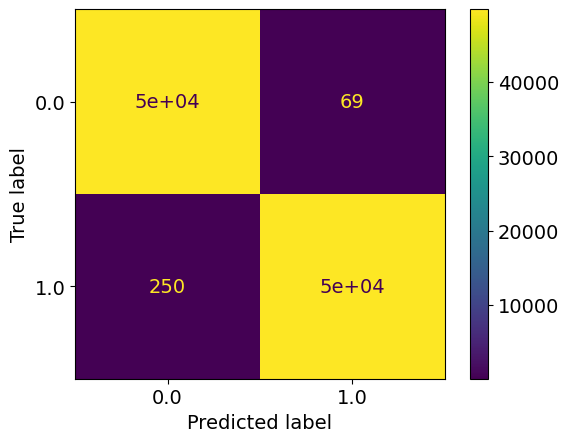

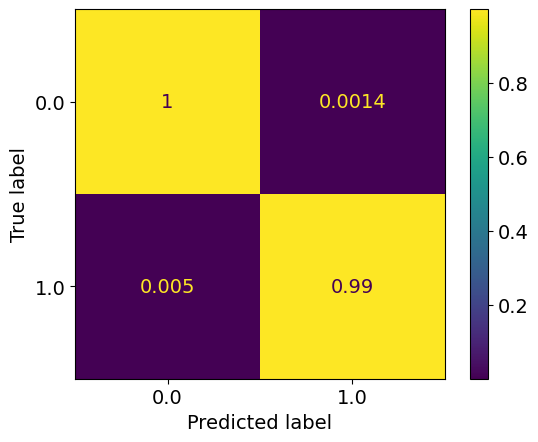

In [23]:
scores = []
trues = []
true_preds, num_preds = 0., 0.
#threshold90 = 0.152
mispredpho = []
mispredbkg = []
for data in tqdm(totalloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )
     
        ######## use the following lines if you want just the overall scores for accuracy etc (Use this when you want to extract threshold and plot confusion matrices)
        
        label = label.to(torch.long).squeeze()
        pred_labels = torch.argmax(result.cpu(), dim=-1) 
        true_preds += (pred_labels == label.cpu()).sum()
        num_preds += label.shape[0]
        
acc = true_preds / num_preds
print("accuracy:",np.mean(np.array(acc)))

########################### this part extracts the threshold value and plots overall confusion matrices

truesa = np.hstack(trues)
scoresa = np.hstack(scores)
fpr, tpr, thresholds = metrics.roc_curve(truesa, scoresa, pos_label=1)
aucv = metrics.auc(fpr, tpr)

tpr90,fpr90,threshold90_tot = 0,0,0
for i,j,k in zip(tpr,fpr,thresholds):
    if i >0.995:
        tpr90 = i
        fpr90 = j
        threshold90_tot = k
        break
print("threshold :",threshold90_tot)
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(20, 12),dpi=80)
plt.rcParams['font.size'] = '14'
### plot AUC
ax0.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
ax0.set_xlabel("signal efficiency")
ax0.set_ylabel("mistag rate")
ax0.set_xlim([0.5,1])
ax0.plot([0.,1], [0.,1], 'k--')
ax0.title.set_text("test")
plt.legend()
#plt.show()

## plot signal-bkg distribution
ax1.hist(scoresa[truesa == 1],bins=100, range=[0,1.01], label='photons',linewidth=2.0, color="r" , alpha=0.3)
ax1.hist(scoresa[truesa == 0],bins=100, range=[0,1.01], label='bkgs',linewidth=2.0, color="b", alpha=0.3 )
ax1.axvline(threshold90_tot,c="b")
plt.yscale("log")
plt.legend()
plt.show()

#ax.text(0.6,0.6,aucv,)
#plt.yscale("log")
#plt.legend()
#plt.show()



### plot confusion matrices
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90_tot, 1, 0))
plt.show()
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90_tot, 1, 0), normalize="true")
plt.show()

### Plot mispredicted events

In [24]:
### set batch_size=1
testloader = torch.utils.data.DataLoader(tsdata, batch_size=1,shuffle=True)#, num_workers=2)
totalloader = torch.utils.data.DataLoader(combdataset, batch_size=1,shuffle=True)#, num_workers=2)

#### mispredicted events on test dataset (testloader)

  0%|                                                                                                                         | 0/19953 [00:00<?, ?it/s]/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/nn/modules/module.py:1501: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at ../third_party/nvfuser/csrc/manager.cpp:335.)
  return forward_call(*args, **kwargs)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19953/19953 [01:18<00:00, 254.76it/s]


threshold 0.7975697
mispred_pho 50


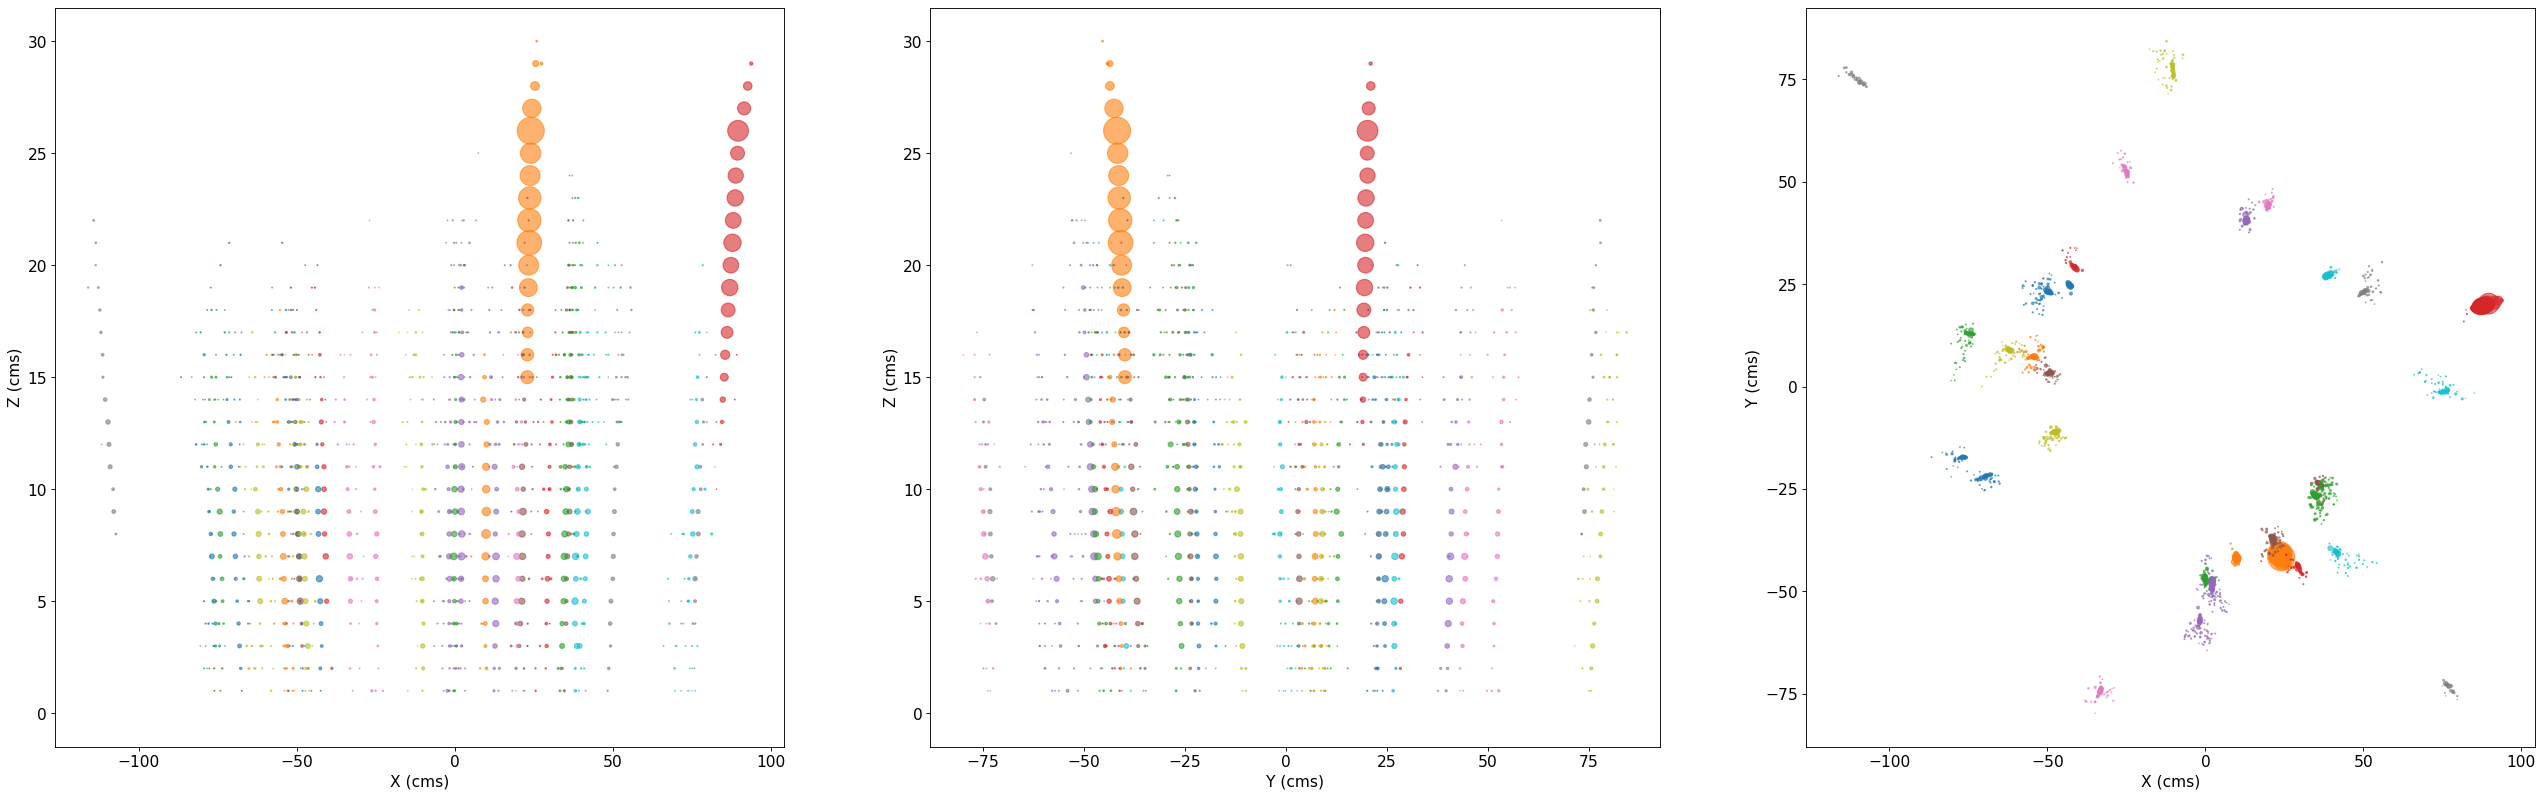

mispred_bkg 19


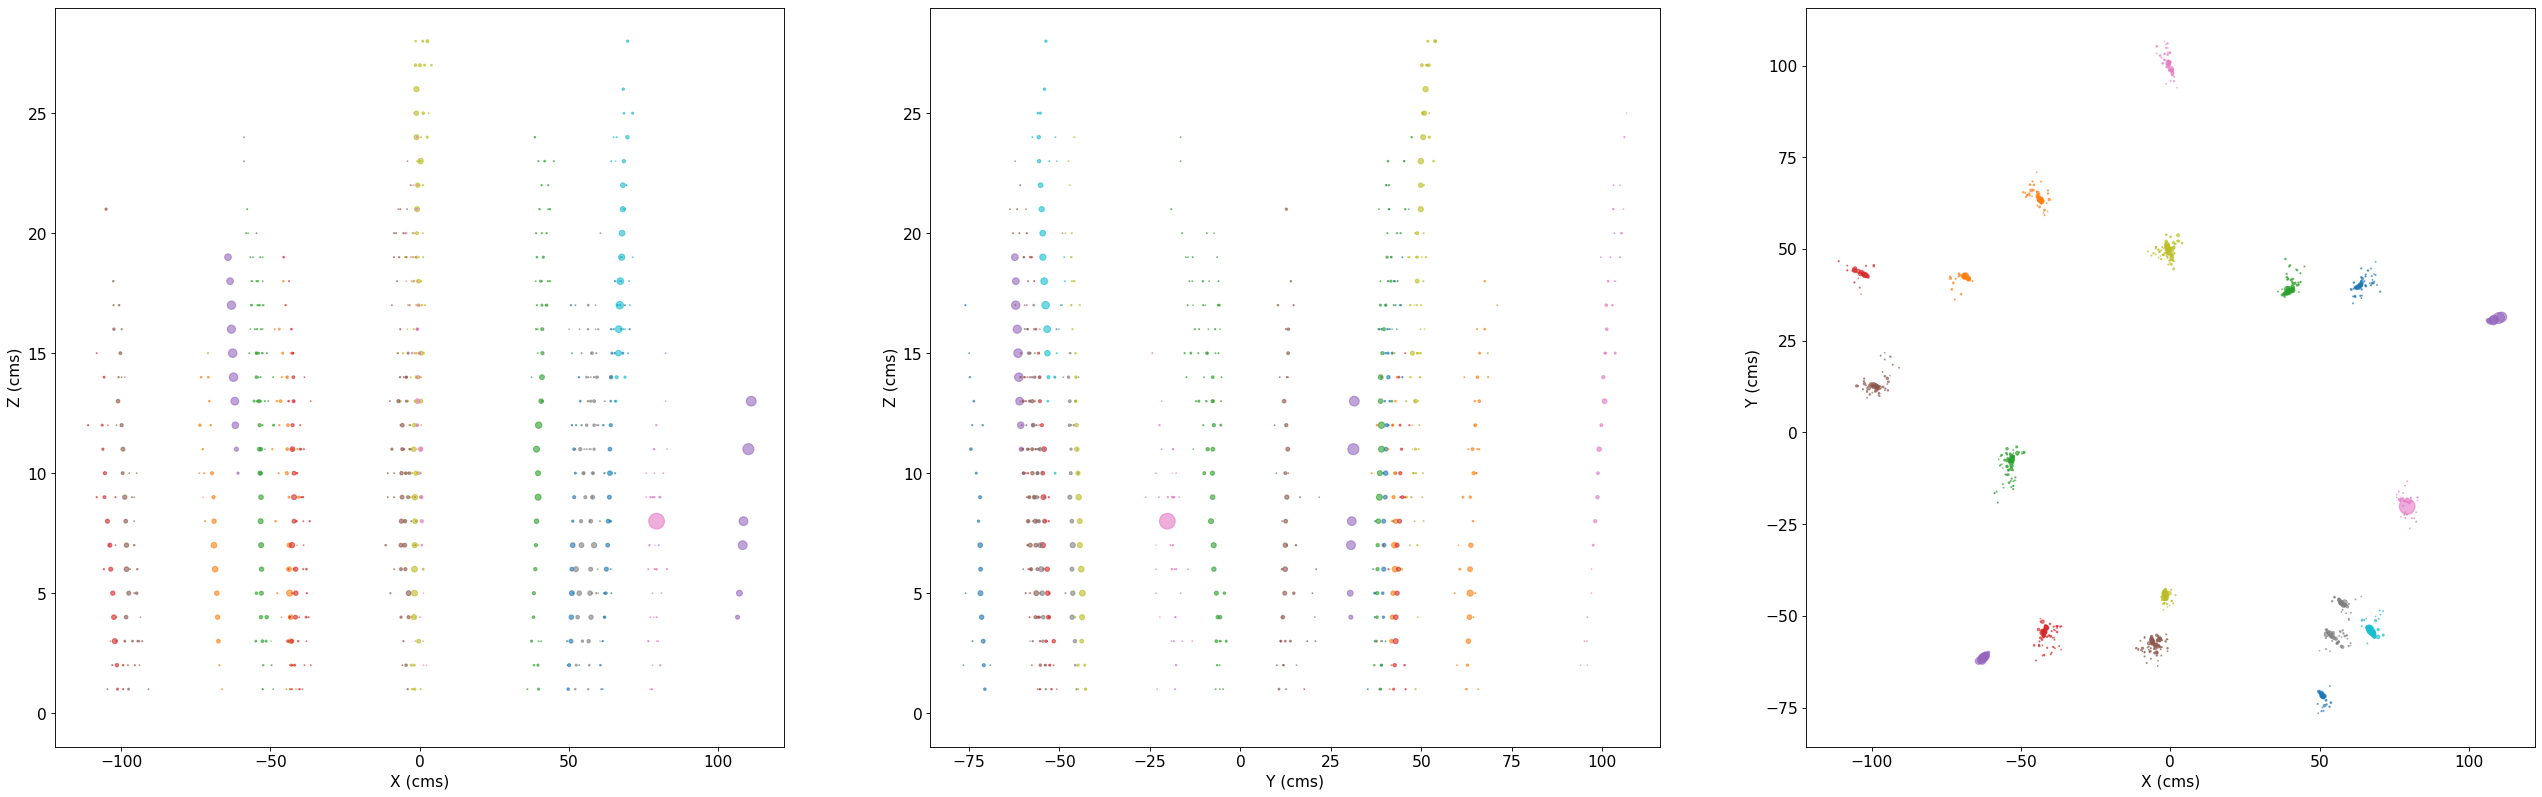

In [25]:
## REMEMBER to specify the threshold (to match the one obtained above)
scores = []
trues = []
true_preds, num_preds = 0., 0.
threshold90 = threshold90_test #0.152
mispredpho = []
mispredbkg = []
for data in tqdm(testloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )

######## use the following lines if you want to store mispredicted event indices for plotting  (REMEMBER to set batch_size=1)

        opt = np.where(np.hstack(op)>threshold90, 1, 0)
        if (ip == 1)&(opt == 0):
            mispredpho.append(datax.detach().cpu().numpy())
        elif (ip == 0)&(opt == 1):
            mispredbkg.append(datax.detach().cpu().numpy())



#Plot mispredicted events:
print("threshold", threshold90)

## mispredicted PHOTONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_pho",len(mispredpho))
cc = 0
for uarray in mispredpho:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')

    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()

## mispredicted PIONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_bkg",len(mispredbkg))
cc = 0
for uarray in mispredbkg:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')

    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()

#### mispredicted events on full dataset (totalloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99761/99761 [06:37<00:00, 250.92it/s]


threshold 0.8511485
mispred_pho 250


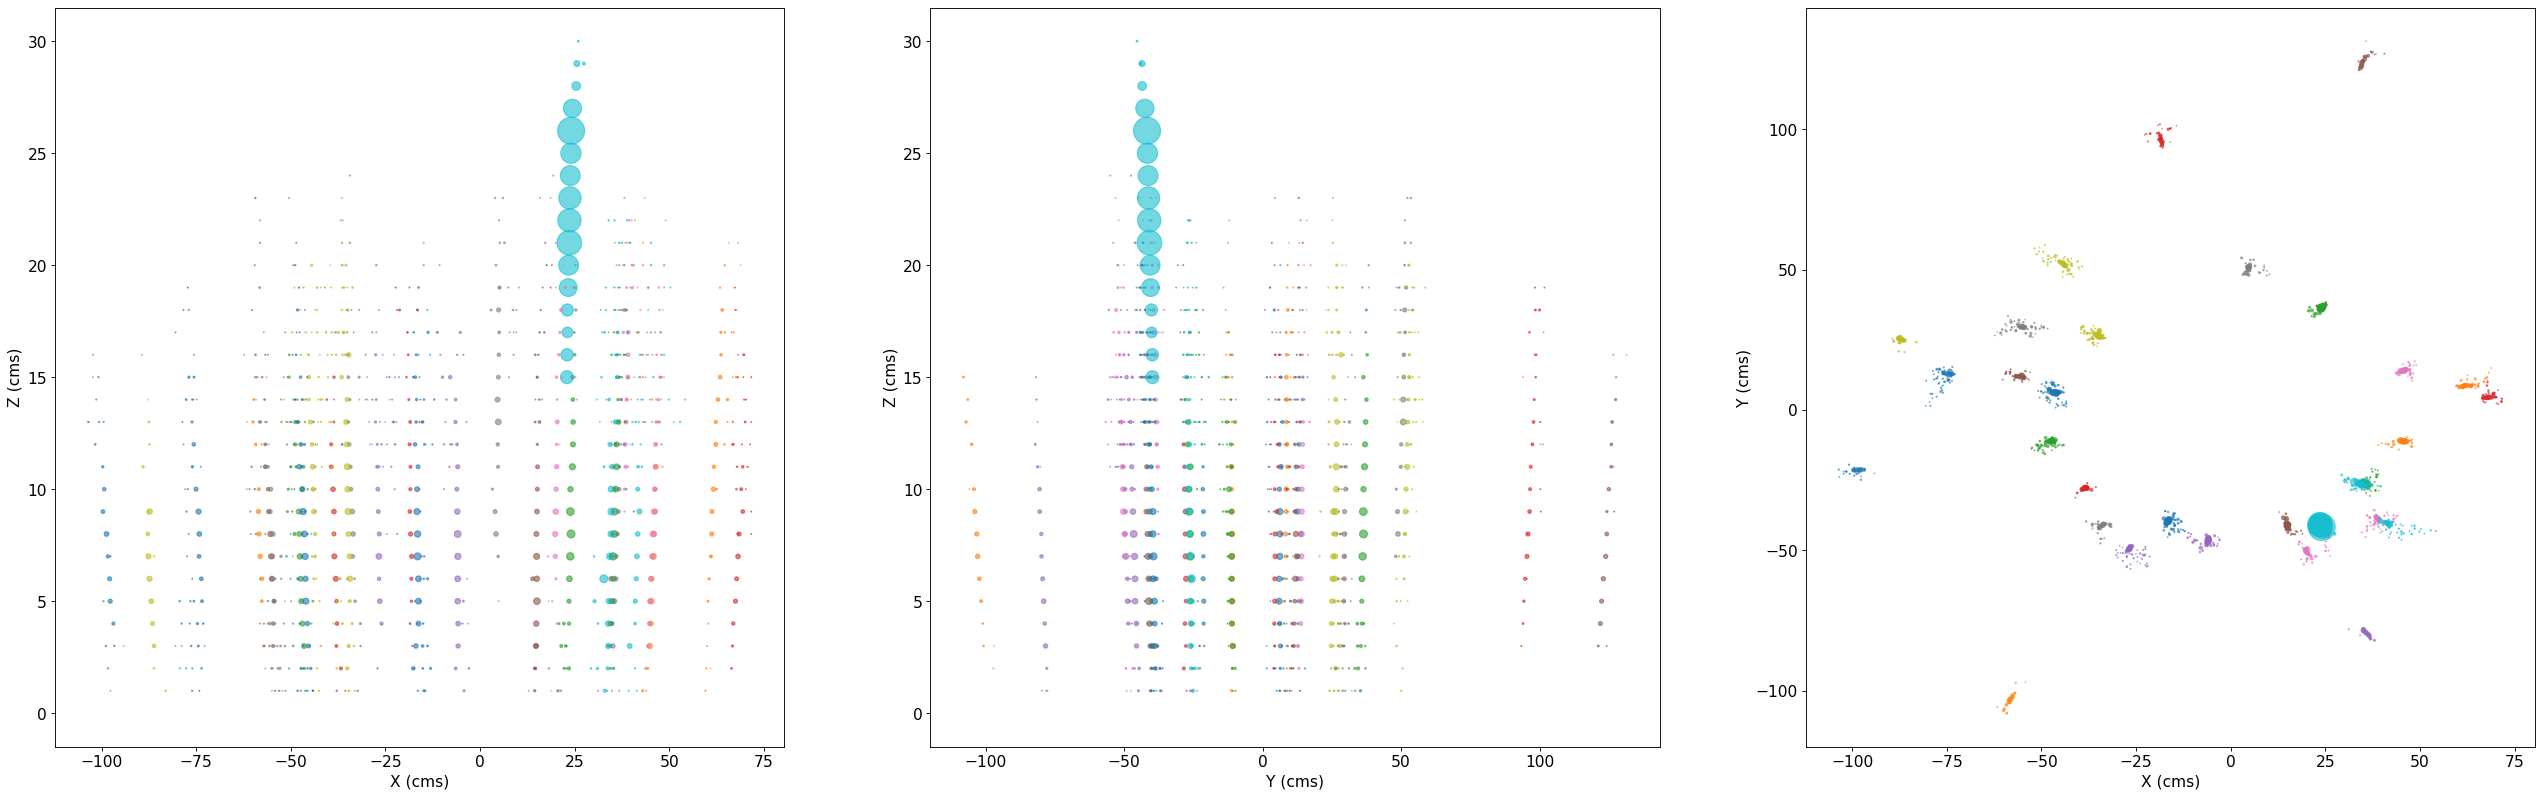

mispred_bkg 69


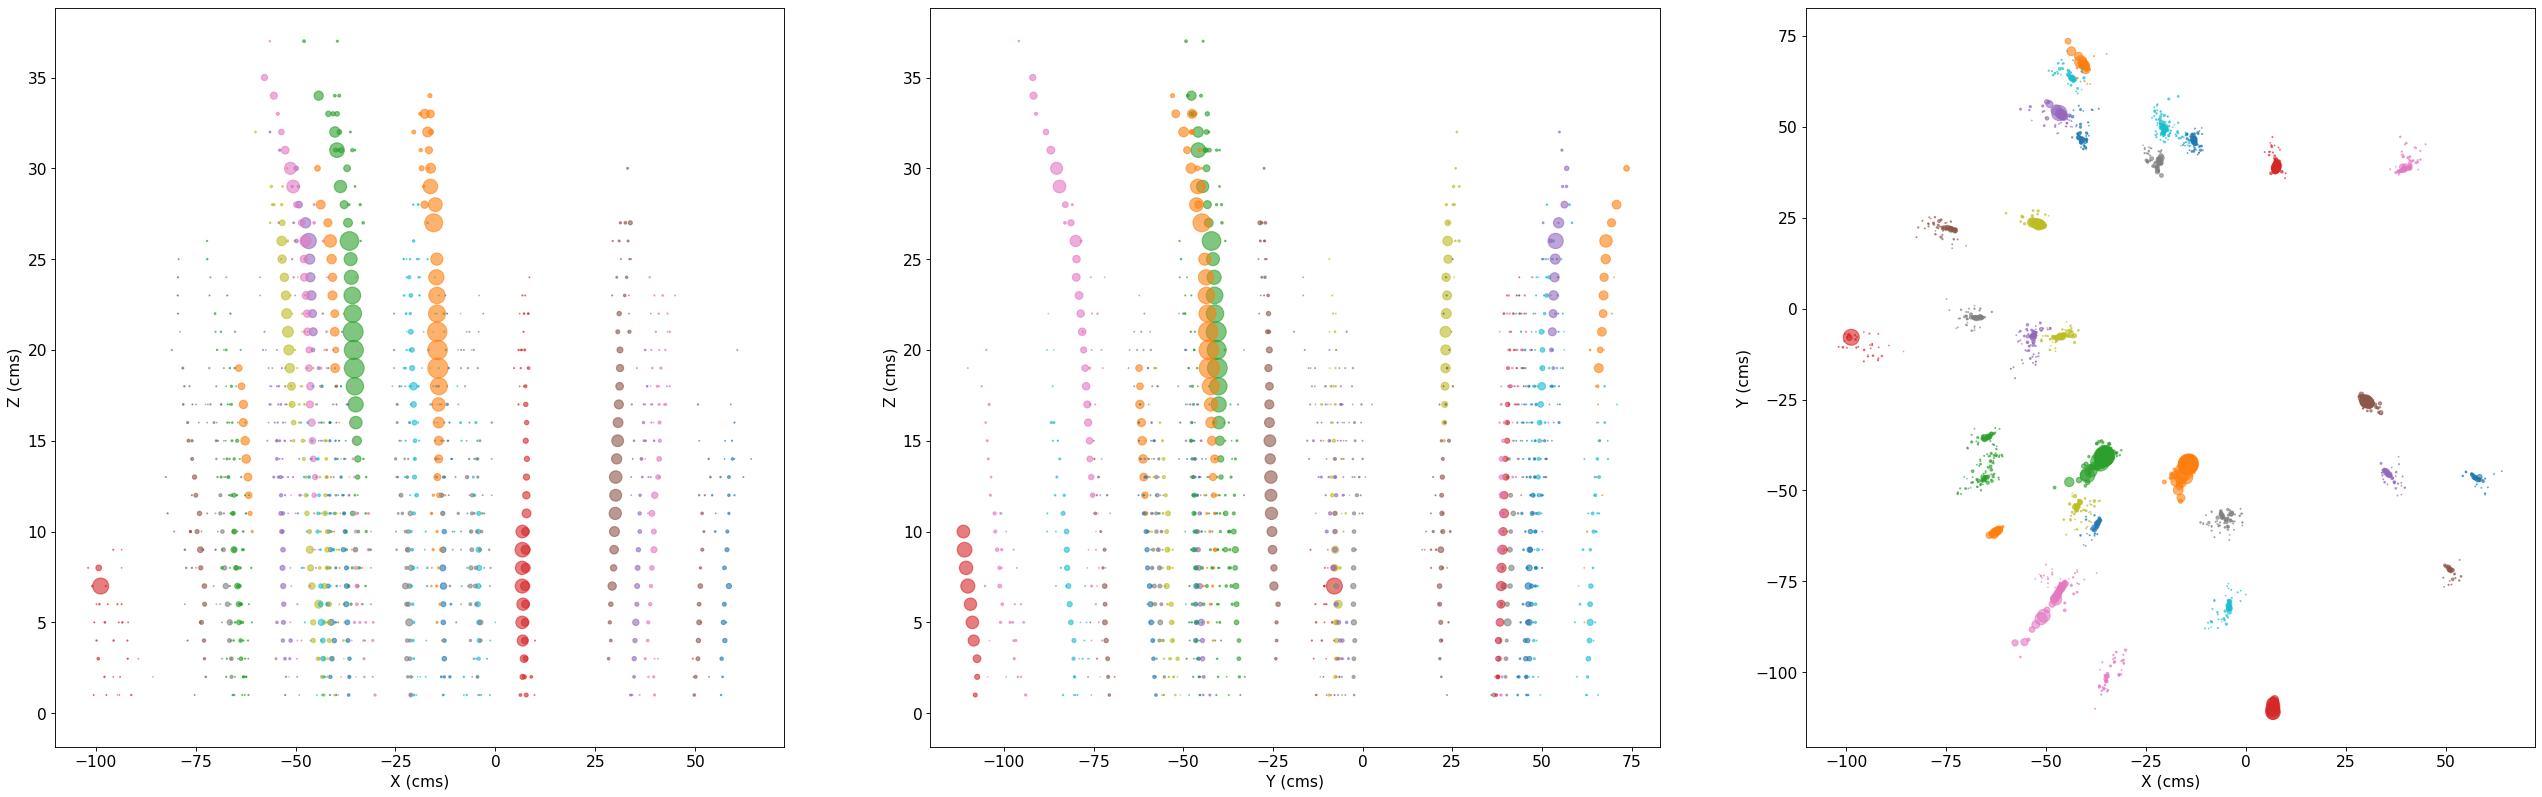

In [26]:
## REMEMBER to specify the threshold (to match the one obtained above)
scores = []
trues = []
true_preds, num_preds = 0., 0.
threshold90 = threshold90_tot #0.152
mispredpho = []
mispredbkg = []
for data in tqdm(totalloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )

######## use the following lines if you want to store mispredicted event indices for plotting  (REMEMBER to set batch_size=1)

        opt = np.where(np.hstack(op)>threshold90, 1, 0)
        if (ip == 1)&(opt == 0):
            mispredpho.append(datax.detach().cpu().numpy())
        elif (ip == 0)&(opt == 1):
            mispredbkg.append(datax.detach().cpu().numpy())



#Plot mispredicted events:
print("threshold", threshold90)

## mispredicted PHOTONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_pho",len(mispredpho))
cc = 0
for uarray in mispredpho:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')

    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()

## mispredicted PIONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_bkg",len(mispredbkg))
cc = 0
for uarray in mispredbkg:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')

    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()